# Classificazione con GNN su ogbn-arxiv

In questo notebook esploriamo approcci avanzati per la classificazione dei nodi nel dataset ogbn-arxiv, con focus su:
- **Preprocessing ed esplorazione dei dati**
- **GCN e varianti GNN**
- **Classificatori classici: SVM, regressione logistica, Naive Bayes, Decision Tree**
- **Metric Learning con Triplet Loss**
- **Classificazione con XGBoost e Correct & Smooth (CES)**
- **Confronto finale delle performance**

---

## 1. Preprocessing ed esplorazione dei dati

Iniziamo con il caricamento del dataset ogbn-arxiv e l'esplorazione delle sue caratteristiche principali:
- Numero di nodi e archi
- Distribuzione temporale degli articoli
- Distribuzione delle classi

[Output e grafici del codice corrispondente qui sotto]

---

## 2. Modelli GNN: GCN e varianti

In questa sezione implementiamo Graph Neural Network per la classificazione:
- GCN standard
- GCN con **Correct & Smooth**
- GAT e GraphSAGE (solo se usati)

Valutiamo le performance sui set di validazione e test.

---

## 3. Classificatori classici su feature raw

Applichiamo classificatori tradizionali direttamente sulle feature originarie (senza informazioni strutturali del grafo):
- **SVM**
- **Regressione logistica**
- **Naive Bayes**
- **Decision Tree**

Confrontiamo la loro accuratezza rispetto ai modelli basati su GNN.

---

## 4. Metric Learning e classificazione avanzata

Utilizziamo gli embedding appresi dalle GNN per migliorare le performance classificative:
- Metric Learning tramite architettura siamese e **Triplet Loss**
- Classificazione avanzata con **XGBoost**
- Integrazione con **Correct & Smooth (CES)** per una propagazione più efficace delle etichette

---

## 5. Confronto finale delle performance

Mettiamo a confronto tutti gli approcci implementati:
- Tabella comparativa delle metriche
- Discussione sui trade-off tra GNN end-to-end, classificatori classici e pipeline embedding-based

---


In [20]:
import torch
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.transforms import ToUndirected
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import gzip
import csv



In [21]:
from IPython.display import Markdown, display

def md(msg):
    display(Markdown(msg))


In [22]:
def load_label_mapping(path):
    label_to_category = {}
    with gzip.open(path, 'rt') as f:
        reader = csv.reader(f)
        next(reader)  # salta header
        for row in reader:
            label_to_category[int(row[0])] = row[1]
    return label_to_category


from torch_geometric.data.storage import GlobalStorage
from torch_geometric.data.data import DataEdgeAttr, DataTensorAttr





##  Dataset: OGBN-Arxiv

Il dataset **OGBN-Arxiv** fa parte dell'Open Graph Benchmark (OGB) ed è un grafo etichettato di tipo **node classification**, costruito a partire dai metadati degli articoli pubblicati su arXiv nella categoria "Computer Science".

### Obiettivo
L’obiettivo è predire il **campo di ricerca** di ciascun articolo scientifico (es. "Machine Learning", "Networking", "Computer Vision", ecc.), a partire dal grafo di citazioni tra articoli e dalle caratteristiche testuali dei paper.

###  Struttura dei dati
- **Nodi**: 169,343 articoli scientifici.
- **Archi**: 1,166,243 collegamenti di citazione (direzionali, ma trasformati in **non direzionali** con `ToUndirected()`).
- **Feature**: Ogni nodo è rappresentato da un vettore di 128 dimensioni derivato da BoW-TFIDF su parole chiave e abstract (non interpretabili singolarmente).
- **Etichette**: 40 classi, ognuna corrispondente a una categoria arXiv (caricate con `labelidx2arxivcategeory.csv.gz`).

###  Split predefiniti (benchmark standard)
Il dataset fornisce **split ufficiali** per garantire confrontabilità:
- `train`: ~54,000 nodi
- `valid`: ~6,000 nodi
- `test`: ~48,000 nodi

Questi split sono bilanciati e rappresentativi, e **non devono essere modificati** per mantenere la validità del benchmark.



In [23]:
dataset = PygNodePropPredDataset(
    name='ogbn-arxiv',
    transform=ToUndirected(),
    root='dataset/ogbn-arxiv'
)
data = dataset[0]

mapping_path = 'dataset/ogbn-arxiv/ogbn_arxiv/mapping/labelidx2arxivcategeory.csv.gz'
label_to_category = load_label_mapping(mapping_path)
class_names = [label_to_category[i] for i in range(len(label_to_category))]


In [21]:
from rich.console import Console
from rich.table import Table
from rich import box

console = Console()

table = Table(title="📊 Informazioni sul Dataset ogbn-arxiv", box=box.ROUNDED, show_edge=True, style="bold white")

table.add_column("🧠 Caratteristica", style="cyan", justify="left")
table.add_column("📎 Valore", style="magenta", justify="right")

table.add_row("📦 Dataset", str(dataset))
table.add_row("📈 Numero nodi ", f"{data.num_nodes:,}")
table.add_row("🔗 Numero archi ", f"{data.edge_index.size(1):,}")
table.add_row("📐 Feature shape", f"{data.x.shape}")
table.add_row("🏷️ Etichette shape", f"{data.y.shape}")

console.print(table)


     📊 Informazioni sul Dataset ogbn-arxiv      
╭───────────────────┬───────────────────────────╮
│ 🧠 Caratteristica │                 📎 Valore │
├───────────────────┼───────────────────────────┤
│ 📦 Dataset        │  PygNodePropPredDataset() │
│ 📈 Numero nodi    │                   169,343 │
│ 🔗 Numero archi   │                 2,315,598 │
│ 📐 Feature shape  │ torch.Size([169343, 128]) │
│ 🏷️ Etichette shape │   torch.Size([169343, 1]) │
╰───────────────────┴───────────────────────────╯

## Distribuzione delle classi nel dataset ogbn-arxiv

Il dataset ogbn-arxiv contiene articoli accademici di informatica classificati secondo diverse aree tematiche ArXiv. In questa sezione:
- Contiamo quanti articoli appartengono a ciascuna classe.
- Applichiamo un mapping tra i codici tecnici ArXiv (es. `arxiv cs ai`) e nomi **leggibili** in italiano (es. *Intelligenza Artificiale*).
- Visualizziamo i risultati in una tabella formattata con `rich`, mostrando: indice della classe, codice ArXiv, nome umano e numero di articoli.

Questa analisi è utile per comprendere l'**equilibrio delle classi**, elemento cruciale per la classificazione supervisionata.


In [25]:
import pandas as pd
from rich.console import Console
from rich.table import Table

# Conta articoli per categoria
y = data.y.view(-1).numpy()
counts = pd.Series(y).value_counts().sort_index()

# Codici arXiv originali
arxiv_labels = class_names

# Mapping leggibile (corretto)
arxiv_nomi_umani = {
    "arxiv cs ai": "Intelligenza Artificiale",
    "arxiv cs ar": "Architettura Hardware",
    "arxiv cs cc": "Teoria della Computazione",
    "arxiv cs ce": "Ingegneria Informatica",
    "arxiv cs cg": "Grafica Computazionale",
    "arxiv cs cl": "Elaborazione Linguaggio",
    "arxiv cs cr": "Sicurezza Informatica",
    "arxiv cs cv": "Visione Artificiale",
    "arxiv cs cy": "Cybersecurity",
    "arxiv cs db": "Basi di Dati",
    "arxiv cs dc": "Computazione Distribuita",
    "arxiv cs dl": "Deep Learning",
    "arxiv cs dm": "Data Mining",
    "arxiv cs ds": "Algoritmi e Strutture Dati",
    "arxiv cs et": "Informatica Teorica",
    "arxiv cs fl": "Logica Formale",
    "arxiv cs gl": "Letteratura Generale ",
    "arxiv cs gr": "Teoria dei Grafi",
    "arxiv cs gt": "Teoria dei Giochi",
    "arxiv cs hc": "Interazione Uomo-Macchina",
    "arxiv cs ir": "Recupero dell’Informazione",
    "arxiv cs it": "Teoria dell’Informazione",
    "arxiv cs lg": "Machine Learning",
    "arxiv cs lo": "Logica Computazionale",
    "arxiv cs ma": "Agenti e Multiagenti",
    "arxiv cs mm": "Multimedia",
    "arxiv cs ms": "Software Matematico",
    "arxiv cs na": "Analisi Numerica",
    "arxiv cs ne": "Reti Neurali",
    "arxiv cs ni": "Reti Informatiche",
    "arxiv cs oh": "Hardware Open",
    "arxiv cs os": "Sistemi Operativi",
    "arxiv cs pf": "Formal Proofs",
    "arxiv cs pl": "Linguaggi di Programmazione",
    "arxiv cs ro": "Robotica",
    "arxiv cs sc": "Simulazioni",
    "arxiv cs sd": "Sistemi Distribuiti",
    "arxiv cs se": "Ingegneria del Software",
    "arxiv cs si": "Segnali e Sistemi",
    "arxiv cs sy": "Sistemi Dinamici"
}

# Costruzione tabella
console = Console()
table = Table(title="📘 Distribuzione delle Classi ArXiv (con nomi leggibili)")

table.add_column("Indice", justify="right", style="bold cyan")
table.add_column("Codice ArXiv", style="green")
table.add_column("Categoria", style="magenta")
table.add_column("Numero Articoli", justify="right", style="bold yellow")

for i, count in enumerate(counts):
    codice = arxiv_labels[i]
    nome_legibile = arxiv_nomi_umani.get(codice, "🌀 " + codice)
    table.add_row(str(i), codice, nome_legibile, str(count))

console.print(table)




        📘 Distribuzione delle Classi ArXiv (con nomi leggibili)         
┏━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Indice ┃ Codice ArXiv ┃ Categoria                   ┃ Numero Articoli ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│      0 │ arxiv cs na  │ Analisi Numerica            │             565 │
│      1 │ arxiv cs mm  │ Multimedia                  │             687 │
│      2 │ arxiv cs lo  │ Logica Computazionale       │            4839 │
│      3 │ arxiv cs cy  │ Cybersecurity               │            2080 │
│      4 │ arxiv cs cr  │ Sicurezza Informatica       │            5862 │
│      5 │ arxiv cs dc  │ Computazione Distribuita    │            4958 │
│      6 │ arxiv cs hc  │ Interazione Uomo-Macchina   │            1618 │
│      7 │ arxiv cs ce  │ Ingegneria Informatica      │             589 │
│      8 │ arxiv cs ni  │ Reti Informatiche           │            6232 │
│      9 │ arxiv cs cc  │ Teoria della Computazione   │            2820 │
│     10 │ arxiv cs ai  │ Intelligenza Artificiale    │            7869 │
│     11 │ arxiv cs ma  │ Agenti e Multiagenti        │             750 │
│     12 │ arxiv cs gl  │ Letteratura Generale        │              29 │
│     13 │ arxiv cs ne  │ Reti Neurali                │            2358 │
│     14 │ arxiv cs sc  │ Simulazioni                 │             597 │
│     15 │ arxiv cs ar  │ Architettura Hardware       │             403 │
│     16 │ arxiv cs cv  │ Visione Artificiale         │           27321 │
│     17 │ arxiv cs gr  │ Teoria dei Grafi            │             515 │
│     18 │ arxiv cs et  │ Informatica Teorica         │             749 │
│     19 │ arxiv cs sy  │ Sistemi Dinamici            │            2877 │
│     20 │ arxiv cs cg  │ Grafica Computazionale      │            2076 │
│     21 │ arxiv cs oh  │ Hardware Open               │             393 │
│     22 │ arxiv cs pl  │ Linguaggi di Programmazione │            1903 │
│     23 │ arxiv cs se  │ Ingegneria del Software     │            2834 │
│     24 │ arxiv cs lg  │ Machine Learning            │           22187 │
│     25 │ arxiv cs sd  │ Sistemi Distribuiti         │            1257 │
│     26 │ arxiv cs si  │ Segnali e Sistemi           │            4605 │
│     27 │ arxiv cs ro  │ Robotica                    │            4801 │
│     28 │ arxiv cs it  │ Teoria dell’Informazione    │           21406 │
│     29 │ arxiv cs pf  │ Formal Proofs               │             416 │
│     30 │ arxiv cs cl  │ Elaborazione Linguaggio     │           11814 │
│     31 │ arxiv cs ir  │ Recupero dell’Informazione  │            2828 │
│     32 │ arxiv cs ms  │ Software Matematico         │             411 │
│     33 │ arxiv cs fl  │ Logica Formale              │            1271 │
│     34 │ arxiv cs ds  │ Algoritmi e Strutture Dati  │            7867 │
│     35 │ arxiv cs os  │ Sistemi Operativi           │             127 │
│     36 │ arxiv cs gt  │ Teoria dei Giochi           │            3524 │
│     37 │ arxiv cs db  │ Basi di Dati                │            2369 │
│     38 │ arxiv cs dl  │ Deep Learning               │            1507 │
│     39 │ arxiv cs dm  │ Data Mining                 │            2029 │
└────────┴──────────────┴─────────────────────────────┴─────────────────┘

   📊 Distribuzione delle Classi ArXiv    
┌────────┬─────────────┬─────────────────┐
│ Classe │ Nome        │ Numero Articoli │
├────────┼─────────────┼─────────────────┤
│    0   │ arxiv cs na │             565 │
│    1   │ arxiv cs mm │             687 │
│    2   │ arxiv cs lo │            4839 │
│    3   │ arxiv cs cy │            2080 │
│    4   │ arxiv cs cr │            5862 │
│    5   │ arxiv cs dc │            4958 │
│    6   │ arxiv cs hc │            1618 │
│    7   │ arxiv cs ce │             589 │
│    8   │ arxiv cs ni │            6232 │
│    9   │ arxiv cs cc │            2820 │
│   10   │ arxiv cs ai │            7869 │
│   11   │ arxiv cs ma │             750 │
│   12   │ arxiv cs gl │              29 │
│   13   │ arxiv cs ne │            2358 │
│   14   │ arxiv cs sc │             597 │
│   15   │ arxiv cs ar │             403 │
│   16   │ arxiv cs cv │           27321 │
│   17   │ arxiv cs gr │             515 │
│   18   │ arxiv cs et │             749 │
│   19   │ arxiv cs sy │            2877 │
│   20   │ arxiv cs cg │            2076 │
│   21   │ arxiv cs oh │             393 │
│   22   │ arxiv cs pl │            1903 │
│   23   │ arxiv cs se │            2834 │
│   24   │ arxiv cs lg │           22187 │
│   25   │ arxiv cs sd │            1257 │
│   26   │ arxiv cs si │            4605 │
│   27   │ arxiv cs ro │            4801 │
│   28   │ arxiv cs it │           21406 │
│   29   │ arxiv cs pf │             416 │
│   30   │ arxiv cs cl │           11814 │
│   31   │ arxiv cs ir │            2828 │
│   32   │ arxiv cs ms │             411 │
│   33   │ arxiv cs fl │            1271 │
│   34   │ arxiv cs ds │            7867 │
│   35   │ arxiv cs os │             127 │
│   36   │ arxiv cs gt │            3524 │
│   37   │ arxiv cs db │            2369 │
│   38   │ arxiv cs dl │            1507 │
│   39   │ arxiv cs dm │            2029 │
└────────┴─────────────┴─────────────────┘

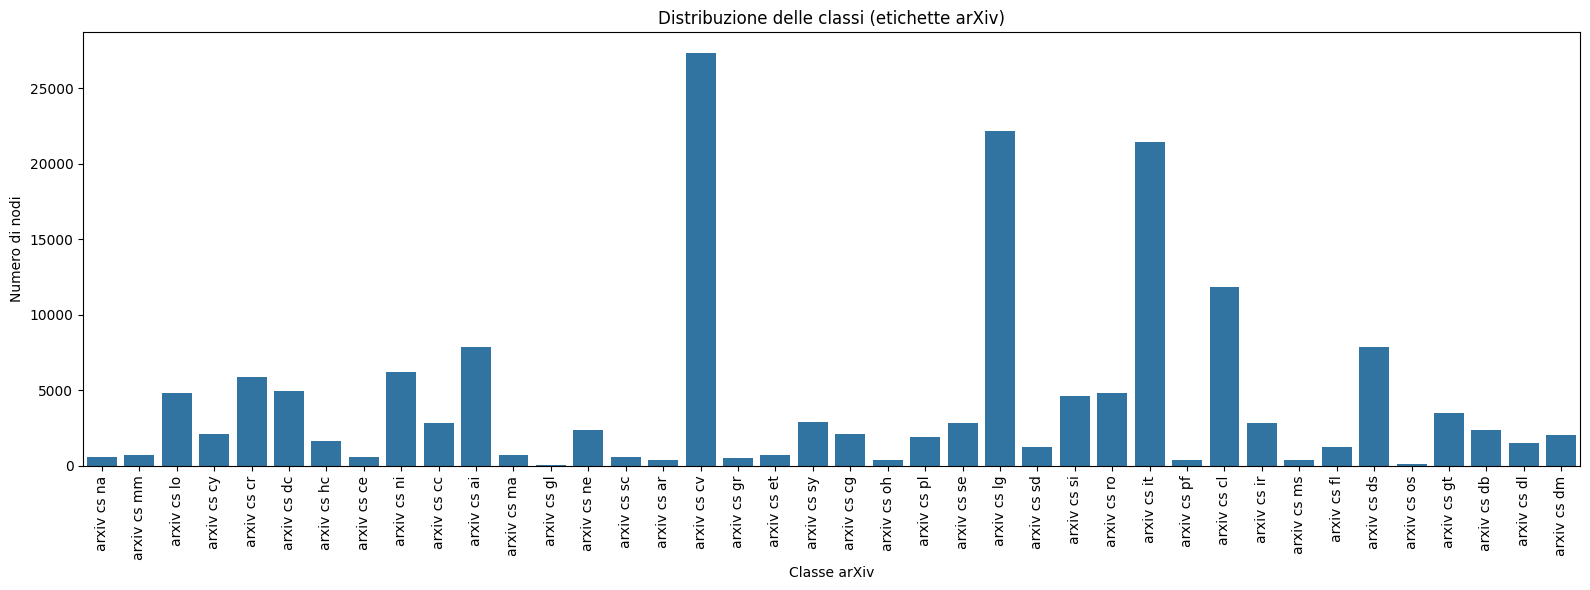

In [23]:
from rich.console import Console
from rich.table import Table
from rich import box

# Calcola distribuzione
y = data.y.view(-1).numpy()
counts = pd.Series(y).value_counts().sort_index()

# === RICH: Tabella colorata
console = Console()
table = Table(title="📊 Distribuzione delle Classi ArXiv", box=box.SQUARE)

table.add_column("Classe", justify="center", style="cyan", no_wrap=True)
table.add_column("Nome", justify="left", style="green")
table.add_column("Numero Articoli", justify="right", style="magenta")

for i, count in enumerate(counts):
    table.add_row(f"{i:2d}", class_names[i], str(count))

console.print(table)


plt.figure(figsize=(16, 6))
sns.barplot(x=class_names, y=counts.values)
plt.title("Distribuzione delle classi (etichette arXiv)")
plt.xlabel("Classe arXiv")
plt.ylabel("Numero di nodi")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("label_distribution_named.png")
plt.show()


In [24]:
split_idx = dataset.get_idx_split()
for split in ["train", "valid", "test"]:
    idx = split_idx[split]
    print(f"{split.capitalize()} set: {len(idx)} nodi ({len(idx) / data.num_nodes:.2%})")


Train set: 90941 nodi (53.70%)
Valid set: 29799 nodi (17.60%)
Test set: 48603 nodi (28.70%)


🕒 Anni min/max: 1971 - 2020


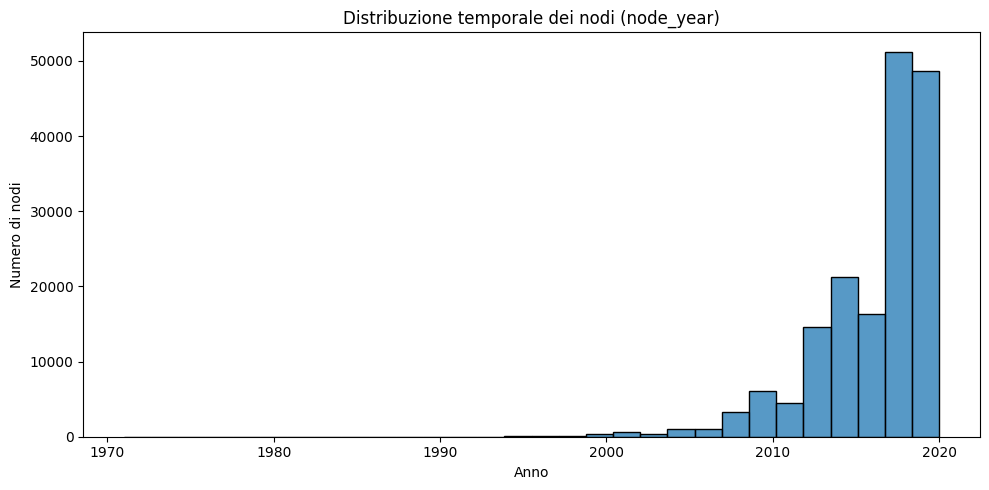

In [25]:
node_year = data.node_year.view(-1).numpy()
print("🕒 Anni min/max:", node_year.min(), "-", node_year.max())

plt.figure(figsize=(10, 5))
sns.histplot(node_year, bins=30)
plt.title("Distribuzione temporale dei nodi (node_year)")
plt.xlabel("Anno")
plt.ylabel("Numero di nodi")
plt.tight_layout()
plt.savefig("year_distribution.png")
plt.show()


## Distribuzione del grado dei nodi nel grafo

Per analizzare la struttura topologica del grafo, abbiamo calcolato la distribuzione del **grado di ingresso (in-degree)** per ciascun nodo. Il grado di un nodo rappresenta il numero di archi entranti, ovvero quante volte un nodo viene citato da altri (nel contesto di ogbn-arxiv: quanti articoli citano un certo paper).

L'istogramma risultante mostra la frequenza dei diversi gradi su scala logaritmica, evidenziando la tipica **distribuzione long-tail** dei grafi reali: pochi nodi con grado molto elevato (hub) e molti nodi con grado basso.

Questa informazione è utile per comprendere:
- la presenza di nodi centrali (hub),
- la connettività generale del grafo,
- la distribuzione di potere informativo tra i nodi,
- e potenziali implicazioni sulla performance delle GNN (che sono sensibili alla topologia locale).

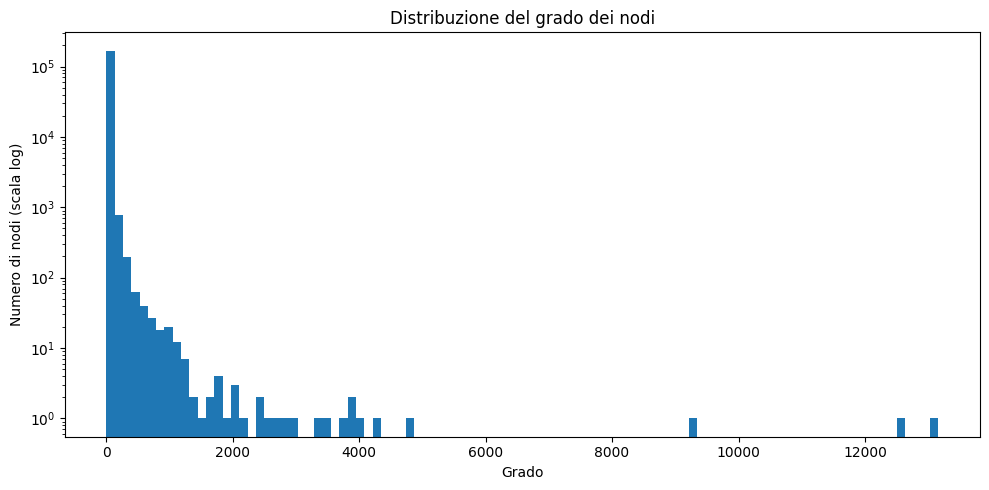

In [26]:
edge_index = data.edge_index.numpy()
dst = edge_index[1]
degree = np.bincount(dst, minlength=data.num_nodes)

plt.figure(figsize=(10, 5))
plt.hist(degree, bins=100, log=True)
plt.title("Distribuzione del grado dei nodi")
plt.xlabel("Grado")
plt.ylabel("Numero di nodi (scala log)")
plt.tight_layout()
plt.savefig("degree_distribution.png")
plt.show()


C:\Users\paolo\AppData\Local\Temp\ipykernel_97196\3117101798.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette="tab20")


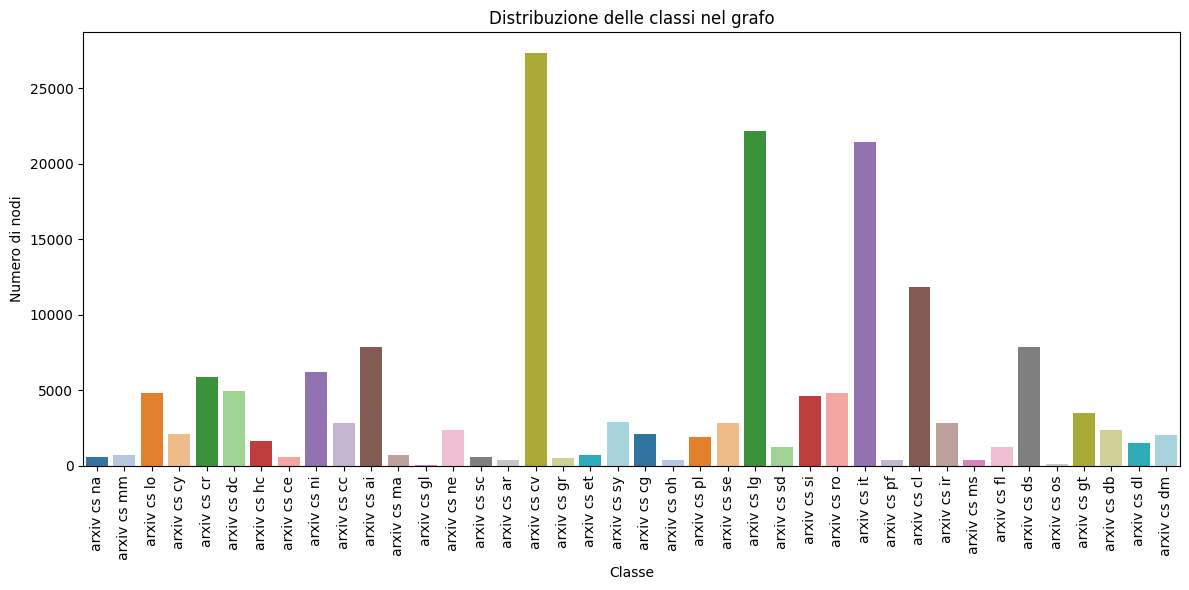

In [27]:
def visualizza_sottografo_khop(data, nodo_centrale=0, k=2, class_names=None):
    import networkx as nx
    from torch_geometric.utils import to_networkx, k_hop_subgraph
    import matplotlib.patches as mpatches

    print(f"📷 Generazione sottografo {k}-hop dal nodo {nodo_centrale}...")

    # Estrazione del sottografo
    nodi_sub, edge_index_sub, _, _ = k_hop_subgraph(
        node_idx=nodo_centrale,
        num_hops=k,
        edge_index=data.edge_index,
        relabel_nodes=True
    )

    # Limite massimo per evitare grafi illeggibili
    if nodi_sub.shape[0] > 300:
        print(f"⚠️ Sottografo troppo grande ({nodi_sub.shape[0]} nodi). Visualizzazione saltata.")
        return

    # Prepara sottografo
    sub_data = data.clone()
    sub_data.edge_index = edge_index_sub
    sub_data.num_nodes = nodi_sub.shape[0]
    y_sub = data.y[nodi_sub].view(-1).tolist()

    # Palette colori
    palette = sns.color_palette("tab20", 40)
    unique_labels = sorted(set(y_sub))
    colori_nodi = [palette[label % len(palette)] for label in y_sub]

    # Costruzione legenda
    legend_handles = []
    if class_names and len(unique_labels) <= 15:
        for label in unique_labels:
            nome = class_names[label]
            patch = mpatches.Patch(color=palette[label % len(palette)], label=nome)
            legend_handles.append(patch)

    # Costruzione grafo e posizione nodi
    G = to_networkx(sub_data, to_undirected=True)
    pos = nx.kamada_kawai_layout(G)

    # Plot
    plt.figure(figsize=(9, 9))
    nx.draw(
        G, pos,
        node_color=colori_nodi,
        node_size=40,
        edge_color="gray",
        alpha=0.75
    )
    plt.title(f"Sottografo {k}-hop dal nodo {nodo_centrale} (colori per classe)")
    plt.axis("off")

    if legend_handles:
        plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)

    plt.tight_layout()
    plt.savefig("subgraph_khop_colored.png", bbox_inches="tight")
    plt.show()



Script di node exploration in senso letterale, in quanto grazie alla libreria ipywidgest siamo in gardo di esplorare fisicamente la struttura del dataset


In [28]:
from ipywidgets import interact, IntSlider, Dropdown
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def esplora_grafo_interattivo(data, class_names=None, max_nodi=500):
    import networkx as nx
    from torch_geometric.utils import to_networkx, k_hop_subgraph
    import matplotlib.patches as mpatches

    def visualizza(nodo_centrale, k):
        print(f"🔍 Generazione sottografo {k}-hop dal nodo {nodo_centrale}...")

        nodi_sub, edge_index_sub, _, _ = k_hop_subgraph(
            node_idx=nodo_centrale,
            num_hops=k,
            edge_index=data.edge_index,
            relabel_nodes=True
        )

        if nodi_sub.shape[0] > max_nodi:
            print(f"⚠️ Sottografo troppo grande ({nodi_sub.shape[0]} nodi). Visualizzazione saltata.")
            return

        sub_data = data.clone()
        sub_data.edge_index = edge_index_sub
        sub_data.num_nodes = nodi_sub.shape[0]
        y_sub = data.y[nodi_sub].view(-1).tolist()

        palette = sns.color_palette("tab20", 40)
        unique_labels = sorted(set(y_sub))
        colori_nodi = [palette[label % len(palette)] for label in y_sub]

        legend_handles = []
        if class_names and len(unique_labels) <= 15:
            for label in unique_labels:
                nome = class_names[label]
                patch = mpatches.Patch(color=palette[label % len(palette)], label=nome)
                legend_handles.append(patch)

        G = to_networkx(sub_data, to_undirected=True)
        pos = nx.kamada_kawai_layout(G)

        plt.figure(figsize=(8, 8))
        nx.draw(
            G, pos,
            node_color=colori_nodi,
            node_size=40,
            edge_color="gray",
            alpha=0.75
        )
        plt.title(f"Sottografo {k}-hop dal nodo {nodo_centrale}")
        plt.axis("off")

        if legend_handles:
            plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)

        plt.tight_layout()
        plt.show()

    # Widget interattivi
    max_node_id = data.num_nodes - 1
    interact(
        visualizza,
        nodo_centrale=IntSlider(min=0, max=max_node_id, step=1, value=0, description="Nodo"),
        k=IntSlider(min=1, max=5, step=1, value=2, description="K-hop")
    )


In [29]:
esplora_grafo_interattivo(data, class_names=class_names)


interactive(children=(IntSlider(value=0, description='Nodo', max=169342), IntSlider(value=2, description='K-ho…

In [15]:
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def esplora_grafo_interattivo_migliorato(data, class_names=None, max_nodi=500):
    import networkx as nx
    from torch_geometric.utils import to_networkx, k_hop_subgraph
    import matplotlib.patches as mpatches

    def visualizza(nodo_centrale, k, mostra_etichette):
        print(f"🔍 Generazione sottografo {k}-hop dal nodo {nodo_centrale}...")

        nodi_sub, edge_index_sub, _, _ = k_hop_subgraph(
            node_idx=nodo_centrale,
            num_hops=k,
            edge_index=data.edge_index,
            relabel_nodes=True
        )

        if nodi_sub.shape[0] > max_nodi:
            print(f"⚠️ Sottografo troppo grande ({nodi_sub.shape[0]} nodi). Visualizzazione saltata.")
            return

        sub_data = data.clone()
        sub_data.edge_index = edge_index_sub
        sub_data.num_nodes = nodi_sub.shape[0]
        y_sub = data.y[nodi_sub].view(-1).tolist()

        palette = sns.color_palette("Set2", max(y_sub)+1)
        unique_labels = sorted(set(y_sub))
        colori_nodi = [palette[label % len(palette)] for label in y_sub]

        legend_handles = []
        if class_names and len(unique_labels) <= 15:
            for label in unique_labels:
                nome = class_names[label]
                patch = mpatches.Patch(color=palette[label % len(palette)], label=nome)
                legend_handles.append(patch)

        G = to_networkx(sub_data, to_undirected=True)
        pos = nx.spring_layout(G, seed=42) if len(G.nodes) < 50 else nx.kamada_kawai_layout(G)

        plt.figure(figsize=(9, 9))
        nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color="gray")
        nx.draw_networkx_nodes(G, pos, node_color=colori_nodi, node_size=70, alpha=0.9)
        # Evidenzia il nodo centrale
        central_pos = pos[0]
        nx.draw_networkx_nodes(G, pos, nodelist=[0], node_size=200, node_color="red", alpha=0.6)


        if mostra_etichette and len(G.nodes) <= 30:
            labels = {i: str(i) for i in G.nodes}
            nx.draw_networkx_labels(G, pos, labels, font_size=8)

        plt.title(f"Sottografo {k}-hop dal nodo {nodo_centrale}", fontsize=14)
        plt.axis("off")

        if legend_handles:
            plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)

        plt.tight_layout()
        plt.show()

    # Interfaccia interattiva
    interact(
        visualizza,
        nodo_centrale=IntSlider(min=0, max=data.num_nodes - 1, step=1, value=0, description="Nodo"),
        k=IntSlider(min=1, max=5, step=1, value=2, description="K-hop"),
        mostra_etichette=Dropdown(options=[False, True], value=False, description="Etichette")
    )


In [16]:
esplora_grafo_interattivo_migliorato(data, class_names=class_names)


interactive(children=(IntSlider(value=0, description='Nodo', max=169342), IntSlider(value=2, description='K-ho…

Qua vediamo i paper piu citati, possiamo notare la popolarità di topic su ml e visione artificiale (Computer Vision)

## Analisi dei paper più citati nel grafo OGBN-Arxiv

In questo blocco, analizziamo la struttura del grafo del dataset **OGBN-Arxiv** individuando i **10 articoli più citati**. L’obiettivo è identificare i nodi con il più alto **in-degree**, cioè il numero di citazioni ricevute da altri nodi (articoli).

### Passaggi principali:

1. **Caricamento del dataset OGBN-Arxiv** come grafo orientato (citazioni direzionali tra articoli).
2. **Calcolo dell’in-degree** per ogni nodo del grafo, ovvero il numero di citazioni ricevute.
3. **Selezione dei 10 nodi con in-degree più alto**, mappando ciascun nodo:
   - al rispettivo identificativo MAG (Microsoft Academic Graph),
   - al titolo reale del paper,
   - alla categoria arXiv associata (tradotta in forma leggibile).
4. **Visualizzazione tabellare** dei risultati con la libreria `rich` per una resa elegante.
5. **Esportazione CSV** dei top 10 paper con i relativi metadati (`top_mag_ids.csv`), utile per ulteriori analisi (es. interrogazioni OpenAlex, analisi semantica, ecc.)

In [17]:
import pandas as pd
import networkx as nx
from torch_geometric.utils import to_networkx
from ogb.nodeproppred import PygNodePropPredDataset
from rich.console import Console
from rich.table import Table
from rich import box

# === 1. Caricamento dataset e metadati ===
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv')
data = dataset[0]

df_titles = (
    pd.read_csv("dataset/titleabs.tsv", sep="\t", names=["paper_id", "title", "abstract"])
    .astype({"paper_id": str})
    .drop_duplicates("paper_id")
    .set_index("paper_id")
)

# === 2. Mapping OGBN index → MAG ID ===
mapping_path = "dataset/ogbn-arxiv/ogbn_arxiv/mapping/nodeidx2paperid.csv.gz"
df_mapping = pd.read_csv(mapping_path, header=None, names=["MAG_ID"])
ogbn_to_mag = df_mapping["MAG_ID"].astype(str).tolist()

# === 3. Mapping label → categoria arXiv ===
def load_label_mapping(path):
    import gzip, csv
    label_to_category = {}
    with gzip.open(path, 'rt') as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            label_to_category[int(row[0])] = row[1]
    return label_to_category

label_path = 'dataset/ogbn-arxiv/ogbn_arxiv/mapping/labelidx2arxivcategeory.csv.gz'
label_to_category = load_label_mapping(label_path)
class_names = [label_to_category[i] for i in range(len(label_to_category))]

arxiv_nomi_umani = {
    "arxiv cs ai": "Intelligenza Artificiale",
    "arxiv cs ar": "Architettura Hardware",
    "arxiv cs cc": "Teoria della Computazione",
    "arxiv cs ce": "Ingegneria Informatica",
    "arxiv cs cg": "Grafica Computazionale",
    "arxiv cs cl": "Elaborazione Linguaggio",
    "arxiv cs cr": "Sicurezza Informatica",
    "arxiv cs cv": "Visione Artificiale",
    "arxiv cs cy": "Cybersecurity",
    "arxiv cs db": "Basi di Dati",
    "arxiv cs dc": "Computazione Distribuita",
    "arxiv cs dl": "Deep Learning",
    "arxiv cs dm": "Data Mining",
    "arxiv cs ds": "Algoritmi e Strutture Dati",
    "arxiv cs et": "Informatica Teorica",
    "arxiv cs fl": "Logica Formale",
    "arxiv cs gl": "Letteratura Generale ",
    "arxiv cs gr": "Teoria dei Grafi",
    "arxiv cs gt": "Teoria dei Giochi",
    "arxiv cs hc": "Interazione Uomo-Macchina",
    "arxiv cs ir": "Recupero dell’Informazione",
    "arxiv cs it": "Teoria dell’Informazione",
    "arxiv cs lg": "Machine Learning",
    "arxiv cs lo": "Logica Computazionale",
    "arxiv cs ma": "Agenti e Multiagenti",
    "arxiv cs mm": "Multimedia",
    "arxiv cs ms": "Software Matematico",
    "arxiv cs na": "Analisi Numerica",
    "arxiv cs ne": "Reti Neurali",
    "arxiv cs ni": "Reti Informatiche",
    "arxiv cs oh": "Hardware Open",
    "arxiv cs os": "Sistemi Operativi",
    "arxiv cs pf": "Formal Proofs",
    "arxiv cs pl": "Linguaggi di Programmazione",
    "arxiv cs ro": "Robotica",
    "arxiv cs sc": "Simulazioni",
    "arxiv cs sd": "Sistemi Distribuiti",
    "arxiv cs se": "Ingegneria del Software",
    "arxiv cs si": "Segnali e Sistemi",
    "arxiv cs sy": "Sistemi Dinamici"
}

def get_categoria(label_idx):
    codice_categoria = class_names[label_idx]
    return arxiv_nomi_umani.get(codice_categoria, codice_categoria)

# === 4. Calcolo In-Degree e selezione top paper ===
G = to_networkx(data, to_undirected=False)
in_degrees = dict(G.in_degree())
top_10 = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:10]

top_rows = []
for ogbn_id, indeg in top_10:
    mag_id = ogbn_to_mag[ogbn_id]
    label_idx = int(data.y[ogbn_id])
    categoria = get_categoria(label_idx)

    try:
        title = df_titles.loc[mag_id]["title"]
    except KeyError:
        title = "[Titolo non trovato]"

    top_rows.append({
        "OGBN ID": ogbn_id,
        "MAG ID": mag_id,
        "In-Degree": indeg,
        "Categoria": categoria,
        "Titolo": title
    })

# === 5. Visualizzazione elegante con Rich ===
console = Console()
table = Table(
    title="📚 Top 10 Paper per In-Degree su OGBN-Arxiv",
    box=box.SQUARE_DOUBLE_HEAD,
    show_lines=True
)

table.add_column("OGBN ID", justify="center", style="cyan")
table.add_column("MAG ID", justify="center", style="bright_black")
table.add_column("Citazioni", justify="right", style="magenta")
table.add_column("Categoria", style="green")
table.add_column("Titolo", style="yellow")

for row in top_rows:
    titolo = row["Titolo"].title()
    titolo_troncato = titolo[:80] + ("..." if len(titolo) > 80 else "")
    table.add_row(
        str(row["OGBN ID"]),
        row["MAG ID"],
        str(row["In-Degree"]),
        row["Categoria"],
        titolo_troncato
    )

console.print(table)

# === 6. Salvataggio CSV per utilizzo futuro ===
df_export = pd.DataFrame(top_rows)[["MAG ID", "Titolo", "In-Degree", "Categoria"]]
df_export.to_csv("top_mag_ids.csv", index=False)
print("✅ File salvato: top_mag_ids.csv")


                                    📚 Top 10 Paper per In-Degree su OGBN-Arxiv                                    
┌─────────┬────────────┬───────────┬─────────────────────────┬────────────────────────────────────────────────────┐
│ OGBN ID │   MAG ID   │ Citazioni │ Categoria               │ Titolo                                             │
╞═════════╪════════════╪═══════════╪═════════════════════════╪════════════════════════════════════════════════════╡
│  1353   │ 1519399059 │     13155 │ Machine Learning        │ A Maximum Entropy Theorem With Applications To The │
│         │            │           │                         │ Measurement Of Biodiversity                        │
├─────────┼────────────┼───────────┼─────────────────────────┼────────────────────────────────────────────────────┤
│  67166  │ 2949649109 │     12527 │ Visione Artificiale     │ Automatic Assessment Of Full Left Ventricular      │
│         │            │           │                         │ Coverage In Cardiac Cine Magnetic ...              │
├─────────┼────────────┼───────────┼─────────────────────────┼────────────────────────────────────────────────────┤
│  25208  │ 1682151956 │      9244 │ Visione Artificiale     │ Actors Vs Shared Memory Two Models At Work On Big  │
│         │            │           │                         │ Data Application Frameworks                        │
├─────────┼────────────┼───────────┼─────────────────────────┼────────────────────────────────────────────────────┤
│  69794  │ 2949110617 │      4779 │ Machine Learning        │ Parallel Exhaustive Search Without Coordination    │
├─────────┼────────────┼───────────┼─────────────────────────┼────────────────────────────────────────────────────┤
│  93649  │ 2952020069 │      4238 │ Visione Artificiale     │ Activity Dynamics In Collaboration Networks        │
├─────────┼────────────┼───────────┼─────────────────────────┼────────────────────────────────────────────────────┤
│ 115359  │ 2131297149 │      4033 │ Elaborazione Linguaggio │ Hybrid Xml Retrieval Combining Information         │
│         │            │           │                         │ Retrieval And A Native Xml Database                │
├─────────┼────────────┼───────────┼─────────────────────────┼────────────────────────────────────────────────────┤
│  22035  │ 2950157671 │      3861 │ Visione Artificiale     │ Sensitivity Analysis Of Minimum Spanning Trees In  │
│         │            │           │                         │ Sub Inverse Ackermann Time                         │
├─────────┼────────────┼───────────┼─────────────────────────┼────────────────────────────────────────────────────┤
│ 133376  │ 2953083211 │      3844 │ Visione Artificiale     │ Joint Optimization And Variable Selection Of High  │
│         │            │           │                         │ Dimensional Gaussian Processes                     │
├─────────┼────────────┼───────────┼─────────────────────────┼────────────────────────────────────────────────────┤
│ 106699  │ 2950133701 │      3737 │ Elaborazione Linguaggio │ Practical Algorithms For Finding Extremal Sets     │
├─────────┼────────────┼───────────┼─────────────────────────┼────────────────────────────────────────────────────┤
│ 166425  │ 2952624498 │      3407 │ Visione Artificiale     │ Identifiers In Registers Describing Network        │
│         │            │           │                         │ Algorithms With Logic                              │
└─────────┴────────────┴───────────┴─────────────────────────┴────────────────────────────────────────────────────┘

✅ File salvato: top_mag_ids.csv


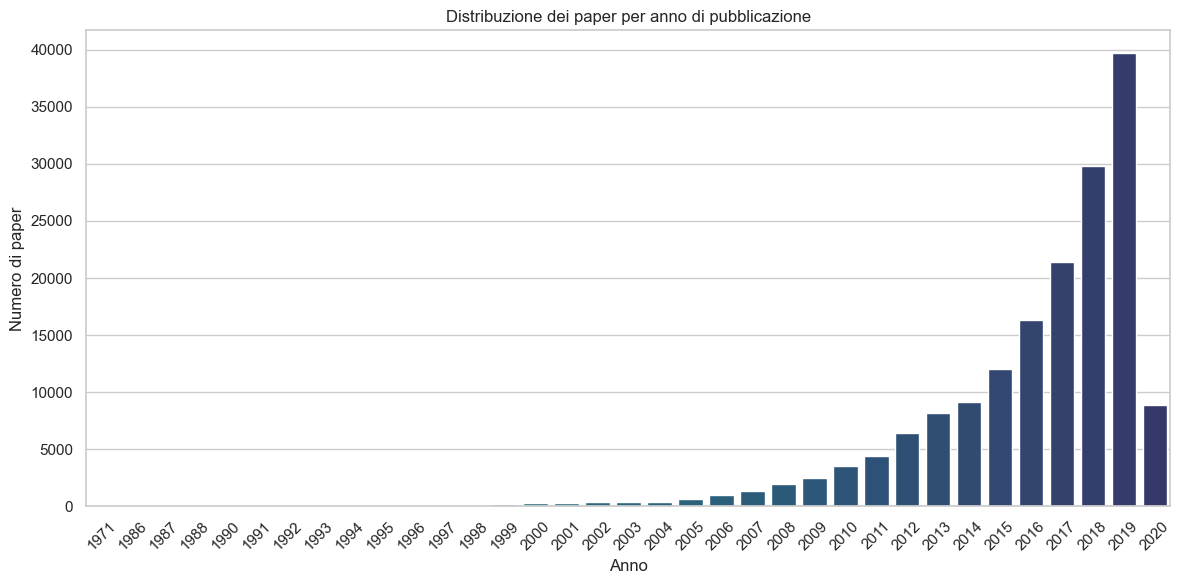

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estrai gli anni
years = data.node_year.squeeze().tolist()
df_years = pd.DataFrame({"Anno": years})

# Plot
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.countplot(data=df_years, x="Anno", hue="Anno", palette="crest", legend=False)

plt.title("Distribuzione dei paper per anno di pubblicazione")
plt.ylabel("Numero di paper")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [16]:
import pandas as pd
import networkx as nx
from torch_geometric.utils import to_networkx
from rich.console import Console
from rich.table import Table
from rich import box

# === 1. Costruisci grafo e calcola in-degree
G = to_networkx(data, to_undirected=False)
in_degrees = dict(G.in_degree())

# === 2. Estrai anno di pubblicazione per ogni nodo
years = data.node_year.squeeze().tolist()
year_dict = {i: years[i] for i in range(len(years))}

# === 3. Trova il paper più citato per ogni anno
top_by_year = {}
for node_id, year in year_dict.items():
    indeg = in_degrees.get(node_id, 0)
    if year not in top_by_year or indeg > top_by_year[year]["in_degree"]:
        top_by_year[year] = {"node_id": node_id, "in_degree": indeg}

# === 4. Costruisci la lista dei top paper
top_rows = []
for year, info in sorted(top_by_year.items()):
    node_id = info["node_id"]
    indeg = info["in_degree"]
    mag_id = ogbn_to_mag[node_id]
    label_idx = int(data.y[node_id].item())
    label = class_names[label_idx]
    categoria = arxiv_nomi_umani.get(label, label)

    row = df_titles[df_titles["paper_id"] == mag_id]
    title = row.iloc[0]["title"] if not row.empty else "[Titolo non trovato]"

    top_rows.append({
        "Anno": year,
        "Citazioni": indeg,
        "Categoria": categoria,
        "Titolo": title,
        "MAG ID": mag_id  # 👈 AGGIUNTO QUI
    })

# === 5. Visualizzazione con Rich
console = Console()
table = Table(title="📚 Top Paper per Anno", box=box.SQUARE)
table.add_column("Anno", justify="center", style="cyan")
table.add_column("Citazioni", justify="center", style="magenta")
table.add_column("Categoria", style="green")
table.add_column("Titolo", style="yellow")

for row in top_rows:
    titolo = row["Titolo"][:80] + ("..." if len(row["Titolo"]) > 80 else "")
    table.add_row(str(row["Anno"]), str(row["Citazioni"]), row["Categoria"], titolo)

console.print(table)

# === 6. Salva MAG ID e Titolo per query future (OpenAlex ecc.)
df_export = pd.DataFrame(top_rows)[["MAG ID", "Titolo"]]
df_export.to_csv("top_mag_ids.csv", index=False)
print("✅ File salvato: top_mag_ids.csv")


                                               📚 Top Paper per Anno                                               
┌──────┬───────────┬─────────────────────────────┬────────────────────────────────────────────────────────────────┐
│ Anno │ Citazioni │ Categoria                   │ Titolo                                                         │
├──────┼───────────┼─────────────────────────────┼────────────────────────────────────────────────────────────────┤
│ 1971 │    178    │ Segnali e Sistemi           │ writing on dirty flash memory                                  │
│ 1986 │     4     │ Reti Informatiche           │ emotion recognition from speech based on relevant feature and  │
│      │           │                             │ majority voting                                                │
│ 1987 │     3     │ Logica Computazionale       │ provable methods for training neural networks with sparse      │
│      │           │                             │ connectivity                                                   │
│ 1988 │     3     │ Simulazioni                 │ a stochastic temporal model of polyphonic midi performance     │
│      │           │                             │ with ornaments                                                 │
│ 1990 │    124    │ Intelligenza Artificiale    │ checks and controls in spreadsheets                            │
│ 1991 │    45     │ Algoritmi e Strutture Dati  │ google matrix dynamical attractors and ulam networks           │
│ 1992 │    24     │ Algoritmi e Strutture Dati  │ does a plane imitate a bird does computer vision have to       │
│      │           │                             │ follow biological parad...                                     │
│ 1993 │    15     │ Intelligenza Artificiale    │ an approximation algorithm for a shortest dubins path problem  │
│ 1994 │    86     │ Intelligenza Artificiale    │ enhanced blind decoding of tardos codes with new map based     │
│      │           │                             │ functions                                                      │
│ 1995 │    54     │ Linguaggi di Programmazione │ the complexity of free flood it on 2ixn boards                 │
│ 1996 │    331    │ Intelligenza Artificiale    │ predicting tongue motion in unlabeled ultrasound videos using  │
│      │           │                             │ convolutional lstm...                                          │
│ 1997 │    28     │ Intelligenza Artificiale    │ a linear memory algorithm for baum welch training              │
│ 1998 │    169    │ Machine Learning            │ a betweenness structure entropy of complex networks            │
│ 1999 │    154    │ Machine Learning            │ accurate and efficient private release of datacubes and        │
│      │           │                             │ contingency tables                                             │
│ 2000 │    111    │ Intelligenza Artificiale    │ learning contour fragment based shape model with and or tree   │
│      │           │                             │ representation                                                 │
│ 2001 │    106    │ Algoritmi e Strutture Dati  │ rock climber distance frogs versus dogs                        │
│ 2002 │    342    │ Intelligenza Artificiale    │ on the robustness of temporal properties for stochastic models │
│ 2003 │    211    │ Elaborazione Linguaggio     │ object oriented program comprehension effect of expertise task │
│      │           │                             │ and phase                                                      │
│ 2004 │    226    │ Teoria dell’Informazione    │ a fully convolutional neural network based structured          │
│      │           │                             │ prediction approach toward...                                  │
│ 2005 │    214    │ Elaborazione Linguaggio     │ hiring under uncertainty                                       │
│ 2006 │    208    │ Teoria dell’Informazione    │ multi 

✅ File salvato: top_mag_ids.csv


C:\Users\paolo\AppData\Local\Temp\ipykernel_480\1450844364.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top["Conteggio_log"] = np.log1p(df_top["Conteggio"])  # log(1 + x)


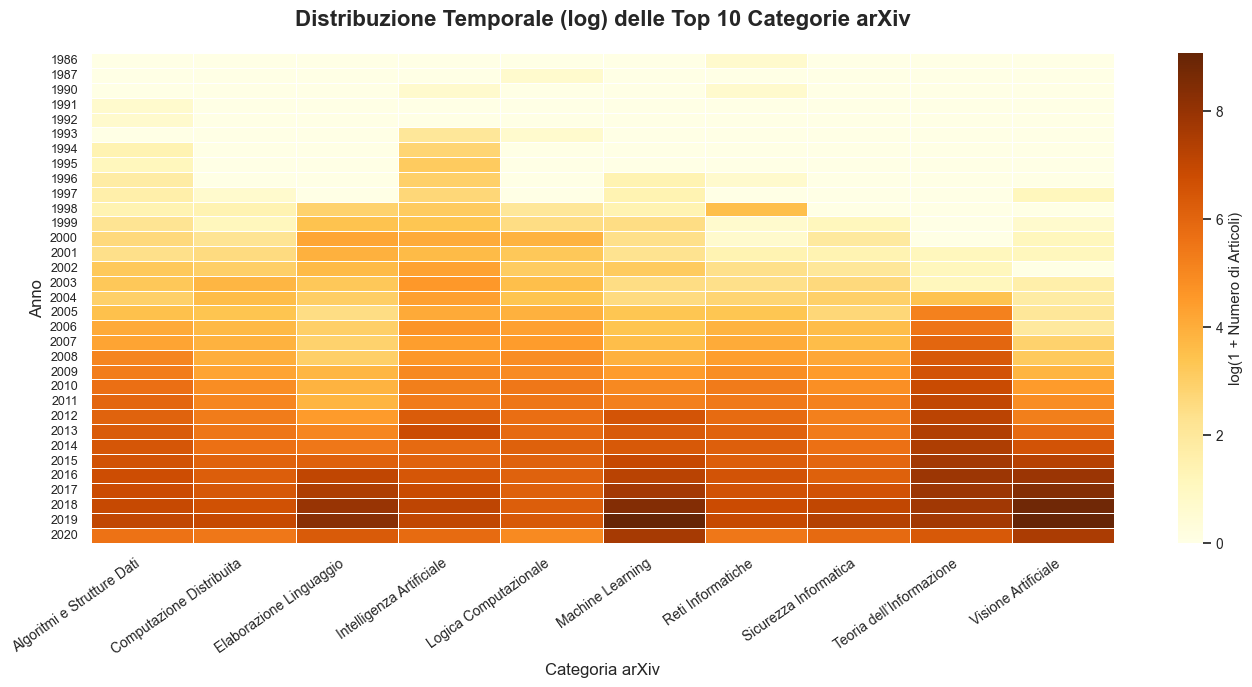

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Costruzione come prima
labels = data.y.view(-1).tolist()
years = data.node_year.view(-1).tolist()

df_nodes = pd.DataFrame({
    "Anno": years,
    "Codice": [class_names[int(l)] for l in labels]
})
df_nodes["Categoria"] = df_nodes["Codice"].map(arxiv_nomi_umani)

df_counts = df_nodes.groupby(["Anno", "Categoria"]).size().reset_index(name="Conteggio")
top10 = df_nodes["Categoria"].value_counts().nlargest(10).index.tolist()
df_top = df_counts[df_counts["Categoria"].isin(top10)]

# === Applica log trasformazione (per maggiore leggibilità)
df_top["Conteggio_log"] = np.log1p(df_top["Conteggio"])  # log(1 + x)

# === Pivot per heatmap
pivot_table = df_top.pivot(index="Anno", columns="Categoria", values="Conteggio_log").fillna(0)

# === Heatmap curata con scala logaritmica
plt.figure(figsize=(14, 7))
sns.set(font_scale=0.9)

ax = sns.heatmap(
    pivot_table,
    cmap="YlOrBr",
    linewidths=0.4,
    linecolor="white",
    cbar_kws={"label": "log(1 + Numero di Articoli)"}
)

plt.title("Distribuzione Temporale (log) delle Top 10 Categorie arXiv", fontsize=16, weight="bold", pad=20)
plt.ylabel("Anno", fontsize=12)
plt.xlabel("Categoria arXiv", fontsize=12)
plt.xticks(rotation=35, ha='right', fontsize=10)
plt.yticks(fontsize=9)

plt.tight_layout()
plt.show()


In [18]:
from collections import Counter
import pandas as pd
import string
from rich.console import Console
from rich.table import Table
from wordcloud import STOPWORDS

# === 1. Prepara stopwords personalizzate ===
stopwords = set(STOPWORDS)
stopwords.update({"using", "based", "approach", "via", "new", "method", "model", "analysis", "learning", "results", "paper"})

# === 2. Funzione per conteggio parole ===
def conta_parole(series, stopwords, top_n=30):
    all_text = " ".join(series.fillna("").astype(str)).lower()
    all_text = all_text.translate(str.maketrans('', '', string.punctuation))
    words = all_text.split()
    filtered = [w for w in words if w not in stopwords and len(w) > 2]
    counter = Counter(filtered)
    return counter.most_common(top_n)

# === 3. Funzione per stampa tabella ===
def stampa_rich_tabella(freq_list, titolo):
    console = Console()
    table = Table(title=titolo, show_lines=True)
    table.add_column("🔤 Parola", style="bold cyan")
    table.add_column("📊 Frequenza", justify="right", style="bold magenta")

    for word, count in freq_list:
        table.add_row(word, str(count))
    
    console.print(table)

# === 4. Applica alle colonne 'title' e 'abstract'
freq_titoli = conta_parole(df_titles["title"], stopwords, top_n=30)
freq_abstract = conta_parole(df_titles["abstract"], stopwords, top_n=30)

# === 5. Visualizza con Rich
stampa_rich_tabella(freq_titoli, "📘 Top 30 Parole nei Titoli")
stampa_rich_tabella(freq_abstract, "📙 Top 30 Parole negli Abstract")


   📘 Top 30 Parole nei Titoli   
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ 🔤 Parola      ┃ 📊 Frequenza ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ networks       │        17190 │
├────────────────┼──────────────┤
│ deep           │        10268 │
├────────────────┼──────────────┤
│ neural         │         9931 │
├────────────────┼──────────────┤
│ network        │         9007 │
├────────────────┼──────────────┤
│ data           │         8268 │
├────────────────┼──────────────┤
│ multi          │         7777 │
├────────────────┼──────────────┤
│ systems        │         6811 │
├────────────────┼──────────────┤
│ detection      │         6102 │
├────────────────┼──────────────┤
│ image          │         5205 │
├────────────────┼──────────────┤
│ time           │         5089 │
├────────────────┼──────────────┤
│ efficient      │         4480 │
├────────────────┼──────────────┤
│ information    │         4379 │
├────────────────┼──────────────┤
│ models         │         4143 │
├────────────────┼──────────────┤
│ graph          │         3946 │
├────────────────┼──────────────┤
│ classification │         3774 │
├────────────────┼──────────────┤
│ distributed    │         3707 │
├────────────────┼──────────────┤
│ recognition    │         3615 │
├────────────────┼──────────────┤
│ algorithm      │         3614 │
├────────────────┼──────────────┤
│ codes          │         3595 │
├────────────────┼──────────────┤
│ convolutional  │         3563 │
├────────────────┼──────────────┤
│ optimal        │         3562 │
├────────────────┼──────────────┤
│ algorithms     │         3449 │
├────────────────┼──────────────┤
│ estimation     │         3405 │
├────────────────┼──────────────┤
│ optimization   │         3340 │
├────────────────┼──────────────┤
│ graphs         │         3270 │
├────────────────┼──────────────┤
│ linear         │         3247 │
├────────────────┼──────────────┤
│ machine        │         3209 │
├────────────────┼──────────────┤
│ system         │         3183 │
├────────────────┼──────────────┤
│ control        │         3134 │
├────────────────┼──────────────┤
│ wireless       │         3063 │
└────────────────┴──────────────┘

    📙 Top 30 Parole negli    
           Abstract           
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ 🔤 Parola   ┃ 📊 Frequenza ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ data        │       108406 │
├─────────────┼──────────────┤
│ problem     │        85448 │
├─────────────┼──────────────┤
│ network     │        81790 │
├─────────────┼──────────────┤
│ show        │        79921 │
├─────────────┼──────────────┤
│ algorithm   │        74175 │
├─────────────┼──────────────┤
│ proposed    │        67468 │
├─────────────┼──────────────┤
│ performance │        65374 │
├─────────────┼──────────────┤
│ networks    │        58361 │
├─────────────┼──────────────┤
│ information │        56781 │
├─────────────┼──────────────┤
│ propose     │        55714 │
├─────────────┼──────────────┤
│ two         │        55389 │
├─────────────┼──────────────┤
│ time        │        53949 │
├─────────────┼──────────────┤
│ models      │        53512 │
├─────────────┼──────────────┤
│ system      │        50672 │
├─────────────┼──────────────┤
│ methods     │        49086 │
├─────────────┼──────────────┤
│ different   │        47571 │
├─────────────┼──────────────┤
│ algorithms  │        46634 │
├─────────────┼──────────────┤
│ number      │        46236 │
├─────────────┼──────────────┤
│ used        │        44899 │
├─────────────┼──────────────┤
│ systems     │        44080 │
├─────────────┼──────────────┤
│ one         │        42647 │
├─────────────┼──────────────┤
│ neural      │        39941 │
├─────────────┼──────────────┤
│ work        │        39586 │
├─────────────┼──────────────┤
│ use         │        39437 │
├─────────────┼──────────────┤
│ present     │        39234 │
├─────────────┼──────────────┤
│ set         │        38919 │
├─────────────┼──────────────┤
│ first       │        36782 │
├─────────────┼──────────────┤
│ image       │        36224 │
├─────────────┼──────────────┤
│ framework   │        36196 │
├─────────────┼──────────────┤
│ training    │        35615 │
└─────────────┴──────────────┘

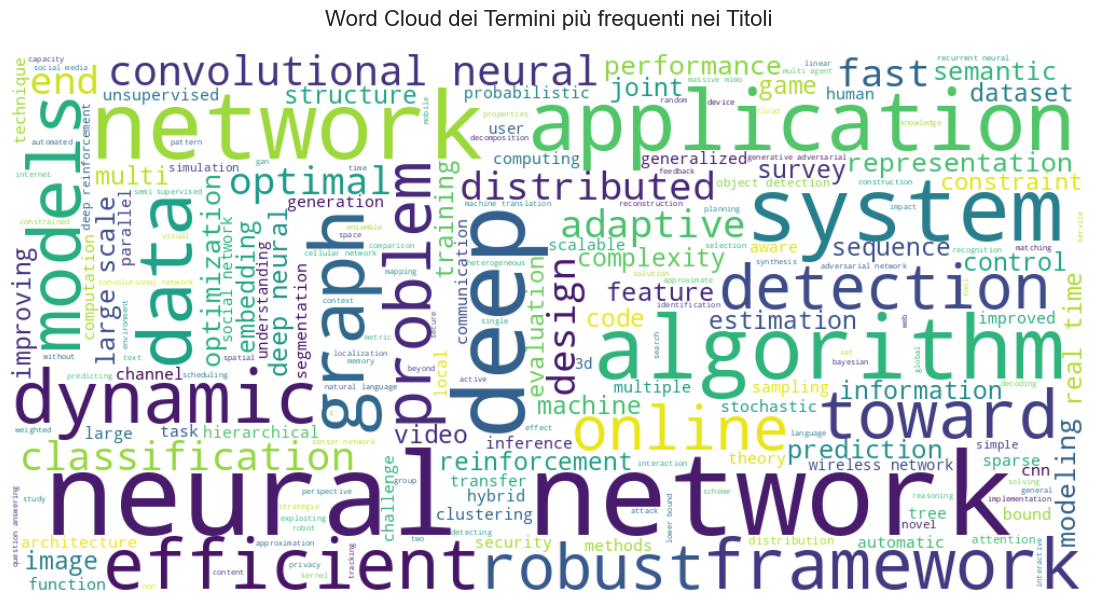

In [19]:
# 📚 Analisi Word Cloud dei Titoli più frequenti

import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import string

# === 1. Carica i titoli
df_titles = pd.read_csv("dataset/titleabs.tsv", sep="\t", names=["paper_id", "title", "abstract"])
df_titles["title"] = df_titles["title"].fillna("").astype(str)

# === 2. Pre-elaborazione del testo
stopwords = set(STOPWORDS)
custom_stopwords = {"using", "based", "approach", "via", "new", "method", "model", "analysis", "learning"}
stopwords.update(custom_stopwords)

# Unione di tutti i titoli in un unico testo
all_titles = " ".join(df_titles["title"]).lower()

# Rimozione della punteggiatura
translator = str.maketrans("", "", string.punctuation)
clean_text = all_titles.translate(translator)

# === 3. Generazione della word cloud
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    stopwords=stopwords,
    max_words=200,
    colormap='viridis',
    contour_color='steelblue',
    contour_width=2
).generate(clean_text)

# === 4. Visualizzazione
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud dei Termini più frequenti nei Titoli", fontsize=16, pad=20)
plt.show()


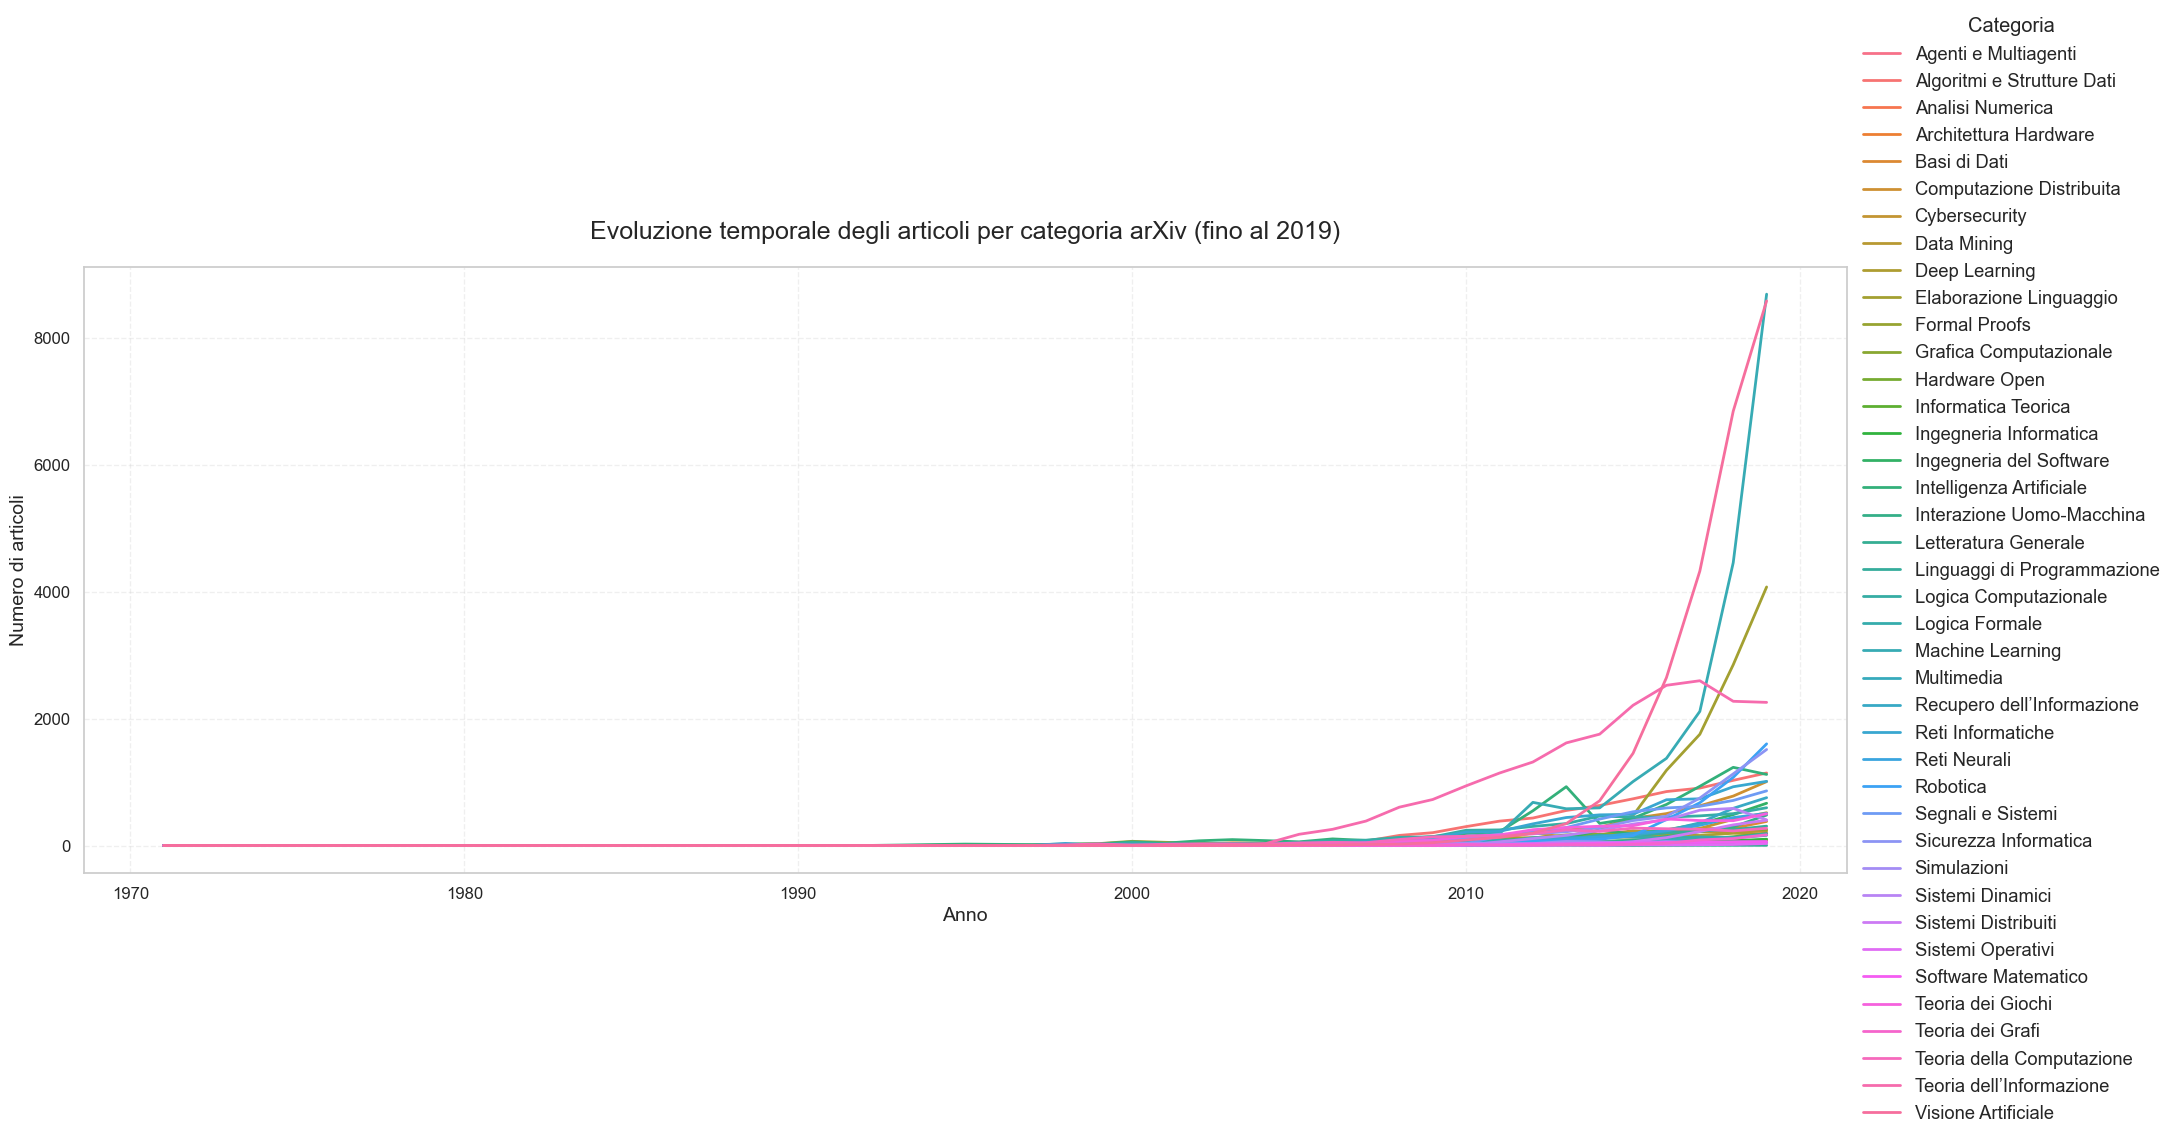

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Costruzione DataFrame nodi ===
df_nodes = pd.DataFrame({
    "Anno": data.node_year.view(-1).tolist(),
    "Codice": [class_names[int(y)] for y in data.y.view(-1)]
})
df_nodes["Categoria"] = df_nodes["Codice"].map(arxiv_nomi_umani)
df_nodes = df_nodes[df_nodes["Anno"] <= 2019]  # Filtra fino al 2019

# === 2. Conteggio articoli per anno e categoria ===
df_trend = df_nodes.groupby(["Anno", "Categoria"]).size().reset_index(name="Articoli")
pivot = df_trend.pivot(index="Anno", columns="Categoria", values="Articoli").fillna(0)

# === 3. Plot ===
sns.set(style="whitegrid", font_scale=1.2)
palette = sns.color_palette("husl", len(pivot.columns))  # Colori distinti

plt.figure(figsize=(22, 10))
for i, categoria in enumerate(pivot.columns):
    plt.plot(pivot.index, pivot[categoria], label=categoria, linewidth=2, color=palette[i])

# === 4. Estetica ===
plt.title("Evoluzione temporale degli articoli per categoria arXiv (fino al 2019)", fontsize=18, pad=20)
plt.xlabel("Anno", fontsize=14)
plt.ylabel("Numero di articoli", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.3)

plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), frameon=False, title="Categoria")
plt.tight_layout()
plt.show()


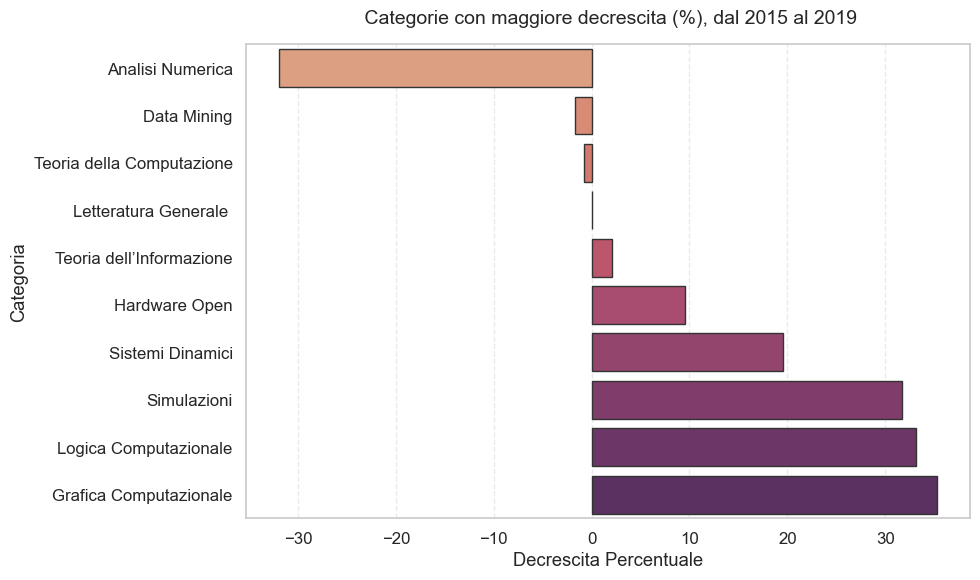

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Costruzione DataFrame nodi ===
df_nodes = pd.DataFrame({
    "Anno": data.node_year.view(-1).tolist(),
    "Categoria": [arxiv_nomi_umani[class_names[int(y)]] for y in data.y.view(-1)]
})

# === 2. Filtro: solo anni 2015-2019 ===
df_recent = df_nodes[df_nodes["Anno"].between(2015, 2019)]

# === 3. Conteggio articoli per anno e categoria ===
counts = df_recent.groupby(["Anno", "Categoria"]).size().unstack(fill_value=0)

# === 4. Calcolo variazione percentuale 2019 vs 2015 ===
perc_diff = ((counts.loc[2019] - counts.loc[2015]) / counts.loc[2015]) * 100
perc_diff = perc_diff.replace([float('inf'), -float('inf')], 0)  # evitiamo inf
top_decrescita = perc_diff.sort_values().head(10)

# === 5. Plot ===
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_decrescita.values,
    y=top_decrescita.index,
    hue=top_decrescita.index,       # aggiungi questo
    palette="flare",
    legend=False,
    edgecolor=".2"
)


# === 6. Estetica ===
plt.title(" Categorie con maggiore decrescita (%), dal 2015 al 2019", fontsize=14, pad=15)
plt.xlabel("Decrescita Percentuale")
plt.ylabel("Categoria")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [22]:
top10_mag_ids = [ogbn_to_mag[data.x.size(0) - len(top_rows) + i] for i in range(10)]

# Oppure direttamente dai nodi, se conservati
# Se hai salvato i node_id originali (come suggerito), meglio ancora:
top10_mag_ids = [ogbn_to_mag[info["node_id"]] for info in top_by_year.values()]
top10_mag_ids = top10_mag_ids[:10]

print(top10_mag_ids)


['2950133701', '2949649109', '1519399059', '2952224880', '3012541776', '2950147620', '2951430429', '1931755669', '2949944631', '2511422681']


In [23]:
import requests
from rich.console import Console
from rich.table import Table
from rich import box

# Lista dei MAG_ID da interrogare (già estratti)
mag_ids = [
    '2950133701', '2949649109', '1519399059', '2952224880', '3012541776',
    '2950147620', '2951430429', '1931755669', '2949944631', '2511422681'
]

# Setup Rich
console = Console()
table = Table(title="🧑‍🔬 Autori e Titoli dei Top Paper", box=box.MINIMAL_DOUBLE_HEAD)
table.add_column("MAG ID", style="cyan", no_wrap=True)
table.add_column("Titolo", style="yellow")
table.add_column("Autori", style="green")

for mag_id in mag_ids:
    openalex_id = f"W{mag_id}"
    url = f"https://api.openalex.org/works/{openalex_id}"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            title = data.get("title", "[Titolo non disponibile]")
            authorships = data.get("authorships", [])
            autori = ", ".join([a['author']['display_name'] for a in authorships])
            table.add_row(mag_id, title[:80] + ("..." if len(title) > 80 else ""), autori)
        else:
            table.add_row(mag_id, "[Errore nella richiesta]", "❌")
    except Exception as e:
        table.add_row(mag_id, "[Errore di rete]", str(e))

console.print(table)


                                        🧑‍🔬 Autori e Titoli dei Top Paper                                         
             ╷                                                 ╷                                                   
  MAG ID     │ Titolo                                          │ Autori                                            
 ════════════╪═════════════════════════════════════════════════╪══════════════════════════════════════════════════ 
  2950133701 │ Practical Algorithms for Finding Extremal Sets  │ Martin Marinov, Nicholas Nash, David Gregg        
  2949649109 │ Automatic Assessment of Full Left Ventricular   │ Le Zhang, Ali Gooya, Marco Pereañez, Bo Dong,     
             │ Coverage in Cardiac Cine Magnetic ...           │ Stefan K. Piechnik, Stefan Neubauer, Steffen E.   
             │                                                 │ Petersen, Alejandro F. Frangi                     
  1519399059 │ A maximum entropy theorem with applications to  │ Tom Leinster                                      
             │ the measurement of biodiversity                 │                                                   
  2952224880 │ Alignment Based Kernel Learning with a          │ Arash Afkanpour, Csaba Szepesvári, Michael        
             │ Continuous Set of Base Kernels                  │ Bowling                                           
  3012541776 │ Utilizing Language Relatedness to improve       │ Anoop Kunchukuttan, Pushpak Bhattacharyya         
             │ Machine Translation: A Case Study on L...       │                                                   
  2950147620 │ A Fully Convolutional Neural Network based      │ Avijit Dasgupta, Sonam Singh                      
             │ Structured Prediction Approach Toward...        │                                                   
  2951430429 │ Light Field Saliency Detection with Deep        │ Jun Zhang, Yamei Liu, Shengping Zhang, Ronald     
             │ Convolutional Networks                          │ Poppe, Meng Wang                                  
  1931755669 │ Adaptive Replication in Distributed Content     │ Mathieu Leconte, Marc Lelarge, Laurent Massoulié  
             │ Delivery Networks                               │                                                   
  2949944631 │ HT-Paxos: High Throughput State-Machine         │ Vinit Kumar, Ajay Agarwal                         
             │ Replication Protocol for Large Clustered...     │                                                   
  2511422681 │ Physical Design Obfuscation of Hardware: A      │ Arunkumar Vijayakumar, Vinay C. Patil, Daniel     
             │ Comprehensive Investigation of Device...        │ Holcomb, Christof Paar, Sandip Kundu              
             ╵                                                 ╵

In [24]:
import pandas as pd
import networkx as nx
from torch_geometric.utils import to_networkx
from ogb.nodeproppred import PygNodePropPredDataset

# Carica dataset
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv')
data = dataset[0]

# Carica mapping OGBN → MAG ID
mapping_path = "dataset/ogbn-arxiv/ogbn_arxiv/mapping/nodeidx2paperid.csv.gz"
df_mapping = pd.read_csv(mapping_path, header=None, names=["MAG_ID"])
ogbn_to_mag = df_mapping["MAG_ID"].astype(str).tolist()

# Calcola in-degree
G = to_networkx(data, to_undirected=False)
in_degrees = dict(G.in_degree())

# Estrai top 100 paper per in-degree
top_k = 100
top_nodes = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:top_k]
top_mag_ids = [ogbn_to_mag[node_id] for node_id, _ in top_nodes]

# Salva in CSV
df_export = pd.DataFrame(top_mag_ids, columns=["MAG_ID"])
df_export.to_csv("top_100_mag_ids.csv", index=False)
print("✅ Salvato top_100_mag_ids.csv")


✅ Salvato top_100_mag_ids.csv


                🏛️ Top Istituti nei Top 100 paper                
╭────────────────────────────────────────────────────┬─────────╮
│ Istituto                                           │ # Paper │
├────────────────────────────────────────────────────┼─────────┤
│ Victoria University of Wellington                  │       5 │
│ University of Massachusetts Amherst                │       5 │
│ Tampere University of Applied Sciences             │       5 │
│ Université Grenoble Alpes                          │       5 │
│ ETH Zurich                                         │       5 │
│ Microsoft Research (United Kingdom)                │       4 │
│ Stanford University                                │       4 │
│ University of California, Davis                    │       4 │
│ Universitat Politècnica de Catalunya               │       4 │
│ Laboratoire d'Informatique de Grenoble             │       4 │
│ University of Engineering & Management             │       3 │
│ Ericsson (Sweden)                                  │       3 │
│ Chinese University of Hong Kong                    │       3 │
│ King Abdullah University of Science and Technology │       3 │
│ Pennsylvania State University                      │       3 │
╰────────────────────────────────────────────────────┴─────────╯

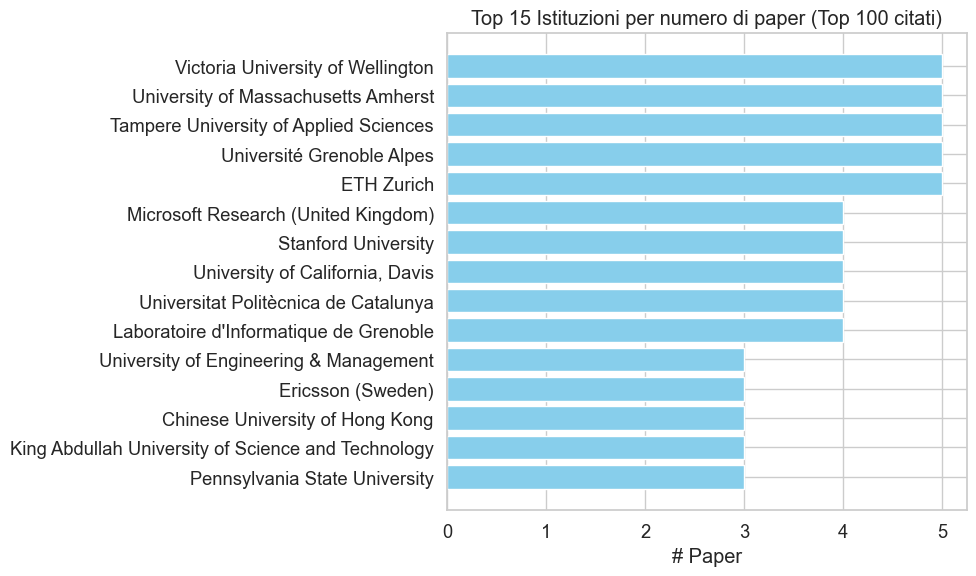

In [25]:
import pandas as pd
import requests
from collections import Counter
import time
import os
import matplotlib.pyplot as plt
from rich.console import Console
from rich.table import Table
from rich import box

# === Flag: vuoi davvero eseguire le query OpenAlex? ===
ESEGUI_QUERY = False  # ⬅️ Cambia a True solo se vuoi fare le chiamate API

# === 1. Carica MAG_ID dal file ===
df = pd.read_csv("top_100_mag_ids.csv")
mag_ids = df["MAG_ID"].tolist()
risultato_path = "openalex_istituti.csv"

if ESEGUI_QUERY:
    institution_counter = Counter()

    for i, mag_id in enumerate(mag_ids, 1):
        openalex_id = f"W{mag_id}"
        url = f"https://api.openalex.org/works/{openalex_id}"

        print(f"[{i}/{len(mag_ids)}] 🔍 Recupero dati per MAG_ID: {mag_id}...")

        try:
            response = requests.get(url)
            if response.status_code == 200:
                data = response.json()
                authorships = data.get("authorships", [])
                for auth in authorships:
                    for inst in auth.get("institutions", []):
                        name = inst.get("display_name")
                        if name:
                            institution_counter[name] += 1
            else:
                print(f"⚠️  Errore {response.status_code} per MAG_ID {mag_id}")
        except Exception as e:
            print(f"❌ Errore durante la richiesta: {e}")

        time.sleep(1.2)

    # === Salva i risultati ===
    df_out = pd.DataFrame(institution_counter.items(), columns=["Istituto", "Paper"])
    df_out.to_csv(risultato_path, index=False)
    print(f"\n✅ Risultati salvati in {risultato_path}")

# === 2. Visualizzazione dei risultati ===
if os.path.exists(risultato_path):
    df_risultati = pd.read_csv(risultato_path)

    # Rich Table
    console = Console()
    table = Table(title="🏛️ Top Istituti nei Top 100 paper", box=box.ROUNDED)
    table.add_column("Istituto", style="cyan")
    table.add_column("# Paper", justify="right", style="magenta")

    for _, row in df_risultati.sort_values("Paper", ascending=False).head(15).iterrows():
        table.add_row(row["Istituto"], str(row["Paper"]))

    console.print(table)

    # Barplot
    top15 = df_risultati.sort_values("Paper", ascending=False).head(15)
    plt.figure(figsize=(10, 6))
    plt.barh(top15["Istituto"], top15["Paper"], color="skyblue")
    plt.title("Top 15 Istituzioni per numero di paper (Top 100 citati)")
    plt.xlabel("# Paper")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Nessun file di risultati trovato. Esegui con `ESEGUI_QUERY = True` per crearne uno.")


La **classificazione dei nodi** è un compito fondamentale nell'analisi dei grafi: dato un nodo e le sue connessioni nel grafo, l'obiettivo è predire a quale classe appartiene. Questo è particolarmente utile in contesti come reti di citazioni, reti sociali o sistemi di raccomandazione.

Nel nostro caso, classifichiamo articoli accademici presenti nel dataset **ogbn-arxiv** in base al campo di ricerca (es. Machine Learning, Visione Artificiale, ecc.).

### 🔧 Modello: GraphSAGE
Utilizziamo il modello **GraphSAGE** (*Graph Sample and Aggregate*), una GNN che costruisce rappresentazioni dei nodi combinando le feature dei vicini in modo efficiente. Qui usiamo una semplice architettura a due layer con attivazione `ReLU` intermedia.

### 🚀 Training e valutazione
La pipeline prevede:
1. **Caricamento del dataset** e divisione in train/val/test.
2. **Definizione del modello** e ottimizzatore.
3. **Resume da checkpoint**, se presente.
4. **Loop di training** con salvataggio del miglior modello basato su accuratezza in validation.
5. **Early stopping** per evitare overfitting.
6. **Estrazione degli embedding finali** da salvare su disco.

Il training è monitorato con un log CSV e stampa progressiva delle metriche a ogni epoca.


In [26]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from torch_geometric.transforms import ToUndirected
import os

# === 1. Setup ===
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
data = dataset[0]
split_idx = dataset.get_idx_split()
evaluator = Evaluator(name='ogbn-arxiv')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
train_idx = split_idx['train'].to(device)
val_idx = split_idx['valid'].to(device)
test_idx = split_idx['test'].to(device)

# === 2. Definizione modello ===
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

model_path = "best_sage_model.pt"
checkpoint_path = "checkpoint_sage.pth"
log_path = "training_log.csv"

model = GraphSAGE(data.num_features, 128, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# === 3. Resume da checkpoint se disponibile ===
start_epoch = 1
best_val_acc = 0.0
patience_counter = 0

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_acc = checkpoint['best_val_acc']
    patience_counter = checkpoint['patience_counter']
    print(f"🔁 Resume training da epoch {start_epoch}, best val acc: {best_val_acc:.4f}")
else:
    print("🆕 Inizio nuovo training...")
    if os.path.exists(log_path):
        os.remove(log_path)  # reset log se nuovo training

# === 4. Funzioni di training e valutazione ===
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx].squeeze())
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate():
    model.eval()
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=-1)
    return (
        evaluator.eval({'y_true': data.y[train_idx], 'y_pred': y_pred[train_idx].unsqueeze(1)})['acc'],
        evaluator.eval({'y_true': data.y[val_idx], 'y_pred': y_pred[val_idx].unsqueeze(1)})['acc'],
        evaluator.eval({'y_true': data.y[test_idx], 'y_pred': y_pred[test_idx].unsqueeze(1)})['acc'],
    )

# === 5. Training con Early Stopping e Resume ===
early_stop_patience = 10
for epoch in range(start_epoch, start_epoch + 100):
    loss = train()
    train_acc, val_acc, test_acc = evaluate()

    # === Log visivo
    print(f"[Epoch {epoch:03d}] Loss: {loss:.4f} | Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f}")

    # === Logging CSV
    with open(log_path, "a") as f:
        f.write(f"{epoch},{loss:.4f},{train_acc:.4f},{val_acc:.4f},{test_acc:.4f}\n")

    # === Model Saving
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), model_path)
        print("💾 Nuovo best model salvato")
    else:
        patience_counter += 1
        print(f"⏳ Early stopping counter: {patience_counter}/{early_stop_patience}")

    # === Salvataggio checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_acc': best_val_acc,
        'patience_counter': patience_counter
    }, checkpoint_path)

    if patience_counter >= early_stop_patience:
        print("🛑 Early stopping attivato!")
        break

# === 6. Salva embedding dal miglior modello ===
model.load_state_dict(torch.load(model_path))
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index).cpu()

torch.save(embeddings, "sage_node_embeddings.pt")
print("✅ Embedding salvati in 'sage_node_embeddings.pt'")


🔁 Resume training da epoch 323, best val acc: 0.6946
[Epoch 323] Loss: 0.9696 | Train: 0.7061 | Val: 0.6937 | Test: 0.6821
⏳ Early stopping counter: 12/10
🛑 Early stopping attivato!
✅ Embedding salvati in 'sage_node_embeddings.pt'


     📊 Riepilogo Completo Training GraphSAGE      
                                                   
  Epoch     Loss   Train Acc   Val Acc   Test Acc  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
      1   3.6761      0.1100    0.2297     0.2156  
      2   3.4230      0.1108    0.2302     0.2157  
      3   3.1740      0.1478    0.2416     0.2228  
      4   3.0435      0.2246    0.1774     0.1584  
      5   3.0188      0.1791    0.0763     0.0586  
      6   3.0045      0.1792    0.0765     0.0587  
      7   2.9320      0.1955    0.1096     0.0876  
      8   2.8569      0.2726    0.2855     0.2595  
      9   2.8057      0.2939    0.3070     0.2752  
     10   2.7602      0.2967    0.3083     0.2756  
     11   2.7075      0.2980    0.3093     0.2762  
     12   2.6466      0.2994    0.3105     0.2783  
     13   2.5817      0.3021    0.3125     0.2805  
     14   2.5178      0.3120    0.3234     0.2936  
     15   2.4571      0.3344    0.3527     0.3298  
     16   2.3996      0.3622    0.3892     0.3802  
     17   2.3450      0.3856    0.4149     0.4097  
     18   2.2923      0.4045    0.4294     0.4201  
     19   2.2392      0.4183    0.4341     0.4207  
     20   2.1863      0.4263    0.4350     0.4207  
     21   2.1361      0.4333    0.4414     0.4288  
     22   2.0898      0.4418    0.4567     0.4470  
     23   2.0462      0.4542    0.4771     0.4716  
     24   2.0045      0.4665    0.4952     0.4919  
     25   1.9653      0.4764    0.5068     0.5042  
     26   1.9289      0.4825    0.5114     0.5091  
     27   1.8946      0.4875    0.5143     0.5120  
     28   1.8618      0.4921    0.5174     0.5156  
     29   1.8308      0.4968    0.5217     0.5191  
     30   1.8017      0.5017    0.5250     0.5235  
     31   1.7744      0.5065    0.5293     0.5265  
     32   1.7486      0.5123    0.5338     0.5301  
     33   1.7238      0.5197    0.5411     0.5366  
     34   1.7006      0.5266    0.5498     0.5463  
     35   1.6788      0.5337    0.5567     0.5553  
     36   1.6572      0.5380    0.5608     0.5585  
     37   1.6359      0.5426    0.5632     0.5585  
     38   1.6164      0.5466    0.5650     0.5596  
     39   1.5984      0.5523    0.5713     0.5656  
     40   1.5806      0.5582    0.5764     0.5742  
     41   1.5631      0.5630    0.5815     0.5803  
     42   1.5464      0.5669    0.5848     0.5814  
     43   1.5309      0.5707    0.5861     0.5813  
     44   1.5161      0.5741    0.5889     0.5833  
     45   1.5017      0.5775    0.5922     0.5865  
     46   1.4878      0.5807    0.5953     0.5898  
     47   1.4747      0.5840    0.5987     0.5925  
     48   1.4621      0.5867    0.6013     0.5951  
     49   1.4498      0.5891    0.6036     0.5986  
     50   1.4384      0.5916    0.6065     0.6012  
     51   1.4277      0.5938    0.6084     0.6016  
     52   1.4169      0.5961    0.6091     0.6018  
     53   1.4067      0.5981    0.6102     0.6035  
     54   1.3974      0.5996    0.6125     0.6055  
     55   1.3883      0.6017    0.6149     0.6068  
     56   1.3795      0.6039    0.6163     0.6087  
     57   1.3711      0.6065    0.6180     0.6113  
     58   1.3632      0.6080    0.6193     0.6138  
     59   1.3556      0.6093    0.6204     0.6144  
     60   1.3483      0.6104    0.6212     0.6149  
     61   1.3413      0.6118    0.6232     0.6155  
     62   1.3346      0.6135    0.6249     0.6169  
     63   1.3281      0.6151    0.6259     0.6192  
     64   1.3219      0.6166    0.6274     0.6200  
     65   1.3159      0.6176    0.6282     0.6217  
     66   1.3101      0.6185    0.6288     0.6234  
     67   1.3046      0.6201    0.6300     0.6244  
     68   1.2992      0.6217    0.6314     0.6258  
     69   1.2939      0.6229    0.6328     0.6272  
     70   1.2889      0.6240    0.6337     0.6280  
     71   1.2840      0.6249    0.6346     0.6288  
     72   1.2793      0.6259    0.6350     0.6298  
     73   1.2747      0.6273    0.6360     0.6309

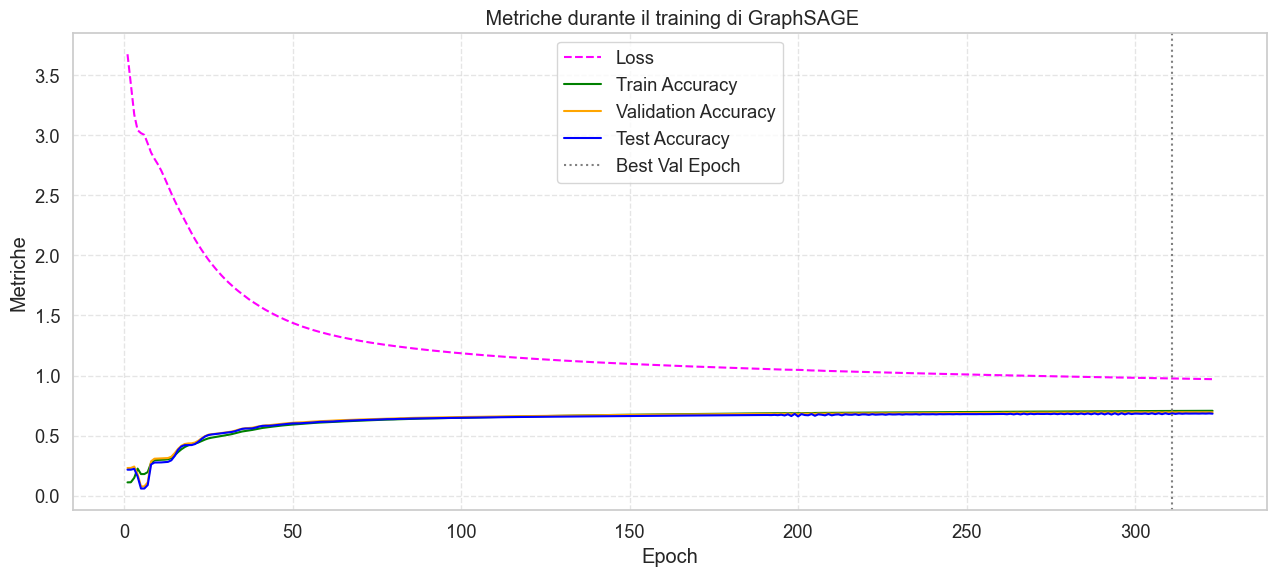

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from rich.console import Console
from rich.table import Table
from rich import box

# === 1. Carica il file di log del training ===
log_path = "training_log.csv"
df_log = pd.read_csv(log_path, names=["Epoch", "Loss", "Train Acc", "Val Acc", "Test Acc"])

# === 2. Visualizzazione tabellare di tutte le epoche con Rich ===
console = Console()
table = Table(title="📊 Riepilogo Completo Training GraphSAGE", box=box.SIMPLE_HEAVY)
table.add_column("Epoch", justify="right", style="cyan")
table.add_column("Loss", justify="right", style="magenta")
table.add_column("Train Acc", justify="right", style="green")
table.add_column("Val Acc", justify="right", style="yellow")
table.add_column("Test Acc", justify="right", style="blue")

best_row = df_log["Val Acc"].idxmax()

for i, row in df_log.iterrows():
    style = "bold white" if i == best_row else ""
    table.add_row(
        str(int(row["Epoch"])),
        f"{row['Loss']:.4f}",
        f"{row['Train Acc']:.4f}",
        f"{row['Val Acc']:.4f}",
        f"{row['Test Acc']:.4f}",
        style=style
    )

console.print(table)

# === 3. Plot delle metriche nel tempo ===
plt.figure(figsize=(13, 6))
plt.plot(df_log["Epoch"], df_log["Loss"], label="Loss", color="magenta", linestyle="--")
plt.plot(df_log["Epoch"], df_log["Train Acc"], label="Train Accuracy", color="green")
plt.plot(df_log["Epoch"], df_log["Val Acc"], label="Validation Accuracy", color="orange")
plt.plot(df_log["Epoch"], df_log["Test Acc"], label="Test Accuracy", color="blue")
plt.axvline(df_log.loc[best_row, "Epoch"], color="gray", linestyle=":", label="Best Val Epoch")

plt.xlabel("Epoch")
plt.ylabel("Metriche")
plt.title(" Metriche durante il training di GraphSAGE")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


## Classificazione con GCN (Graph Convolutional Network)

In questa sezione addestriamo un modello **GCN**, una delle architetture più classiche per la classificazione su grafi. A differenza di GraphSAGE, il GCN effettua una convoluzione che combina direttamente i vicini in una forma normalizzata, ed è particolarmente efficace quando la struttura del grafo è ben formata e completa.

###  Preparazione
- Carichiamo nuovamente il dataset `ogbn-arxiv` e verifichiamo che le feature dei nodi siano esattamente **128**, come richiesto dal checkpoint eventualmente disponibile.
- Dividiamo il dataset in train/val/test e spostiamo tutto su `cuda` se disponibile.

###  Architettura GCN
- Il modello implementato ha **2 layer di convoluzione** `GCNConv` con attivazione ReLU tra i due.
- Le dimensioni nascoste sono impostate a 128, coerentemente con la configurazione del GraphSAGE per un confronto equo.

###  Training con Early Stopping
- Viene adottato un meccanismo di **early stopping** con pazienza di 10 epoche.
- Il training può riprendere automaticamente da un **checkpoint** compatibile (basato sul numero di feature in input).
- A ogni epoca viene registrata la loss e l’accuratezza su train, validation e test, salvando il **miglior modello**.

###  Estrazione degli embedding
Alla fine dell’addestramento, estraiamo gli **embedding** dei nodi dal GCN allena


In [28]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from torch_geometric.transforms import ToUndirected

# === 1. Setup ===
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
data = dataset[0]
split_idx = dataset.get_idx_split()
evaluator = Evaluator(name='ogbn-arxiv')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
train_idx = split_idx['train'].to(device)
val_idx = split_idx['valid'].to(device)
test_idx = split_idx['test'].to(device)

# === 2. Forza le 128 feature originali ===
EXPECTED_INPUT_DIM = 128
if data.x.shape[1] > EXPECTED_INPUT_DIM:
    print(f"✂️ Taglio feature extra: da {data.x.shape[1]} → {EXPECTED_INPUT_DIM}")
    data.x = data.x[:, :EXPECTED_INPUT_DIM]
elif data.x.shape[1] < EXPECTED_INPUT_DIM:
    raise ValueError(f"❌ data.x ha solo {data.x.shape[1]} feature, ne servono esattamente 128!")

# === 3. Modello GCN ===
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# === 4. Paths ===
model_path = "best_gcn_model.pt"
checkpoint_path = "checkpoint_gcn.pth"
log_path = "training_log_gcn.csv"

# === 5. Instanzia modello e ottimizzatore ===
model = GCN(EXPECTED_INPUT_DIM, 128, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# === 6. Resume da checkpoint se compatibile ===
start_epoch = 1
best_val_acc = 0.0
patience_counter = 0

if os.path.exists(checkpoint_path):
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        ckpt_in_dim = checkpoint['model_state_dict']['conv1.lin.weight'].shape[1]
        if ckpt_in_dim == EXPECTED_INPUT_DIM:
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            best_val_acc = checkpoint['best_val_acc']
            patience_counter = checkpoint['patience_counter']
            print(f"🔁 Resume training da epoch {start_epoch}, best val acc: {best_val_acc:.4f}")
        else:
            print(f"⚠️ Checkpoint incompatibile: input dim = {ckpt_in_dim}, expected = {EXPECTED_INPUT_DIM}")
            print("🆕 Partenza da zero...")
    except Exception as e:
        print(f"❌ Errore nel caricamento checkpoint: {e}")
        print("🆕 Partenza da zero...")
else:
    print("🆕 Inizio nuovo training...")

# === 7. Funzioni di training e valutazione ===
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx].squeeze())
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate():
    model.eval()
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=-1)
    return (
        evaluator.eval({'y_true': data.y[train_idx], 'y_pred': y_pred[train_idx].unsqueeze(1)})['acc'],
        evaluator.eval({'y_true': data.y[val_idx], 'y_pred': y_pred[val_idx].unsqueeze(1)})['acc'],
        evaluator.eval({'y_true': data.y[test_idx], 'y_pred': y_pred[test_idx].unsqueeze(1)})['acc'],
    )

# === 8. Training con Early Stopping ===
early_stop_patience = 10
for epoch in range(start_epoch, start_epoch + 100):
    loss = train()

    if epoch % 10 == 0:
        train_acc, val_acc, test_acc = evaluate()
        print(f"[Epoch {epoch:03d}] Loss: {loss:.4f} | Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f}")

        with open(log_path, "a") as f:
            f.write(f"{epoch},{loss:.4f},{train_acc:.4f},{val_acc:.4f},{test_acc:.4f}\n")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
            print("💾 Nuovo best model salvato")
        else:
            patience_counter += 1
            print(f"⏳ Early stopping counter: {patience_counter}/{early_stop_patience}")

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
            'patience_counter': patience_counter
        }, checkpoint_path)

        if patience_counter >= early_stop_patience:
            print("🛑 Early stopping attivato!")
            break

# === 9. Embedding finali ===
model.load_state_dict(torch.load(model_path))
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index).cpu()
torch.save(embeddings, "gcn_node_embeddings.pt")
print("✅ Embedding salvati in 'gcn_node_embeddings.pt'")


🔁 Resume training da epoch 291, best val acc: 0.6903
[Epoch 300] Loss: 1.0396 | Train: 0.6938 | Val: 0.6914 | Test: 0.6809
💾 Nuovo best model salvato
[Epoch 310] Loss: 1.0355 | Train: 0.6946 | Val: 0.6924 | Test: 0.6821
💾 Nuovo best model salvato
[Epoch 320] Loss: 1.0315 | Train: 0.6956 | Val: 0.6936 | Test: 0.6834
💾 Nuovo best model salvato
[Epoch 330] Loss: 1.0278 | Train: 0.6964 | Val: 0.6943 | Test: 0.6846
💾 Nuovo best model salvato
[Epoch 340] Loss: 1.0242 | Train: 0.6975 | Val: 0.6952 | Test: 0.6844
💾 Nuovo best model salvato
[Epoch 350] Loss: 1.0207 | Train: 0.6981 | Val: 0.6960 | Test: 0.6855
💾 Nuovo best model salvato
[Epoch 360] Loss: 1.0174 | Train: 0.6992 | Val: 0.6963 | Test: 0.6856
💾 Nuovo best model salvato
[Epoch 370] Loss: 1.0142 | Train: 0.6997 | Val: 0.6967 | Test: 0.6855
💾 Nuovo best model salvato
[Epoch 380] Loss: 1.0113 | Train: 0.7005 | Val: 0.6965 | Test: 0.6839
⏳ Early stopping counter: 1/10
[Epoch 390] Loss: 1.0081 | Train: 0.7013 | Val: 0.6976 | Test: 0.6872


   📊 Riepilogo Training GCN (ultime 10 epoche)    
                                                   
  Epoch     Loss   Train Acc   Val Acc   Test Acc  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
    300   1.0396      0.6938    0.6914     0.6809  
    310   1.0355      0.6946    0.6924     0.6821  
    320   1.0315      0.6956    0.6936     0.6834  
    330   1.0278      0.6964    0.6943     0.6846  
    340   1.0242      0.6975    0.6952     0.6844  
    350   1.0207      0.6981    0.6960     0.6855  
    360   1.0174      0.6992    0.6963     0.6856  
    370   1.0142      0.6997    0.6967     0.6855  
    380   1.0113      0.7005    0.6965     0.6839  
    390   1.0081      0.7013    0.6976     0.6872 


📈 Media ultimi 10: Val Acc = 0.6950 | Test Acc = 0.6843


C:\Users\paolo\AppData\Local\Temp\ipykernel_480\678983252.py:56: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\paolo\AppData\Local\Temp\ipykernel_480\678983252.py:57: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.savefig("gcn_training_plot.png")
C:\Users\paolo\DM2\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


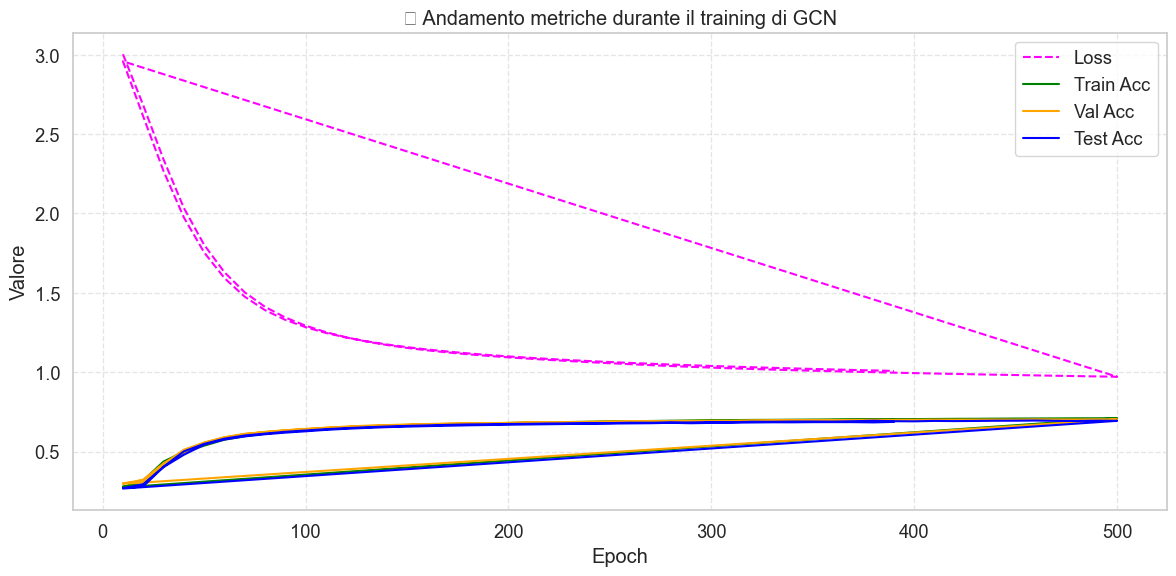

✅ Grafico salvato in 'gcn_training_plot.png'


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from rich.console import Console
from rich.table import Table
from rich import box
import os

# === 1. Carica il file di log del training (GCN) ===
log_path = "training_log_gcn.csv"
if not os.path.exists(log_path):
    raise FileNotFoundError(f"❌ Il file '{log_path}' non esiste. Assicurati che il training sia stato completato.")

# Se il CSV non ha header
df_log = pd.read_csv(log_path, names=["Epoch", "Loss", "Train Acc", "Val Acc", "Test Acc"])

# Converte le colonne in numeriche, rimuovendo eventuali stringhe problematiche
df_log[["Epoch", "Loss", "Train Acc", "Val Acc", "Test Acc"]] = df_log[["Epoch", "Loss", "Train Acc", "Val Acc", "Test Acc"]].apply(pd.to_numeric, errors="coerce")
df_log = df_log.dropna()

# === 2. Visualizzazione tabellare con Rich (ultimi 10 step) ===
console = Console()
table = Table(title="📊 Riepilogo Training GCN (ultime 10 epoche)", box=box.SIMPLE_HEAVY)
table.add_column("Epoch", justify="right", style="cyan")
table.add_column("Loss", justify="right", style="magenta")
table.add_column("Train Acc", justify="right", style="green")
table.add_column("Val Acc", justify="right", style="yellow")
table.add_column("Test Acc", justify="right", style="blue")

for _, row in df_log.tail(10).iterrows():
    table.add_row(
        str(int(row["Epoch"])),
        f"{row['Loss']:.4f}",
        f"{row['Train Acc']:.4f}",
        f"{row['Val Acc']:.4f}",
        f"{row['Test Acc']:.4f}",
    )

console.print(table)

# === 3. Stampa statistiche finali
val_mean = df_log["Val Acc"].tail(10).mean()
test_mean = df_log["Test Acc"].tail(10).mean()
print(f"\n📈 Media ultimi 10: Val Acc = {val_mean:.4f} | Test Acc = {test_mean:.4f}")

# === 4. Plot delle metriche nel tempo
plt.figure(figsize=(12, 6))
plt.plot(df_log["Epoch"], df_log["Loss"], label="Loss", color="magenta", linestyle="--")
plt.plot(df_log["Epoch"], df_log["Train Acc"], label="Train Acc", color="green")
plt.plot(df_log["Epoch"], df_log["Val Acc"], label="Val Acc", color="orange")
plt.plot(df_log["Epoch"], df_log["Test Acc"], label="Test Acc", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Valore")
plt.title("Andamento metriche durante il training di GCN")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("gcn_training_plot.png")
plt.show()

print("✅ Grafico salvato in 'gcn_training_plot.png'")



In questa sezione addestriamo un modello **GAT**, una variante delle GNN che introduce un meccanismo di **attenzione** tra i nodi. A differenza di GCN o GraphSAGE, GAT assegna un peso diverso a ciascun vicino durante l’aggregazione, migliorando la capacità del modello di focalizzarsi sui nodi più rilevanti.

###  Vantaggi dell'attenzione
- Ogni nodo **pesa dinamicamente** i suoi vicini in base al contenuto delle feature.
- Migliora le performance in grafi eterogenei o rumorosi.
- Consente una maggiore **espressività** rispetto ai metodi basati su media o somma.

###  Configurazione
- Architettura con **2 layer GATConv**: il primo con 8 teste di attenzione, il secondo con 1.
- Applichiamo **dropout 0.6** prima di ogni layer per regolarizzazione.
- Ottimizzazione con `Adam` e **weight decay**.

###  Training
- Implementiamo resume da checkpoint, early stopping e logging CSV.
- Ogni 10 epoche valutiamo accuratezza su training, validation e test.
- Alla fine salviamo gli **embedding dei nodi** prodotti dal GAT, che potranno essere utilizzati per classificazione tradizionale o visualizzazione.

> Il modello GAT è particolarmente adatto in contesti dove la rilevanza dei vicini non è omogenea, come nelle reti sociali o nei grafi citazionali ad alta densità.


In [30]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from torch_geometric.transforms import ToUndirected
import os

# === 1. Setup ===
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
data = dataset[0]
split_idx = dataset.get_idx_split()
evaluator = Evaluator(name='ogbn-arxiv')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
train_idx = split_idx['train'].to(device)
val_idx = split_idx['valid'].to(device)
test_idx = split_idx['test'].to(device)

# === 2. Definizione modello GAT ===
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model_path = "best_gat_model.pt"
checkpoint_path = "checkpoint_gat.pth"
log_path = "training_log_gat.csv"
model = GAT(data.num_features, 8, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# === 3. Resume da checkpoint se disponibile ===
start_epoch = 1
best_val_acc = 0.0
patience_counter = 0

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_acc = checkpoint['best_val_acc']
    patience_counter = checkpoint['patience_counter']
    print(f"🔁 Resume training da epoch {start_epoch}, best val acc: {best_val_acc:.4f}")
else:
    print("🆕 Inizio nuovo training...")

# === 4. Funzioni di training e valutazione ===
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx].squeeze())
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate():
    model.eval()
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=-1)
    return (
        evaluator.eval({'y_true': data.y[train_idx], 'y_pred': y_pred[train_idx].unsqueeze(1)})['acc'],
        evaluator.eval({'y_true': data.y[val_idx], 'y_pred': y_pred[val_idx].unsqueeze(1)})['acc'],
        evaluator.eval({'y_true': data.y[test_idx], 'y_pred': y_pred[test_idx].unsqueeze(1)})['acc'],
    )

# === 5. Training con Early Stopping e Resume ===
early_stop_patience = 10
for epoch in range(start_epoch, start_epoch + 100):
    loss = train()
    if epoch % 10 == 0:
        train_acc, val_acc, test_acc = evaluate()
        print(f"[Epoch {epoch:03d}] Loss: {loss:.4f} | Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f}")

        with open(log_path, "a") as f:
            f.write(f"{epoch},{loss:.4f},{train_acc:.4f},{val_acc:.4f},{test_acc:.4f}\n")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
            print("💾 Nuovo best model salvato")
        else:
            patience_counter += 1
            print(f"⏳ Early stopping counter: {patience_counter}/{early_stop_patience}")

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
            'patience_counter': patience_counter
        }, checkpoint_path)

        if patience_counter >= early_stop_patience:
            print("🛑 Early stopping attivato!")
            break

# === 6. Salva embedding dal miglior modello ===
model.load_state_dict(torch.load(model_path))
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index).cpu()

torch.save(embeddings, "gat_node_embeddings.pt")
print("✅ Embedding salvati in 'gat_node_embeddings.pt'")


🔁 Resume training da epoch 601, best val acc: 0.6406
[Epoch 610] Loss: 1.8718 | Train: 0.6216 | Val: 0.6397 | Test: 0.6353
⏳ Early stopping counter: 11/10
🛑 Early stopping attivato!
✅ Embedding salvati in 'gat_node_embeddings.pt'


     Riepilogo Training GAT (ultime 10 epoche)     
                                                   
  Epoch     Loss   Train Acc   Val Acc   Test Acc  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
    520   1.8609      0.6211    0.6394     0.6351  
    530   1.8646      0.6212    0.6389     0.6347  
    540   1.8636      0.6230    0.6389     0.6331  
    550   1.8655      0.6225    0.6394     0.6326  
    560   1.8629      0.6229    0.6399     0.6358  
    570   1.8667      0.6214    0.6396     0.6384  
    580   1.8671      0.6223    0.6388     0.6343  
    590   1.8626      0.6221    0.6390     0.6331  
    600   1.8698      0.6212    0.6392     0.6361  
    610   1.8718      0.6216    0.6397     0.6353 

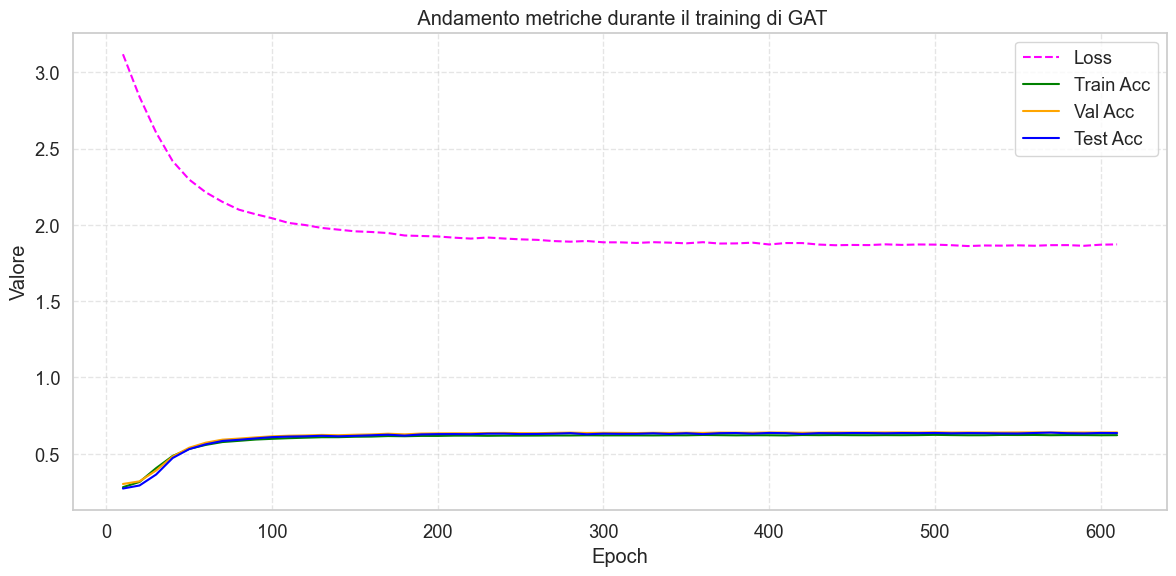

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from rich.console import Console
from rich.table import Table
from rich import box
import os

# === 1. Carica il file di log del training (GAT) ===
log_path = "training_log_gat.csv"
if not os.path.exists(log_path):
    raise FileNotFoundError(f"❌ Il file '{log_path}' non esiste.")

# Leggi il file CSV e forza la conversione in numerico, ignorando righe non valide
df_log = pd.read_csv(log_path, names=["Epoch", "Loss", "Train Acc", "Val Acc", "Test Acc"])
df_log[["Epoch", "Loss", "Train Acc", "Val Acc", "Test Acc"]] = df_log[["Epoch", "Loss", "Train Acc", "Val Acc", "Test Acc"]].apply(pd.to_numeric, errors="coerce")
df_log = df_log.dropna()

# === 2. Visualizzazione tabellare con Rich (ultimi 10 step) ===
console = Console()
table = Table(title=" Riepilogo Training GAT (ultime 10 epoche)", box=box.SIMPLE_HEAVY)
table.add_column("Epoch", justify="right", style="cyan")
table.add_column("Loss", justify="right", style="magenta")
table.add_column("Train Acc", justify="right", style="green")
table.add_column("Val Acc", justify="right", style="yellow")
table.add_column("Test Acc", justify="right", style="blue")

for _, row in df_log.tail(10).iterrows():
    table.add_row(
        str(int(row["Epoch"])),
        f"{row['Loss']:.4f}",
        f"{row['Train Acc']:.4f}",
        f"{row['Val Acc']:.4f}",
        f"{row['Test Acc']:.4f}",
    )

console.print(table)

# === 3. Plot delle metriche nel tempo ===
plt.figure(figsize=(12, 6))
plt.plot(df_log["Epoch"], df_log["Loss"], label="Loss", color="magenta", linestyle="--")
plt.plot(df_log["Epoch"], df_log["Train Acc"], label="Train Acc", color="green")
plt.plot(df_log["Epoch"], df_log["Val Acc"], label="Val Acc", color="orange")
plt.plot(df_log["Epoch"], df_log["Test Acc"], label="Test Acc", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Valore")
plt.title(" Andamento metriche durante il training di GAT")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


## Classificazione con GATv2 (versione leggera)

In questa sezione esploriamo l'utilizzo del modello **GATv2**, un'evoluzione del classico Graph Attention Network (GAT), che migliora la flessibilità dell'attenzione. A differenza di GAT, GATv2 consente di **calcolare i pesi di attenzione direttamente sulle feature non trasformate**, rendendolo più espressivo soprattutto in scenari con variazioni strutturali.

###  GATv2 "light": architettura compatta
Per ridurre il costo computazionale rispetto a GAT standard:
- Usiamo **solo 2 teste di attenzione** nel primo layer e **una sola testa** nel secondo.
- Abbassiamo il numero di **neuroni nascosti a 64**, mantenendo performance stabili.
- Applichiamo `dropout=0.4` su input e layer intermedi per evitare overfitting.

###  Addestramento
Il training segue la stessa logica dei modelli precedenti:
- Resume automatico da checkpoint.
- Early stopping con pazienza di 10 epoche.
- Log in CSV e salvataggio del miglior modello su base validation accuracy.

###  Output: embedding dei nodi
Al termine dell'allenamento, estraiamo e salviamo gli **embedding prodotti dal GATv2**, che saranno utilizzati nelle successive fasi di metric learning o classificazione tradizionale.

> L'obiettivo di questo setup è confrontare l’efficacia del meccanismo di attenzione avanzato di GATv2 rispetto a GAT standard, mantenendo un profilo computazionale più leggero.


In [32]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from torch_geometric.transforms import ToUndirected
import os

# === 1. Setup ===
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
data = dataset[0]
split_idx = dataset.get_idx_split()
evaluator = Evaluator(name='ogbn-arxiv')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
train_idx = split_idx['train'].to(device)
val_idx = split_idx['valid'].to(device)
test_idx = split_idx['test'].to(device)

# === 2. Definizione modello GATv2 leggero ===
class LightGATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=2, dropout=0.4)
        self.conv2 = GATv2Conv(hidden_channels * 2, out_channels, heads=1, concat=False, dropout=0.4)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model_path = "best_gatv2_model.pt"
checkpoint_path = "checkpoint_gatv2.pth"
log_path = "training_log_gatv2.csv"
model = LightGATv2(data.num_features, 64, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# === 3. Resume da checkpoint se disponibile ===
start_epoch = 1
best_val_acc = 0.0
patience_counter = 0

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_acc = checkpoint['best_val_acc']
    patience_counter = checkpoint['patience_counter']
    print(f"🔁 Resume training da epoch {start_epoch}, best val acc: {best_val_acc:.4f}")
else:
    print("🆕 Inizio nuovo training...")

# === 4. Funzioni di training e valutazione ===
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx].squeeze())
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate():
    model.eval()
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=-1)
    return (
        evaluator.eval({'y_true': data.y[train_idx], 'y_pred': y_pred[train_idx].unsqueeze(1)})['acc'],
        evaluator.eval({'y_true': data.y[val_idx], 'y_pred': y_pred[val_idx].unsqueeze(1)})['acc'],
        evaluator.eval({'y_true': data.y[test_idx], 'y_pred': y_pred[test_idx].unsqueeze(1)})['acc'],
    )

# === 5. Training con Early Stopping e Resume ===
early_stop_patience = 1
for epoch in range(start_epoch, start_epoch + 100):
    loss = train()
    if epoch % 10 == 0:
        train_acc, val_acc, test_acc = evaluate()
        print(f"[Epoch {epoch:03d}] Loss: {loss:.4f} | Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f}")
        with open(log_path, "a") as f:
            f.write(f"{epoch},{loss:.4f},{train_acc:.4f},{val_acc:.4f},{test_acc:.4f}\n")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
            print("💾 Nuovo best model salvato")
        else:
            patience_counter += 1
            print(f"⏳ Early stopping counter: {patience_counter}/{early_stop_patience}")

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
            'patience_counter': patience_counter
        }, checkpoint_path)

        if patience_counter >= early_stop_patience:
            print("🛑 Early stopping attivato!")
            break

# === 6. Salva embedding dal miglior modello ===
model.load_state_dict(torch.load(model_path))
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index).cpu()

torch.save(embeddings, "gatv2_node_embeddings.pt")
print("✅ Embedding salvati in 'gatv2_node_embeddings.pt'")


🔁 Resume training da epoch 301, best val acc: 0.6680
[Epoch 310] Loss: 1.4509 | Train: 0.6649 | Val: 0.6672 | Test: 0.6609
⏳ Early stopping counter: 1/10
[Epoch 320] Loss: 1.4442 | Train: 0.6646 | Val: 0.6687 | Test: 0.6661
💾 Nuovo best model salvato
[Epoch 330] Loss: 1.4476 | Train: 0.6656 | Val: 0.6687 | Test: 0.6641
⏳ Early stopping counter: 1/10
[Epoch 340] Loss: 1.4433 | Train: 0.6651 | Val: 0.6670 | Test: 0.6608
⏳ Early stopping counter: 2/10
[Epoch 350] Loss: 1.4434 | Train: 0.6653 | Val: 0.6677 | Test: 0.6607
⏳ Early stopping counter: 3/10
[Epoch 360] Loss: 1.4477 | Train: 0.6661 | Val: 0.6684 | Test: 0.6638
⏳ Early stopping counter: 4/10
[Epoch 370] Loss: 1.4417 | Train: 0.6662 | Val: 0.6687 | Test: 0.6617
💾 Nuovo best model salvato
[Epoch 380] Loss: 1.4417 | Train: 0.6668 | Val: 0.6694 | Test: 0.6621
💾 Nuovo best model salvato
[Epoch 400] Loss: 1.4394 | Train: 0.6665 | Val: 0.6697 | Test: 0.6664
💾 Nuovo best model salvato
✅ Embedding salvati in 'gatv2_node_embeddings.pt'


  📊 Riepilogo Training GATv2 (ultime 10 epoche)   
                                                   
  Epoch     Loss   Train Acc   Val Acc   Test Acc  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
    310   1.4509      0.6649    0.6672     0.6609  
    320   1.4442      0.6646    0.6687     0.6661  
    330   1.4476      0.6656    0.6687     0.6641  
    340   1.4433      0.6651    0.6670     0.6608  
    350   1.4434      0.6653    0.6677     0.6607  
    360   1.4477      0.6661    0.6684     0.6638  
    370   1.4417      0.6662    0.6687     0.6617  
    380   1.4417      0.6668    0.6694     0.6621  
    390   1.4423      0.6671    0.6684     0.6609  
    400   1.4394      0.6665    0.6697     0.6664 

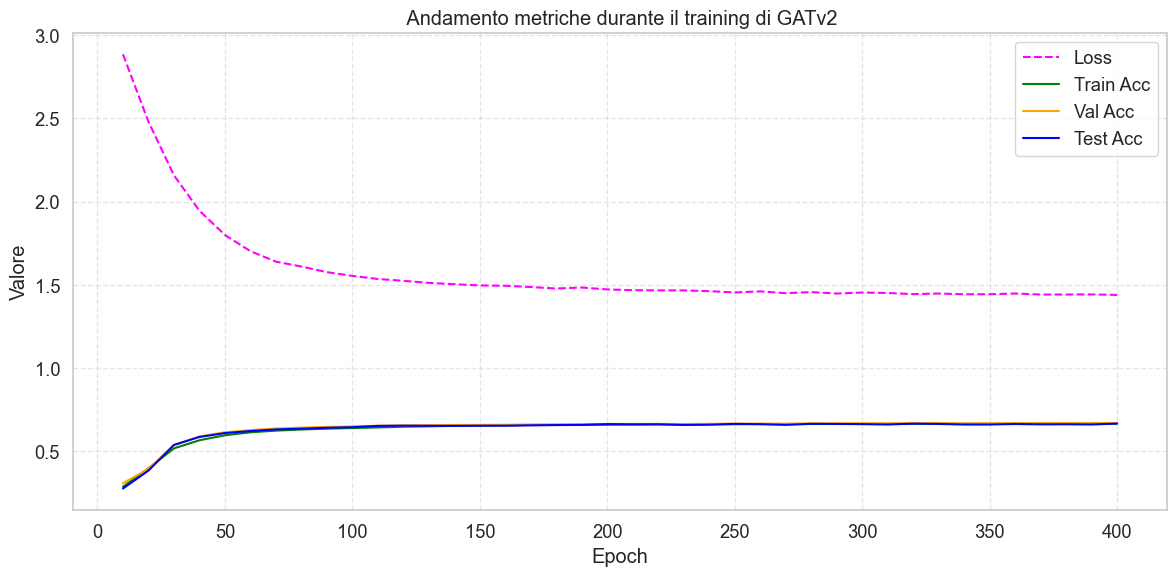

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from rich.console import Console
from rich.table import Table
from rich import box
import os

# === 1. Carica il file di log ===
log_path = "training_log_gatv2.csv"
if not os.path.exists(log_path):
    raise FileNotFoundError(f"❌ Il file '{log_path}' non esiste.")

df_log = pd.read_csv(log_path, names=["Epoch", "Loss", "Train Acc", "Val Acc", "Test Acc"])

# 🔧 Conversione sicura in numerico
df_log[["Epoch", "Loss", "Train Acc", "Val Acc", "Test Acc"]] = df_log[
    ["Epoch", "Loss", "Train Acc", "Val Acc", "Test Acc"]
].apply(pd.to_numeric, errors="coerce")

# Rimuove le righe con valori non numerici (NaN)
df_log = df_log.dropna()

# === 2. Visualizzazione tabellare con Rich (ultime 10 epoche) ===
console = Console()
table = Table(title="📊 Riepilogo Training GATv2 (ultime 10 epoche)", box=box.SIMPLE_HEAVY)
table.add_column("Epoch", justify="right", style="cyan")
table.add_column("Loss", justify="right", style="magenta")
table.add_column("Train Acc", justify="right", style="green")
table.add_column("Val Acc", justify="right", style="yellow")
table.add_column("Test Acc", justify="right", style="blue")

for _, row in df_log.tail(10).iterrows():
    table.add_row(
        str(int(row["Epoch"])),
        f"{row['Loss']:.4f}",
        f"{row['Train Acc']:.4f}",
        f"{row['Val Acc']:.4f}",
        f"{row['Test Acc']:.4f}",
    )

console.print(table)

# === 3. Plot delle metriche nel tempo ===
plt.figure(figsize=(12, 6))
plt.plot(df_log["Epoch"], df_log["Loss"], label="Loss", color="magenta", linestyle="--")
plt.plot(df_log["Epoch"], df_log["Train Acc"], label="Train Acc", color="green")
plt.plot(df_log["Epoch"], df_log["Val Acc"], label="Val Acc", color="orange")
plt.plot(df_log["Epoch"], df_log["Test Acc"], label="Test Acc", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Valore")
plt.title(" Andamento metriche durante il training di GATv2")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


## Classificazione tradizionale su embedding GNN

Dopo aver addestrato diverse GNN (GCN, GraphSAGE, GAT, GATv2), utilizziamo gli **embedding prodotti dai modelli** per eseguire una classificazione supervisionata con metodi standard.

###  Obiettivo
Valutare quanto siano informativi gli embedding estratti dalle reti neurali su grafo, confrontando le loro performance **in input a un classificatore Logistic Regression**. Questo approccio è utile per:
- Separare la fase di **estrazione di feature** (GNN) da quella di **classificazione**.
- Usare modelli **più interpretabili** o più efficienti nella fase predittiva.

###  Procedura
1. Carichiamo gli embedding salvati dai modelli GNN.
2. Standardizziamo le feature con `StandardScaler`.
3. Alleniamo una **Logistic Regression multinomiale** su `train`, valutando su `val` e `test`.
4. Confrontiamo l’accuratezza ottenuta dai vari embedding.

> Sebbene in questo esempio usiamo **Logistic Regression**, in seguito analizzeremo anche altri classificatori (es. MLP, k-NN) per un confronto più ampio.

Alla fine, riportiamo i risultati in una tabella riepilogativa con validation e test accuracy per ciascun embedding.


In [19]:
import torch
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from ogb.nodeproppred import PygNodePropPredDataset
from sklearn.preprocessing import StandardScaler

# === 1. Carica dataset ogbn-arxiv per etichette e split ===
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv')
split_idx = dataset.get_idx_split()
labels = dataset[0].y.squeeze().numpy()

# === 2. Funzione per valutare logistic regression su un embedding ===
def evaluate_embedding(embedding_path, name):
    print(f"\n🔍 Valutazione Logistic Regression su: {name}")

    # Carica embedding
    emb = torch.load(embedding_path).numpy()

    # Standardizza le feature
    emb = StandardScaler().fit_transform(emb)

    # Estrai gli indici per train/val/test
    train_idx = split_idx['train'].numpy()
    val_idx = split_idx['valid'].numpy()
    test_idx = split_idx['test'].numpy()

    # Prepara Logistic Regression
    clf = LogisticRegression(max_iter=1000, solver='lbfgs')
    clf.fit(emb[train_idx], labels[train_idx])

    # Valutazione
    val_acc = accuracy_score(labels[val_idx], clf.predict(emb[val_idx]))
    test_acc = accuracy_score(labels[test_idx], clf.predict(emb[test_idx]))

    print(f"📈 Val Accuracy:  {val_acc:.4f}")
    print(f"🧪 Test Accuracy: {test_acc:.4f}")
    return name, val_acc, test_acc

# === 3. Lista embedding da confrontare ===
embedding_files = {
    "GraphSAGE": "sage_node_embeddings.pt",
    "GCN": "gcn_node_embeddings.pt",
    "GAT": "gat_node_embeddings.pt",
    "GATv2": "gatv2_node_embeddings.pt"
}

# === 4. Esegui valutazioni
results = []
for name, path in embedding_files.items():
    results.append(evaluate_embedding(path, name))

# === 5. Tabella finale
df_results = pd.DataFrame(results, columns=["Model", "Val Acc", "Test Acc"])
print("\n📊 Confronto Logistic Regression sui vari embedding:")
print(df_results.to_string(index=False))



🔍 Valutazione Logistic Regression su: GraphSAGE
📈 Val Accuracy:  0.6942
🧪 Test Accuracy: 0.6839

🔍 Valutazione Logistic Regression su: GCN
📈 Val Accuracy:  0.6997
🧪 Test Accuracy: 0.6880

🔍 Valutazione Logistic Regression su: GAT
📈 Val Accuracy:  0.6725
🧪 Test Accuracy: 0.6638

🔍 Valutazione Logistic Regression su: GATv2
📈 Val Accuracy:  0.6898
🧪 Test Accuracy: 0.6810

📊 Confronto Logistic Regression sui vari embedding:
    Model  Val Acc  Test Acc
GraphSAGE 0.694184  0.683950
      GCN 0.699654  0.688003
      GAT 0.672472  0.663848
    GATv2 0.689788  0.680987


## Classificazione con Random Forest su embedding GNN

Oltre alla Logistic Regression, esploriamo l'efficacia di un classificatore **non lineare**: la **Random Forest**. Questo tipo di modello è robusto, interpretabile e adatto a gestire **feature complesse e non scalate perfettamente**, come quelle generate dalle GNN.

### 🌲 Perché Random Forest?
- Non richiede ipotesi lineari sui dati.
- Gestisce bene feature ad alta dimensionalità e interazioni complesse.
- È poco sensibile al rumore e offre una buona generalizzazione.

### 🧪 Dettagli dell'esperimento
- Usiamo gli **embedding generati da GCN, GraphSAGE, GAT e GATv2**.
- Alleniamo una Random Forest con un numero contenuto di alberi (`n_estimators=10`) per limitare l’uso di memoria.
- Per evitare overload di RAM, campioniamo una frazione (`50%`) dei set di validazione e test.
- Calcoliamo l’**accuratezza** su entrambi i set.

> Questo approccio permette di testare la qualità degli embedding in un contesto non lineare, fornendo un'altra prospettiva oltre ai modelli lineari come la Logistic Regression.

Alla fine riportiamo una tabella comparativa delle performance.


In [20]:
import torch
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from ogb.nodeproppred import PygNodePropPredDataset
from sklearn.model_selection import train_test_split

# === 1. Carica dataset e indici ===
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv')
split_idx = dataset.get_idx_split()
labels = dataset[0].y.squeeze().numpy()

train_idx = split_idx["train"].numpy()
val_idx = split_idx["valid"].numpy()
test_idx = split_idx["test"].numpy()

# === 2. Funzione di valutazione con Random Forest ===
def eval_random_forest(embedding_path, model_name, sample_frac=0.5, n_estimators=10):
    print(f"\n🌲 Valutazione Random Forest su: {model_name}")
    emb = torch.load(embedding_path).numpy()

    # Opzionale: riduciamo il set per non esplodere la RAM
    val_sample = int(len(val_idx) * sample_frac)
    test_sample = int(len(test_idx) * sample_frac)

    clf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1, random_state=42)
    clf.fit(emb[train_idx], labels[train_idx])

    val_acc = accuracy_score(labels[val_idx[:val_sample]], clf.predict(emb[val_idx[:val_sample]]))
    test_acc = accuracy_score(labels[test_idx[:test_sample]], clf.predict(emb[test_idx[:test_sample]]))

    print(f"🟡 Val Accuracy: {val_acc:.4f}")
    print(f"🟢 Test Accuracy: {test_acc:.4f}")
    return model_name, val_acc, test_acc

# === 3. Valutazione su tutti gli embedding ===
results = []
results.append(eval_random_forest("sage_node_embeddings.pt", "GraphSAGE"))
results.append(eval_random_forest("gcn_node_embeddings.pt", "GCN"))
results.append(eval_random_forest("gat_node_embeddings.pt", "GAT"))
results.append(eval_random_forest("gatv2_node_embeddings.pt", "GATv2"))

# === 4. Confronto finale ===
print("\n📊 Confronto Random Forest sui vari embedding:")
df = pd.DataFrame(results, columns=["Model", "Val Acc", "Test Acc"])
print(df.to_string(index=False))

df.to_csv("random_forest_results.csv", index=False)
print("💾 Risultati salvati in 'random_forest_results.csv'")




🌲 Valutazione Random Forest su: GraphSAGE
🟡 Val Accuracy: 0.6656
🟢 Test Accuracy: 0.6513

🌲 Valutazione Random Forest su: GCN
🟡 Val Accuracy: 0.6690
🟢 Test Accuracy: 0.6540

🌲 Valutazione Random Forest su: GAT
🟡 Val Accuracy: 0.6699
🟢 Test Accuracy: 0.6492

🌲 Valutazione Random Forest su: GATv2
🟡 Val Accuracy: 0.6739
🟢 Test Accuracy: 0.6573

📊 Confronto Random Forest sui vari embedding:
    Model  Val Acc  Test Acc
GraphSAGE 0.665615  0.651290
      GCN 0.669038  0.654047
      GAT 0.669911  0.649191
    GATv2 0.673938  0.657339
💾 Risultati salvati in 'random_forest_results.csv'


## Classificazione con k-NN su embedding GNN

Per completare il confronto tra metodi di classificazione tradizionali, valutiamo le performance del **k-Nearest Neighbors (k-NN)**, un approccio semplice ma efficace che si basa sulla **prossimità tra punti nello spazio degli embedding**.

### Perché k-NN?
- Si affida unicamente alla **distanza** tra i vettori: ideale per testare se gli embedding separano bene le classi.
- Non ha una fase di training vera e propria: la classificazione avviene al momento della predizione.
- È un buon indicatore della **struttura geometrica** appresa dal modello.

### Esperimento
- Testiamo k-NN con diversi valori di `k` (da 3 a 7).
- Utilizziamo gli embedding ottenuti da GraphSAGE, GCN, GAT e GATv2.
- Valutiamo l’**accuracy su validation e test** set.
- Riportiamo i risultati in forma tabellare, per confrontare rapidamente l’effetto di `k` su ogni tipo di embedding.

> Un buon embedding dovrebbe garantire performance elevate anche con modelli semplici come k-NN, confermando che le classi sono ben separate nello spazio latente.


In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import torch
from ogb.nodeproppred import PygNodePropPredDataset
import pandas as pd

# === 1. Setup: carica dataset e label ===
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv')
split_idx = dataset.get_idx_split()
y = dataset[0].y.squeeze()

train_idx = split_idx["train"].numpy()
val_idx = split_idx["valid"].numpy()
test_idx = split_idx["test"].numpy()

# === 2. Carica gli embedding salvati ===
embeddings = {
    "GraphSAGE": torch.load("sage_node_embeddings.pt").numpy(),
    "GCN": torch.load("gcn_node_embeddings.pt").numpy(),
    "GAT": torch.load("gat_node_embeddings.pt").numpy(),
    "GATv2": torch.load("gatv2_node_embeddings.pt").numpy(),
}

# === 3. Valutazione dinamica su diversi n_neighbors ===
results = []
neighbors_range = range(3, 8)

for name, emb in embeddings.items():
    for k in neighbors_range:
        knn = KNeighborsClassifier(n_neighbors=k, weights="distance")
        knn.fit(emb[train_idx], y[train_idx])

        val_acc = accuracy_score(y[val_idx], knn.predict(emb[val_idx]))
        test_acc = accuracy_score(y[test_idx], knn.predict(emb[test_idx]))

        print(f"🔍 {name} | k={k} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")
        results.append((name, k, val_acc, test_acc))

# === 4. Tabella riassuntiva ===
df = pd.DataFrame(results, columns=["Model", "k", "Val Acc", "Test Acc"])
print("\n📊 Riepilogo risultati KNN su tutti gli embedding:")
print(df.pivot(index="k", columns="Model", values="Test Acc").round(4)) 

# === 5. Salvataggio su file CSV ===
df.to_csv("knn_results.csv", index=False)
print("💾 Risultati salvati in 'knn_results.csv'")



🔍 GraphSAGE | k=3 | Val Acc: 0.6743 | Test Acc: 0.6500
🔍 GraphSAGE | k=4 | Val Acc: 0.6821 | Test Acc: 0.6592
🔍 GraphSAGE | k=5 | Val Acc: 0.6887 | Test Acc: 0.6674
🔍 GraphSAGE | k=6 | Val Acc: 0.6889 | Test Acc: 0.6707
🔍 GraphSAGE | k=7 | Val Acc: 0.6909 | Test Acc: 0.6745
🔍 GCN | k=3 | Val Acc: 0.6616 | Test Acc: 0.6408
🔍 GCN | k=4 | Val Acc: 0.6719 | Test Acc: 0.6532
🔍 GCN | k=5 | Val Acc: 0.6810 | Test Acc: 0.6612
🔍 GCN | k=6 | Val Acc: 0.6843 | Test Acc: 0.6675
🔍 GCN | k=7 | Val Acc: 0.6866 | Test Acc: 0.6720
🔍 GAT | k=3 | Val Acc: 0.6512 | Test Acc: 0.6372
🔍 GAT | k=4 | Val Acc: 0.6630 | Test Acc: 0.6481
🔍 GAT | k=5 | Val Acc: 0.6713 | Test Acc: 0.6576
🔍 GAT | k=6 | Val Acc: 0.6748 | Test Acc: 0.6620
🔍 GAT | k=7 | Val Acc: 0.6781 | Test Acc: 0.6644
🔍 GATv2 | k=3 | Val Acc: 0.6709 | Test Acc: 0.6507
🔍 GATv2 | k=4 | Val Acc: 0.6800 | Test Acc: 0.6600
🔍 GATv2 | k=5 | Val Acc: 0.6857 | Test Acc: 0.6676
🔍 GATv2 | k=6 | Val Acc: 0.6893 | Test Acc: 0.6729
🔍 GATv2 | k=7 | Val Acc: 0.6909

🔍 LinearSVC su GraphSAGE
🔍 SGD-Hinge su GraphSAGE
🔍 RidgeClassifier su GraphSAGE
🔍 LinearSVC su GCN
🔍 SGD-Hinge su GCN
🔍 RidgeClassifier su GCN
🔍 LinearSVC su GAT
🔍 SGD-Hinge su GAT
🔍 RidgeClassifier su GAT
🔍 LinearSVC su GATv2
🔍 SGD-Hinge su GATv2
🔍 RidgeClassifier su GATv2

📊 Risultati completi:
    Embedding       Classifier   Val Acc  Test Acc
0   GraphSAGE        LinearSVC  0.681701  0.670103
1   GraphSAGE        SGD-Hinge  0.632437  0.628233
2   GraphSAGE  RidgeClassifier  0.603980  0.588791
3         GCN        LinearSVC  0.684218  0.665453
4         GCN        SGD-Hinge  0.664083  0.653725
5         GCN  RidgeClassifier  0.613712  0.596877
6         GAT        LinearSVC  0.669586  0.658725
7         GAT        SGD-Hinge  0.633108  0.625949
8         GAT  RidgeClassifier  0.610390  0.597659
9       GATv2        LinearSVC  0.686399  0.675781
10      GATv2        SGD-Hinge  0.647706  0.628089
11      GATv2  RidgeClassifier  0.628243  0.613460


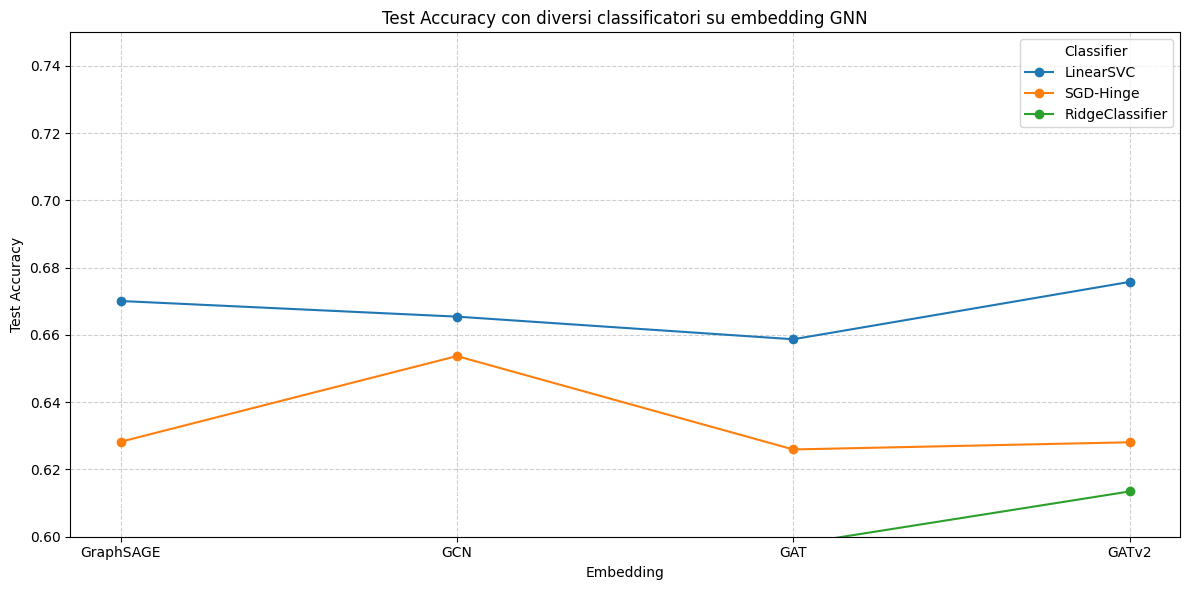

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.transforms import ToUndirected

# === 1. Carica tutti gli embedding salvati ===
embeddings = {
    "GraphSAGE": torch.load("sage_node_embeddings.pt"),
    "GCN": torch.load("gcn_node_embeddings.pt"),
    "GAT": torch.load("gat_node_embeddings.pt"),
    "GATv2": torch.load("gatv2_node_embeddings.pt"),
}

# === 2. Carica indici e label ===
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
split_idx = dataset.get_idx_split()
labels = dataset[0].y.squeeze().numpy()

train_idx = split_idx['train'].numpy()
val_idx = split_idx['valid'].numpy()
test_idx = split_idx['test'].numpy()

# === 3. Definisci classificatori alternativi ===
classifiers = {
    "LinearSVC": LinearSVC(max_iter=5000),
    "SGD-Hinge": SGDClassifier(loss='hinge', max_iter=1000),
    "RidgeClassifier": RidgeClassifier(),
}

# === 4. Valutazione
results = []

for model_name, emb in embeddings.items():
    X = emb.numpy()
    for clf_name, clf in classifiers.items():
        print(f"🔍 {clf_name} su {model_name}")
        clf.fit(X[train_idx], labels[train_idx])
        val_acc = accuracy_score(labels[val_idx], clf.predict(X[val_idx]))
        test_acc = accuracy_score(labels[test_idx], clf.predict(X[test_idx]))
        results.append((model_name, clf_name, val_acc, test_acc))

# === 5. Salva e mostra tabella finale
df = pd.DataFrame(results, columns=["Embedding", "Classifier", "Val Acc", "Test Acc"])
df.to_csv("svm_variants_results.csv", index=False)
print("\n📊 Risultati completi:")
print(df)

# === 6. Plot
plt.figure(figsize=(12, 6))
for clf_name in df["Classifier"].unique():
    subset = df[df["Classifier"] == clf_name]
    plt.plot(subset["Embedding"], subset["Test Acc"], marker='o', label=clf_name)

plt.title("Test Accuracy con diversi classificatori su embedding GNN")
plt.xlabel("Embedding")
plt.ylabel("Test Accuracy")
plt.ylim(0.60, 0.75)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Classifier")
plt.tight_layout()
plt.savefig("svm_variants_plot.png")
plt.show()


## Analisi della Largest Connected Component (LCC)

I grafi reali, come quello del dataset `ogbn-arxiv`, possono essere **sparsi** e contenere **componenti disconnesse**. Per molte tecniche (es. Metric Learning, visualizzazione, clustering), è preferibile lavorare sulla **Largest Connected Component (LCC)**, ovvero il sottografo connesso più grande, che rappresenta la parte più strutturata e informativa del grafo.

###  In questa sezione:
- Convertiamo il grafo in una rappresentazione `networkx` per analizzare la connettività.
- Estraiamo la LCC e costruiamo un nuovo oggetto `Data` PyTorch Geometric filtrato solo su questa componente.
- Visualizziamo statistiche chiave:
  - Numero totale di nodi nel grafo originale.
  - Numero di nodi e archi nella LCC.

> Isolare la LCC aiuta a garantire che i metodi successivi (es. triplet mining o GNN locali) lavorino su un sottografo **ben connesso** e rappresentativo.


In [2]:
import torch
import pandas as pd
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.transforms import ToUndirected
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data
import networkx as nx
from rich.console import Console
from rich.table import Table
from rich import box

console = Console()

def filter_data_by_mask(data, mask):
    node_idx = mask.nonzero(as_tuple=False).view(-1)
    mapping = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(node_idx)}

    x = data.x[node_idx]
    y = data.y[node_idx]

    edge_mask = mask[data.edge_index[0]] & mask[data.edge_index[1]]
    edge_index = data.edge_index[:, edge_mask]
    edge_index = torch.stack([
        torch.tensor([mapping[idx.item()] for idx in edge_index[0]]),
        torch.tensor([mapping[idx.item()] for idx in edge_index[1]])
    ])

    return Data(x=x, edge_index=edge_index, y=y)

def main():
    console.rule("[bold blue]🔍 Analisi Largest Connected Component")

    dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
    data = dataset[0]

    console.print(f"📦 Numero totale di nodi: [bold]{data.num_nodes}[/bold]")
    G = to_networkx(data, to_undirected=True)

    console.print("🔄 Calcolo componenti connesse...")
    components = list(nx.connected_components(G))
    largest_component = max(components, key=len)

    largest_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    largest_mask[list(largest_component)] = True

    filtered_data = filter_data_by_mask(data, largest_mask)

    # Tabella riassuntiva con Rich
    table = Table(title="📊 Largest Connected Component", box=box.SIMPLE)
    table.add_column("Statistica", style="cyan", justify="right")
    table.add_column("Valore", style="bold")

    table.add_row("Numero totale nodi", str(data.num_nodes))
    table.add_row("Nodi nella componente", str(filtered_data.num_nodes))
    table.add_row("Archi nella componente", str(filtered_data.edge_index.size(1)))

    console.print(table)

if __name__ == "__main__":
    main()


───────────────────────────────────── 🔍 Analisi Largest Connected Component ──────────────────────────────────────

📦 Numero totale di nodi: 169343

🔄 Calcolo componenti connesse...

   📊 Largest Connected Component   
                                    
              Statistica   Valore   
 ────────────────────────────────── 
      Numero totale nodi   169343   
   Nodi nella componente   169343   
  Archi nella componente   2315598 

## Analisi dei nodi centrali tramite PageRank

Dopo aver isolato la **Largest Connected Component** (LCC) del grafo `ogbn-arxiv`, ci concentriamo sull’analisi della **centralità dei nodi** utilizzando l’algoritmo **PageRank**, introdotto da Google per valutare l'importanza delle pagine web, ma ampiamente usato in ambito grafi.

###  Obiettivo
Identificare i nodi più centrali (e potenzialmente più influenti) nella struttura del grafo:
- Un nodo con alto PageRank è fortemente connesso a **nodi a loro volta influenti**.
- Può rappresentare un paper particolarmente citato o autorevole nel grafo delle citazioni scientifiche.

###  Procedura
1. Convertiamo il grafo in un oggetto `networkx`.
2. Estraiamo la **componente connessa più grande**.
3. Calcoliamo il **PageRank** su questo sottografo.
4. Visualizziamo i **top 10 nodi** con i punteggi più alti in una tabella ordinata.
5. Riportiamo statistiche generali sul grafo filtrato (nodi e archi).

> L’analisi della centralità sarà utile nelle fasi successive di **Metric Learning** per selezionare nodi di riferimento (anchor) significativi.


In [3]:
import torch
import pandas as pd
import networkx as nx
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich import box

from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.transforms import ToUndirected
from torch_geometric.utils import to_networkx

# === Setup Rich ===
console = Console()

# === 1. Carica dataset ===
console.print("📦 [bold]Caricamento del dataset ogbn-arxiv...[/bold]")
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
data = dataset[0]

# === 2. Conversione a grafo undirected ===
console.print("🔁 [bold]Conversione in grafo NetworkX (undirected)...[/bold]")
G = to_networkx(data, to_undirected=True)

# === 3. Estrazione della largest weakly connected component ===
console.print("📊 [bold]Calcolo largest connected component...[/bold]")
components = list(nx.connected_components(G))
largest_component = max(components, key=len)
G_sub = G.subgraph(largest_component).copy()

# === 4. Calcolo del PageRank ===
console.print("🧠 [bold]Calcolo del PageRank...[/bold] (può richiedere qualche secondo)")
pagerank_scores = nx.pagerank(G_sub)

# === 5. Top 10 nodi con PageRank più alto ===
top_nodes = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:10]

# === 6. Visualizzazione con Rich ===
console.print("\n✨ [bold magenta]Top 10 nodi per PageRank nella largest connected component[/bold magenta]")

table = Table(title="📈 Top 10 PageRank", box=box.SIMPLE_HEAVY)
table.add_column("Rank", justify="right", style="cyan")
table.add_column("Node ID", justify="right", style="green")
table.add_column("PageRank Score", justify="right", style="yellow")

for i, (node_id, score) in enumerate(top_nodes, start=1):
    table.add_row(str(i), str(node_id), f"{score:.6e}")

console.print(table)

# === 7. Statistiche generali ===
console.print(
    Panel.fit(
        f"[bold]Nodi totali nella componente:[/bold] {len(G_sub)}\n"
        f"[bold]Archi totali nella componente:[/bold] {G_sub.number_of_edges()}",
        title="📌 [i]Largest Component Info[/i]",
        border_style="bright_blue"
    )
)


📦 Caricamento del dataset ogbn-arxiv...

🔁 Conversione in grafo NetworkX (undirected)...

📊 Calcolo largest connected component...

🧠 Calcolo del PageRank... (può richiedere qualche secondo)

✨ Top 10 nodi per PageRank nella largest connected component

        📈 Top 10 PageRank         
                                   
  Rank   Node ID   PageRank Score  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
     1      1353     3.240089e-03  
     2     67166     2.589161e-03  
     3     25208     1.973960e-03  
     4    106699     1.133126e-03  
     5     69794     1.035317e-03  
     6    115359     8.767053e-04  
     7     93649     8.614382e-04  
     8     94874     8.405713e-04  
     9     22035     8.277438e-04  
    10    133376     7.222428e-04 

╭────── 📌 Largest Component Info ───────╮
│ Nodi totali nella componente: 169343   │
│ Archi totali nella componente: 1157799 │
╰────────────────────────────────────────╯

📚 Calcolo PageRank...
🔗 Aggiunta feature PageRank al tensor x


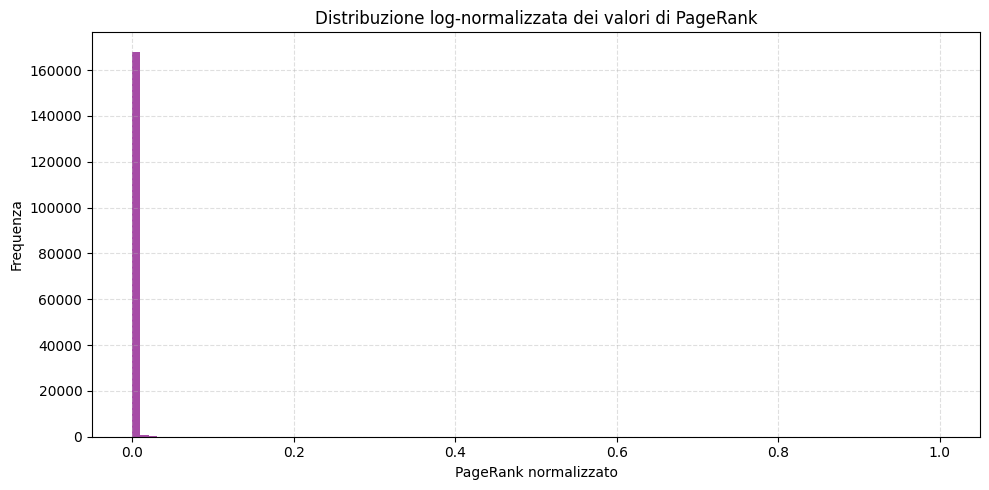

✅ Dataset con PageRank salvato come 'ogbn_arxiv_with_pagerank.pt'


In [4]:
import torch
import numpy as np
import networkx as nx
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.transforms import ToUndirected
from torch_geometric.utils import to_networkx
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# === 1. Carica il dataset ===
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
data = dataset[0]
G = to_networkx(data, to_undirected=True)

# === 2. Calcolo PageRank su tutto il grafo ===
print("📚 Calcolo PageRank...")
pagerank_dict = nx.pagerank(G, alpha=0.85)
pagerank_values = np.array([pagerank_dict[i] for i in range(data.num_nodes)])

# === 3. Log-transform + normalizzazione ===
pagerank_values_log = np.log1p(pagerank_values)  # log(1 + x)
scaler = MinMaxScaler()
pagerank_norm_log = scaler.fit_transform(pagerank_values_log.reshape(-1, 1))
pagerank_tensor = torch.tensor(pagerank_norm_log, dtype=torch.float32)

# === 4. Aggiunta del PageRank normalizzato come feature extra ===
print("🔗 Aggiunta feature PageRank al tensor x")
data.x = torch.cat([data.x, pagerank_tensor], dim=1)

# === 5. Istogramma distribuzione (post-log) ===
plt.figure(figsize=(10, 5))
plt.hist(pagerank_norm_log, bins=100, color="purple", alpha=0.7)
plt.title("Distribuzione log-normalizzata dei valori di PageRank")
plt.xlabel("PageRank normalizzato")
plt.ylabel("Frequenza")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# === 6. Salva il dataset modificato ===
torch.save(data, "ogbn_arxiv_with_pagerank.pt")
print("✅ Dataset con PageRank salvato come 'ogbn_arxiv_with_pagerank.pt'")


In [5]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.transforms import ToUndirected
from torch_geometric.utils import to_networkx
import networkx as nx

# === 1. Carica dataset e grafo ===
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
data = dataset[0]
G = to_networkx(data, to_undirected=True)

# === 2. Trova largest connected component ===
components = list(nx.connected_components(G))
largest_component = max(components, key=len)
G_lcc = G.subgraph(largest_component).copy()

# === 3. Calcola PageRank ===
pagerank_dict = nx.pagerank(G_lcc, alpha=0.85)

# === 4. Normalizza PageRank con MinMaxScaler ===
node_ids = list(pagerank_dict.keys())
pagerank_values = np.array(list(pagerank_dict.values())).reshape(-1, 1)
scaler = MinMaxScaler()
pagerank_norm = scaler.fit_transform(pagerank_values)

# === 5. Aggiungi PageRank normalizzato come nuova feature ===
# Default: 0 per nodi fuori dalla largest connected component
pagerank_feature = torch.zeros(data.num_nodes, 1)
for idx, node_id in enumerate(node_ids):
    pagerank_feature[node_id] = torch.tensor(pagerank_norm[idx])

# === 6. Concatena al feature tensor originale ===
data.x = torch.cat([data.x, pagerank_feature], dim=1)
print(f"✅ Nuova dimensione delle feature: {data.x.size()}")


✅ Nuova dimensione delle feature: torch.Size([169343, 129])


Qua addestriamo gcn con pagerank come feature aggiuntiva

In [27]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from torch_geometric.transforms import ToUndirected
import os

# === 1. Carica dataset modificato con PageRank ===
data = torch.load("ogbn_arxiv_with_pagerank.pt")
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv')
split_idx = dataset.get_idx_split()
evaluator = Evaluator(name='ogbn-arxiv')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
train_idx = split_idx['train'].to(device)
val_idx = split_idx['valid'].to(device)
test_idx = split_idx['test'].to(device)

# === 2. Modello aggiornato GCN con input +1 feature ===
class GCNWithPageRank(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

model_path = "best_gcn_pagerank.pt"
checkpoint_path = "checkpoint_gcn_pagerank.pth"
log_path = "training_log_gcn_pagerank.csv"
model = GCNWithPageRank(data.num_features, 128, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# === 3. Resume training se esiste checkpoint ===
start_epoch = 1
best_val_acc = 0.0
patience_counter = 0

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_acc = checkpoint['best_val_acc']
    patience_counter = checkpoint['patience_counter']
    print(f"🔁 Resume training da epoch {start_epoch}, best val acc: {best_val_acc:.4f}")
else:
    print("🆕 Inizio nuovo training...")

# === 4. Funzioni di training e valutazione ===
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx].squeeze())
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate():
    model.eval()
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=-1)
    return (
        evaluator.eval({'y_true': data.y[train_idx], 'y_pred': y_pred[train_idx].unsqueeze(1)})['acc'],
        evaluator.eval({'y_true': data.y[val_idx], 'y_pred': y_pred[val_idx].unsqueeze(1)})['acc'],
        evaluator.eval({'y_true': data.y[test_idx], 'y_pred': y_pred[test_idx].unsqueeze(1)})['acc'],
    )

# === 5. Training loop con Early Stopping e log ===
early_stop_patience = 10
for epoch in range(start_epoch, start_epoch + 100):
    loss = train()
    if epoch % 10 == 0:
        train_acc, val_acc, test_acc = evaluate()
        print(f"[Epoch {epoch:03d}] Loss: {loss:.4f} | Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f}")
        with open(log_path, "a") as f:
            f.write(f"{epoch},{loss:.4f},{train_acc:.4f},{val_acc:.4f},{test_acc:.4f}\n")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
            print("💾 Nuovo best model salvato")
        else:
            patience_counter += 1
            print(f"⏳ Early stopping counter: {patience_counter}/{early_stop_patience}")

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
            'patience_counter': patience_counter
        }, checkpoint_path)

        if patience_counter >= early_stop_patience:
            print("🛑 Early stopping attivato!")
            break

# === 6. Salva embedding finali ===
model.load_state_dict(torch.load(model_path))
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index).cpu()

torch.save(embeddings, "gcn_pagerank_node_embeddings.pt")
print("✅ Embedding salvati in 'gcn_pagerank_node_embeddings.pt'")



🔁 Resume training da epoch 501, best val acc: 0.7047
[Epoch 510] Loss: 0.9682 | Train: 0.7111 | Val: 0.7047 | Test: 0.6946
⏳ Early stopping counter: 1/10
[Epoch 520] Loss: 0.9660 | Train: 0.7115 | Val: 0.7045 | Test: 0.6916
⏳ Early stopping counter: 2/10
[Epoch 530] Loss: 0.9640 | Train: 0.7121 | Val: 0.7050 | Test: 0.6938
💾 Nuovo best model salvato
[Epoch 540] Loss: 0.9620 | Train: 0.7125 | Val: 0.7048 | Test: 0.6918
⏳ Early stopping counter: 1/10
[Epoch 550] Loss: 0.9600 | Train: 0.7130 | Val: 0.7051 | Test: 0.6938
💾 Nuovo best model salvato
[Epoch 560] Loss: 0.9581 | Train: 0.7133 | Val: 0.7058 | Test: 0.6936
💾 Nuovo best model salvato
[Epoch 570] Loss: 0.9562 | Train: 0.7139 | Val: 0.7060 | Test: 0.6949
💾 Nuovo best model salvato
[Epoch 580] Loss: 0.9543 | Train: 0.7142 | Val: 0.7055 | Test: 0.6927
⏳ Early stopping counter: 1/10
[Epoch 590] Loss: 0.9524 | Train: 0.7147 | Val: 0.7059 | Test: 0.6949
⏳ Early stopping counter: 2/10
[Epoch 600] Loss: 0.9506 | Train: 0.7151 | Val: 0.7062

In [7]:
import torch
import pandas as pd
import networkx as nx
from rich.console import Console
from rich.table import Table
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.transforms import ToUndirected
from torch_geometric.utils import to_networkx

# === 1. Caricamento del dataset ===
console = Console()
console.print("📦 [bold]Caricamento del dataset ogbn-arxiv...[/bold]")
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
data = dataset[0]

# === 2. Conversione in grafo NetworkX ===
console.print("🔁 [bold]Conversione in grafo NetworkX (undirected)...[/bold]")
G = to_networkx(data, to_undirected=True)

# === 3. Calcolo delle feature strutturali ===
console.print("🧠 [bold]Calcolo delle feature strutturali (Degree, Clustering)...[/bold]")
degree_dict = dict(G.degree())
clustering_dict = nx.clustering(G)

# === 4. Costruzione del DataFrame ===
node_ids = list(degree_dict.keys())
df_structural = pd.DataFrame({
    "Node ID": node_ids,
    "Degree": [degree_dict[n] for n in node_ids],
    "ClusteringCoeff": [clustering_dict[n] for n in node_ids],
})

# === 5. Visualizzazione con Rich (primi 20 nodi) ===
console.print("\n📊 [bold magenta]Anteprima delle feature strutturali (primi 20 nodi):[/bold magenta]\n")
table = Table(show_header=True, header_style="bold cyan")
table.add_column("Node ID", justify="right")
table.add_column("Degree", justify="right")
table.add_column("ClusteringCoeff", justify="right")

for _, row in df_structural.head(20).iterrows():
    table.add_row(str(row["Node ID"]), str(row["Degree"]), f"{row['ClusteringCoeff']:.4f}")

console.print(table)


📦 Caricamento del dataset ogbn-arxiv...

🔁 Conversione in grafo NetworkX (undirected)...

🧠 Calcolo delle feature strutturali (Degree, Clustering)...

📊 Anteprima delle feature strutturali (primi 20 nodi):

┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Node ID ┃ Degree ┃ ClusteringCoeff ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│     0.0 │  291.0 │          0.0344 │
│     1.0 │    2.0 │          1.0000 │
│     2.0 │   14.0 │          0.2088 │
│     3.0 │    2.0 │          1.0000 │
│     4.0 │    6.0 │          0.8000 │
│     5.0 │    1.0 │          0.0000 │
│     6.0 │    8.0 │          0.0000 │
│     7.0 │    2.0 │          1.0000 │
│     8.0 │    1.0 │          0.0000 │
│     9.0 │    3.0 │          0.6667 │
│    10.0 │    5.0 │          0.2000 │
│    11.0 │    5.0 │          0.6000 │
│    12.0 │    7.0 │          0.4762 │
│    13.0 │    5.0 │          0.4000 │
│    14.0 │    7.0 │          0.0952 │
│    15.0 │   11.0 │          0.2909 │
│    16.0 │    5.0 │          0.3000 │
│    17.0 │   21.0 │          0.0476 │
│    18.0 │    1.0 │          0.0000 │
│    19.0 │    2.0 │          0.0000 │
└─────────┴────────┴─────────────────┘

## Integrazione di Feature Strutturali: Grado e Clustering Coefficiente

Per arricchire la rappresentazione dei nodi, calcoliamo e integriamo **feature strutturali del grafo** che non sono esplicitamente incluse nelle feature originarie. In particolare, aggiungiamo:
- **Grado del nodo**: il numero di archi incidenti.
- **Coefficiente di clustering locale**: misura quanto i vicini di un nodo tendono a formare triangoli (densità locale).

Includere informazioni **topologiche** che aiutino le GNN (o altri modelli) a:
- Distinguere nodi periferici da quelli centrali.
- Sfruttare la **struttura locale** per inferenze più robuste.

1. Convertiamo il grafo in `networkx` per calcolare:
   - Il **grado** tramite `G.degree()`.
   - Il **clustering coefficient** con `nx.clustering()`.
2. Normalizziamo entrambe le feature con **Min-Max Scaling**.
3. Le convertiamo in tensori PyTorch e le **concateniamo** alle feature originali di `data.x`.
4. Salviamo il nuovo oggetto `Data` nel file `ogbn_arxiv_with_structural.pt`.

> Queste feature strutturali verranno poi usate in modelli GNN o Metric Learning, permettendo un confronto con versioni basate solo su feature originali.


In [8]:
import torch
import pandas as pd
import networkx as nx
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.transforms import ToUndirected
from torch_geometric.utils import to_networkx
from sklearn.preprocessing import MinMaxScaler

# === 1. Carica dataset ===
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
data = dataset[0]

# === 2. Conversione in grafo NetworkX ===
G = to_networkx(data, to_undirected=True)

# === 3. Calcolo delle feature strutturali ===
degree_dict = dict(G.degree())
clustering_dict = nx.clustering(G)

# === 4. Costruzione DataFrame delle feature ===
node_ids = list(degree_dict.keys())
df_structural = pd.DataFrame({
    "Node ID": node_ids,
    "Degree": [degree_dict[n] for n in node_ids],
    "ClusteringCoeff": [clustering_dict[n] for n in node_ids],
})

# === 5. Normalizzazione (Min-Max) ===
scaler = MinMaxScaler()
df_structural[["Degree", "ClusteringCoeff"]] = scaler.fit_transform(df_structural[["Degree", "ClusteringCoeff"]])

# === 6. Conversione in tensori torch ===
degree_tensor = torch.tensor(df_structural["Degree"].values, dtype=torch.float).view(-1, 1)
clustering_tensor = torch.tensor(df_structural["ClusteringCoeff"].values, dtype=torch.float).view(-1, 1)

# === 7. Concatenazione con data.x ===
data.x = torch.cat([data.x, degree_tensor, clustering_tensor], dim=1)

# === 8. Salva il nuovo oggetto data ===
torch.save(data, "ogbn_arxiv_with_structural.pt") 

# Output per conferma
data.x.shape


torch.Size([169343, 130])

## 🔍 Addestramento con GraphSAGE su ogbn-arxiv (feature strutturali)

In questa sezione eseguiamo l'addestramento di un modello GraphSAGE sul dataset ogbn-arxiv, arricchito con feature strutturali (es. degree, centralità, ecc.), salvato in precedenza su disco. Il processo è dotato di:

- ✅ Resume da checkpoint automatico
- ✅ Salvataggio best model
- ✅ Logging continuo su file CSV
- ✅ Early stopping su accuratezza di validazione
- ✅ Salvataggio degli embedding finali dei nodi

Il modello usa una semplice architettura a 2 layer `SAGEConv`, con ottimizzazione tramite `Adam` e `cross-entropy`. I log possono essere utilizzati successivamente per generare grafici di andamento loss/accuracy.


In [25]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from torch_geometric.transforms import ToUndirected
import os
import csv

# === 1. Caricamento dataset con feature strutturali ===
data = torch.load("ogbn_arxiv_with_structural.pt")

# === 2. Setup split ed evaluator ===
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv')
split_idx = dataset.get_idx_split()
evaluator = Evaluator(name='ogbn-arxiv')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
train_idx = split_idx['train'].to(device)
val_idx = split_idx['valid'].to(device)
test_idx = split_idx['test'].to(device)

# === 3. Definizione del modello GraphSAGE ===
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# === 4. Inizializzazione ===
model_path = "best_sage_structural.pt"
checkpoint_path = "checkpoint_sage_structural.pth"
log_path = "training_log_sage_structural.csv"
model = GraphSAGE(data.x.size(1), 128, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# === 5. Resume da checkpoint se esiste ===
start_epoch = 1
best_val_acc = 0.0
patience_counter = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_acc = checkpoint['best_val_acc']
    patience_counter = checkpoint['patience_counter']
    print(f"🔁 Resume training da epoch {start_epoch}, best val acc: {best_val_acc:.4f}")
else:
    print("🆕 Inizio nuovo training...")
    with open(log_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "loss", "train_acc", "val_acc", "test_acc"])

# === 6. Funzioni training e valutazione ===
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx].squeeze())
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate():
    model.eval()
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=-1)
    return (
        evaluator.eval({'y_true': data.y[train_idx], 'y_pred': y_pred[train_idx].unsqueeze(1)})['acc'],
        evaluator.eval({'y_true': data.y[val_idx], 'y_pred': y_pred[val_idx].unsqueeze(1)})['acc'],
        evaluator.eval({'y_true': data.y[test_idx], 'y_pred': y_pred[test_idx].unsqueeze(1)})['acc'],
    )

# === 7. Training loop con early stopping ===
early_stop_patience = 10
for epoch in range(start_epoch, start_epoch + 100):
    loss = train()
    if epoch % 10 == 0:
        train_acc, val_acc, test_acc = evaluate()
        print(f"[Epoch {epoch:03d}] Loss: {loss:.4f} | Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f}")

        with open(log_path, "a", newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch, f"{loss:.4f}", f"{train_acc:.4f}", f"{val_acc:.4f}", f"{test_acc:.4f}"])

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
            print("💾 Nuovo best model salvato")
        else:
            patience_counter += 1
            print(f"⏳ Early stopping counter: {patience_counter}/{early_stop_patience}")

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
            'patience_counter': patience_counter
        }, checkpoint_path)

        if patience_counter >= early_stop_patience:
            print("🛑 Early stopping attivato!")
            break

# === 8. Estrazione embedding finale ===
model.load_state_dict(torch.load(model_path))
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index).cpu()
torch.save(embeddings, "sage_structural_embeddings.pt")
print("✅ Embedding salvati in 'sage_structural_embeddings.pt'")

🔁 Resume training da epoch 501, best val acc: 0.7020
[Epoch 510] Loss: 0.8936 | Train: 0.7242 | Val: 0.7000 | Test: 0.6840
⏳ Early stopping counter: 1/10
[Epoch 520] Loss: 0.8938 | Train: 0.7242 | Val: 0.6997 | Test: 0.6856
⏳ Early stopping counter: 2/10
[Epoch 530] Loss: 0.8882 | Train: 0.7257 | Val: 0.7031 | Test: 0.6909
💾 Nuovo best model salvato
[Epoch 540] Loss: 0.8857 | Train: 0.7263 | Val: 0.7014 | Test: 0.6875
⏳ Early stopping counter: 1/10
[Epoch 550] Loss: 0.8839 | Train: 0.7262 | Val: 0.6970 | Test: 0.6798
⏳ Early stopping counter: 2/10
[Epoch 560] Loss: 0.8819 | Train: 0.7271 | Val: 0.7027 | Test: 0.6953
⏳ Early stopping counter: 3/10
[Epoch 570] Loss: 0.8778 | Train: 0.7285 | Val: 0.7029 | Test: 0.6912
⏳ Early stopping counter: 4/10
[Epoch 580] Loss: 0.8754 | Train: 0.7291 | Val: 0.7019 | Test: 0.6874
⏳ Early stopping counter: 5/10
[Epoch 590] Loss: 0.8729 | Train: 0.7298 | Val: 0.7020 | Test: 0.6874
⏳ Early stopping counter: 6/10
[Epoch 600] Loss: 0.8704 | Train: 0.7302 |

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from torch_geometric.transforms import ToUndirected
import os
import csv

# === 1. Caricamento dataset con feature strutturali ===
data = torch.load("ogbn_arxiv_with_structural.pt")

# === 2. Setup split ed evaluator ===
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv')
split_idx = dataset.get_idx_split()
evaluator = Evaluator(name='ogbn-arxiv')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
train_idx = split_idx['train'].to(device)
val_idx = split_idx['valid'].to(device)
test_idx = split_idx['test'].to(device)

# === 3. Deep GraphSAGE ===
class DeepGraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=4, dropout=0.3):
        super().__init__()
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()

        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.norms.append(nn.BatchNorm1d(hidden_channels))

        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
            self.norms.append(nn.BatchNorm1d(hidden_channels))

        self.convs.append(SAGEConv(hidden_channels, out_channels))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        for conv, norm in zip(self.convs[:-1], self.norms):
            x = conv(x, edge_index)
            x = norm(x)
            x = F.relu(x)
            x = self.dropout(x)
        x = self.convs[-1](x, edge_index)
        return x

# === 4. Inizializzazione ===
model_path = "best_deep_sage_structural.pt"
checkpoint_path = "checkpoint_deep_sage_structural.pth"
log_path = "training_log_deep_sage_structural.csv"
model = DeepGraphSAGE(data.x.size(1), 128, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

start_epoch = 1
best_val_acc = 0.0
patience_counter = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_acc = checkpoint['best_val_acc']
    patience_counter = checkpoint['patience_counter']
    print(f"\U0001f501 Resume training da epoch {start_epoch}, best val acc: {best_val_acc:.4f}")
else:
    print("\U0001f195 Inizio nuovo training...")
    with open(log_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "loss", "train_acc", "val_acc", "test_acc"])

# === 5. Funzioni training e valutazione ===
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx].squeeze())
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate():
    model.eval()
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=-1)
    return (
        evaluator.eval({'y_true': data.y[train_idx], 'y_pred': y_pred[train_idx].unsqueeze(1)})['acc'],
        evaluator.eval({'y_true': data.y[val_idx], 'y_pred': y_pred[val_idx].unsqueeze(1)})['acc'],
        evaluator.eval({'y_true': data.y[test_idx], 'y_pred': y_pred[test_idx].unsqueeze(1)})['acc'],
    )

# === 6. Training loop con early stopping ===
early_stop_patience = 10
for epoch in range(start_epoch, start_epoch + 100):
    loss = train()
    if epoch % 10 == 0:
        train_acc, val_acc, test_acc = evaluate()
        print(f"[Epoch {epoch:03d}] Loss: {loss:.4f} | Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f}")

        with open(log_path, "a", newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch, f"{loss:.4f}", f"{train_acc:.4f}", f"{val_acc:.4f}", f"{test_acc:.4f}"])

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
            print("\U0001f4be Nuovo best model salvato")
        else:
            patience_counter += 1
            print(f"\u23f3 Early stopping counter: {patience_counter}/{early_stop_patience}")

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
            'patience_counter': patience_counter
        }, checkpoint_path)

        if patience_counter >= early_stop_patience:
            print("\U0001f6d1 Early stopping attivato!")
            break

# === 7. Salvataggio embedding finale ===
model.load_state_dict(torch.load(model_path))
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index).cpu()
torch.save(embeddings, "deep_sage_structural_embeddings.pt")
print("\u2705 Embedding salvati in 'deep_sage_structural_embeddings.pt'")


🔁 Resume training da epoch 201, best val acc: 0.7234
[Epoch 210] Loss: 0.7660 | Train: 0.7694 | Val: 0.7222 | Test: 0.7113
⏳ Early stopping counter: 2/10
[Epoch 220] Loss: 0.7578 | Train: 0.7798 | Val: 0.7281 | Test: 0.7188
💾 Nuovo best model salvato
[Epoch 230] Loss: 0.7487 | Train: 0.7820 | Val: 0.7290 | Test: 0.7165
💾 Nuovo best model salvato
[Epoch 240] Loss: 0.7399 | Train: 0.7777 | Val: 0.7249 | Test: 0.7166
⏳ Early stopping counter: 1/10
[Epoch 250] Loss: 0.7372 | Train: 0.7841 | Val: 0.7280 | Test: 0.7205
⏳ Early stopping counter: 2/10
[Epoch 260] Loss: 0.7234 | Train: 0.7881 | Val: 0.7194 | Test: 0.6966
⏳ Early stopping counter: 3/10
[Epoch 270] Loss: 0.7175 | Train: 0.7854 | Val: 0.7177 | Test: 0.6980
⏳ Early stopping counter: 4/10
[Epoch 280] Loss: 0.7178 | Train: 0.7822 | Val: 0.7212 | Test: 0.7129
⏳ Early stopping counter: 5/10
[Epoch 290] Loss: 0.7078 | Train: 0.7945 | Val: 0.7218 | Test: 0.6996
⏳ Early stopping counter: 6/10
[Epoch 300] Loss: 0.6986 | Train: 0.7983 | Val

## 🎨 Visualizzazione della Distribuzione Strutturale dei Nodi

In questa sezione viene generato uno **scatter plot 2D** delle feature strutturali associate ai nodi del grafo `ogbn-arxiv`, con l’obiettivo di esplorare visivamente la relazione tra:

- 📏 **Grado del nodo** (degree)
- 🔗 **Coefficiente di clustering** (clustering coefficient)

Entrambe le feature sono **normalizzate** e rappresentano proprietà topologiche locali del grafo. Il colore dei punti è determinato dalla label di classificazione del nodo.

### 🔍 Dettagli tecnici:
- Se il file `structural_scatter.png` esiste già, viene mostrato direttamente.
- In caso contrario, viene generato utilizzando un **campione casuale di 5000 nodi** per garantire chiarezza visiva.
- Il grafico aiuta a valutare se certe classi occupano regioni strutturali distinte nel grafo.

⚠️ Il plot è salvato come file `.png` ad alta risoluzione per eventuale uso in report, poster o tesi.


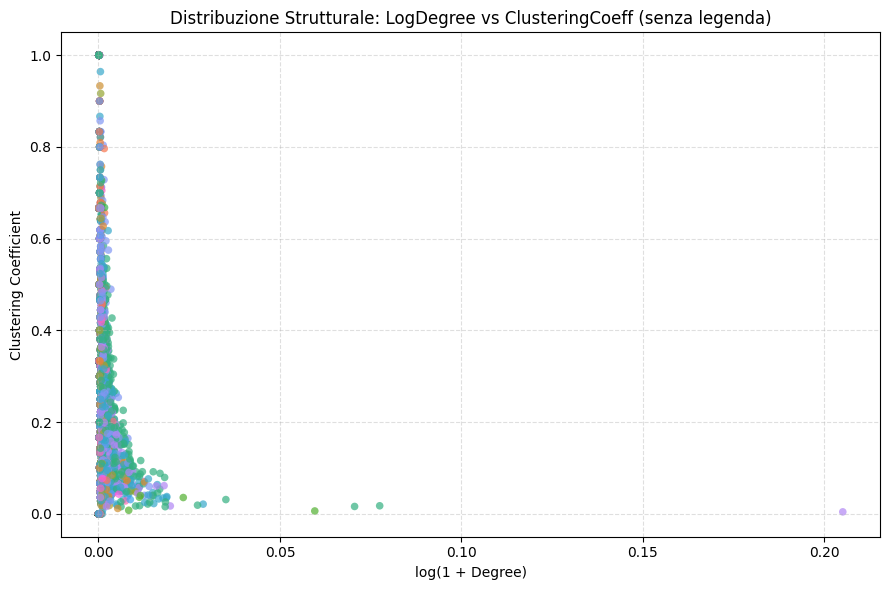

In [33]:
import os
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.transforms import ToUndirected

# === 1. Parametri ===
img_path = "structural_scatter_clean.png"
sample_size = 8000
dpi_value = 150

# === 2. Caricamento dati ===
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
data = torch.load("ogbn_arxiv_with_structural.pt")
degree = data.x[:, -2].cpu().numpy()
clustering = data.x[:, -1].cpu().numpy()
labels = data.y.squeeze().cpu().numpy()

# === 3. DataFrame e log-scaling ===
df = pd.DataFrame({
    "Degree": degree,
    "ClusteringCoeff": clustering,
    "Label": labels
}).sample(sample_size, random_state=42)

df["LogDegree"] = np.log1p(df["Degree"])  # log(1 + x)

# === 4. Plot migliorato (senza legenda) ===
plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=df,
    x="LogDegree", y="ClusteringCoeff", hue="Label",
    palette="husl",  # colori vivaci e distinti
    s=30, alpha=0.7, linewidth=0, legend=False
)

plt.title("Distribuzione Strutturale: LogDegree vs ClusteringCoeff (senza legenda)")
plt.xlabel("log(1 + Degree)")
plt.ylabel("Clustering Coefficient")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()

# === 5. Salva e mostra ===
plt.savefig(img_path, dpi=dpi_value)
plt.show()


## 🧭 Analisi 3D delle Feature Strutturali su ogbn-arxiv

### 📌 Obiettivo

In questa sezione costruiamo una **visualizzazione tridimensionale** delle principali **feature strutturali** del grafo `ogbn-arxiv`. L’obiettivo è esplorare se caratteristiche topologiche come:

- **Degree** (numero di vicini)
- **Clustering Coefficient** (densità locale)
- **PageRank** (importanza centrale)

presentano strutture informative che possano distinguere visivamente i nodi in base alla loro **classe di appartenenza**.

---

### 🧩 Codice Eseguito

1. Caricamento del dataset `ogbn-arxiv` e sua conversione in un grafo `networkx`.
2. Calcolo delle tre feature topologiche per un **campione di 10.000 nodi**:
   - `degree`, `clustering coefficient`, `pagerank`.
3. Normalizzazione tramite `MinMaxScaler`.
4. Costruzione di un **grafico scatter 3D** con colorazione basata sulle etichette di classe.
5. Salvataggio del grafico come immagine `.png`.

---

### 🖼️ Output del Grafico

Nel grafico visualizzato si osserva:

- Una **concentrazione estrema di nodi** nella zona inferiore del cubo (vicino a `(0, 0, 0)`).
- **Pochissimi outlier** distribuiti lontano da tale zona, spesso singoli o isolati.
- Una generale **mancanza di distribuzione uniforme** o cluster separabili a occhio.

---

### 🔍 Commento all’Output

La forma della distribuzione suggerisce che:

- La **maggioranza dei nodi ha bassa connettività e centralità**:
  - basso degree,
  - basso clustering coefficient,
  - basso pagerank.
- Pochi nodi fungono da **hub strutturali** nel grafo.
- Questo pattern è tipico di **grafi "scale-free"** come quelli delle citazioni scientifiche (in cui pochi articoli sono molto citati e molti pochissimo).

---

### 💡 Implicazioni per la Modellazione

- Le **feature strutturali hanno distribuzione fortemente sbilanciata**, e potrebbero **non essere direttamente informative** se non trasformate (es. `log(1 + x)`, `z-score`).
- Una rete neurale potrebbe **faticare ad apprendere pattern** da questi valori grezzi.
- È consigliato esplorare:
  - **t-SNE o PCA** per ridurre dimensionalità e visualizzare cluster.
  - **log-scaling** per "distendere" la coda della distribuzione.
  - L’uso di queste feature in modelli **ibridi** (feature strutturali + GNN) per valutare impatto predittivo.

---

### ✅ Conclusione

La visualizzazione 3D delle feature topologiche offre uno sguardo interessante sulla **struttura intrinseca** del grafo. Tuttavia, l’output mostra che tali feature necessitano di una **trasformazione intelligente** per diventare davvero informative nel contesto di classificazione dei nodi.


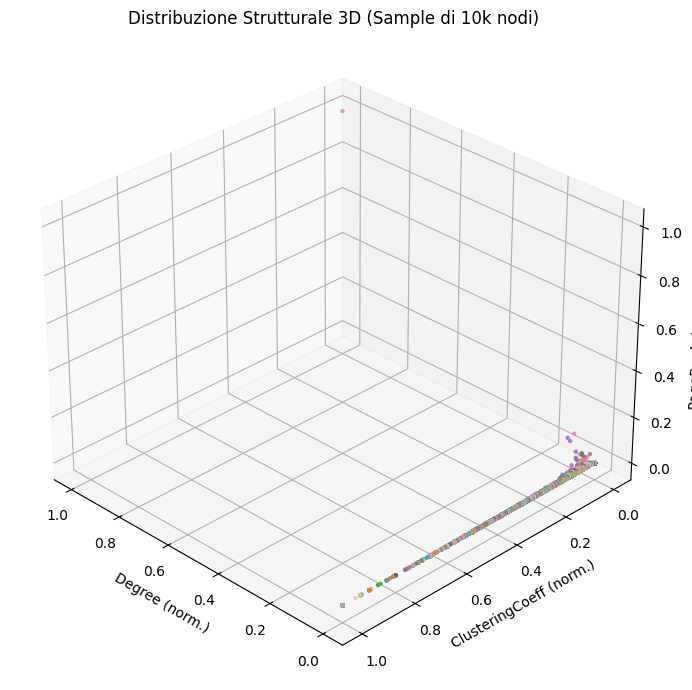

In [34]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.transforms import ToUndirected
from torch_geometric.utils import to_networkx
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# === 1. Carica il dataset ===
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
data = dataset[0]
labels = data['y'].squeeze().numpy()

# === 2. Conversione in NetworkX (sample da 10k nodi per performance) ===
G = to_networkx(data, to_undirected=True)
sample_nodes = list(G.nodes)[:10000]  # oppure random.sample(...)

# === 3. Calcolo delle feature strutturali ===
degree = dict(G.degree(sample_nodes))
clustering = nx.clustering(G, nodes=sample_nodes)
pagerank = nx.pagerank(G, alpha=0.85)

# === 4. Costruzione DataFrame ===
df_structural = pd.DataFrame({
    "Degree": [degree[n] for n in sample_nodes],
    "ClusteringCoeff": [clustering[n] for n in sample_nodes],
    "PageRank": [pagerank[n] for n in sample_nodes],
    "Label": [labels[n] for n in sample_nodes]
})

# === 5. Normalizzazione ===
scaler = MinMaxScaler()
df_structural[["Degree", "ClusteringCoeff", "PageRank"]] = scaler.fit_transform(
    df_structural[["Degree", "ClusteringCoeff", "PageRank"]])

# === 6. Plot 3D ===
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    df_structural["Degree"],
    df_structural["ClusteringCoeff"],
    df_structural["PageRank"],
    c=df_structural["Label"],
    cmap='tab20',
    s=10,
    alpha=0.8,
    linewidth=0
)

ax.set_title("Distribuzione Strutturale 3D (Sample di 10k nodi)")
ax.set_xlabel("Degree (norm.)")
ax.set_ylabel("ClusteringCoeff (norm.)")
ax.set_zlabel("PageRank (norm.)")
ax.view_init(elev=30, azim=135)  # rotazione iniziale

plt.tight_layout()
plt.savefig("structural_3d_scatter.png", dpi=150)
plt.show()



Per analizzare visivamente la distribuzione dei nodi nello spazio delle feature, applichiamo tecniche di **riduzione dimensionale** su `data.x`, che ora include:
- Le **feature originarie** del dataset ogbn-arxiv.
- Le **feature strutturali**: grado e coefficiente di clustering normalizzati.

- **PCA (Principal Component Analysis)**: riduzione lineare delle dimensioni che preserva la massima varianza.
- **t-SNE (t-Distributed Stochastic Neighbor Embedding)**: tecnica non lineare che enfatizza la preservazione delle **relazioni locali**.

- Valutare la **separabilità tra classi** visivamente.
- Intuire se le nuove feature strutturali contribuiscono a una maggiore **discriminabilità**.
- Esplorare la **forma dello spazio latente** su cui verranno basate le triplette per il metric learning.



> Un clustering ben visibile (soprattutto con t-SNE) è un buon indicatore che gli embedding contengano informazioni utili per una classificazione o un metric learning efficace.


## 🧪 Analisi Visiva 2D: PCA vs t-SNE sulle Feature del Grafo `ogbn-arxiv`

### 🎯 Obiettivo

Esplorare la **distribuzione delle classi di nodi** nello spazio delle feature (originali + strutturali) tramite due tecniche di riduzione dimensionale:

-  **PCA (Principal Component Analysis)** → proiezione lineare
-  **t-SNE (t-distributed Stochastic Neighbor Embedding)** → proiezione non lineare

Le tecniche sono utili per:
- verificare la **separabilità delle classi** nei dati
- diagnosticare la **struttura latente** delle feature
- motivare l’uso di modelli più espressivi (es. GNN)

---

###  Risultato del Grafico

#### 🔹 PCA (sinistra)
- Le classi sono **fortemente sovrapposte**.
- La proiezione mostra un "ammasso centrale" senza cluster evidenti.
- Questo è tipico della PCA, che **preserva solo la varianza lineare**.

 *Conclusione:* le feature non sono linearmente separabili.

#### 🔸 t-SNE (destra)
- Appaiono **zone compatte e strutturate**, sebbene non totalmente isolate.
- Alcune classi tendono a **occupare regioni specifiche** dello spazio 2D.
- Il risultato è coerente con la capacità del t-SNE di **preservare vicinanze locali**.

 *Conclusione:* le feature hanno **informazione strutturale rilevante**, utile per modelli non lineari.

---

###  Implicazioni per la Modellazione

- Le feature grezze + strutturali **non sono linearmente separabili** (come mostra PCA), ma t-SNE evidenzia **pattern latenti** sfruttabili.
- Questo giustifica l’uso di modelli **deep**, **non lineari**, e **graph-aware**.
- Un modello MLP potrebbe non bastare, ma una GNN che integra struttura + feature potrebbe performare meglio.

---




In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.transforms import ToUndirected
from PIL import Image

# === 1. Carica dataset ===
data_path = "ogbn_arxiv_with_structural.pt"
data = torch.load(data_path)

X = data.x.cpu().numpy()
y = data.y.squeeze().cpu().numpy()

# === 2. Percorsi per salvataggio ===
pca_file = "X_pca_structural.npy"
tsne_file = "X_tsne_structural.npy"
img_file_png = "pca_tsne_structural_features.png"
img_file_pdf = "pca_tsne_structural_features.pdf"

# === 3. PCA ===
if os.path.exists(pca_file):
    print("🔁 PCA già calcolato, carico da file...")
    X_pca = np.load(pca_file)
else:
    print("🔄 Calcolo PCA...")
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    np.save(pca_file, X_pca)

# === 4. t-SNE ===
if os.path.exists(tsne_file):
    print("🔁 t-SNE già calcolato, carico da file...")
    X_tsne = np.load(tsne_file)
else:
    print("🔄 Calcolo t-SNE...")
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    X_tsne = tsne.fit_transform(X)
    np.save(tsne_file, X_tsne)

# === 5. Visualizzazione o caricamento immagini ===
if not os.path.exists(img_file_png):
    print("📊 Genero e salvo i grafici...")

    plt.figure(figsize=(12, 5))

    # --- PCA ---
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="tab20", s=1)
    plt.title("PCA delle feature (originali + strutturali)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.colorbar(scatter, label="Classe")

    # --- t-SNE ---
    plt.subplot(1, 2, 2)
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap="tab20", s=1)
    plt.title("t-SNE delle feature (originali + strutturali)")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.colorbar(scatter, label="Classe")

    plt.tight_layout()
    plt.savefig(img_file_png, dpi=300)
    plt.savefig(img_file_pdf)
    plt.show()
else:
    print(f"🖼️ Immagine già generata: {img_file_png}")
    Image.open(img_file_png).show()


🔁 PCA già calcolato, carico da file...
🔁 t-SNE già calcolato, carico da file...
🖼️ Immagine già generata: pca_tsne_structural_features.png


## Valutazione della qualità del clustering: Silhouette Score

Per rafforzare l’analisi visiva della distribuzione dei nodi nello spazio delle feature (ottenuto con PCA e t-SNE), calcoliamo un indicatore quantitativo: il **Silhouette Score**.

###  Cos'è il Silhouette Score?
- Misura **quanto bene ogni punto è assegnato alla propria classe** rispetto a quelle vicine.
- Valori vicini a **1.0** indicano una **buona separazione** tra cluster.
- Valori vicini a **0.0** indicano **sovrapposizione** tra le classi.

###  Procedura
- Standardizziamo le feature (incluso grado e clustering coefficient).
- Applichiamo **PCA** e **t-SNE** per ottenere rappresentazioni bidimensionali.
- Campioniamo **5.000 nodi** per rendere il calcolo del silhouette score efficiente.
- Calcoliamo e visualizziamo:
  - Il **Silhouette Score** per PCA.
  - Il **Silhouette Score** per t-SNE.
- Mostriamo entrambi i grafici con il valore corrispondente nel titolo.

###  Obiettivo
- Capire **quanto le classi sono distinguibili** nello spazio proiettato.
- Valutare se le **feature strutturali** migliorano la **discriminabilità** dei nodi.

> Il silhouette score è un criterio utile anche per selezionare le strategie più efficaci di **triplet mining** nel metric learning.


In [14]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.utils import resample
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.transforms import ToUndirected

# === 1. Carica dataset ===
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
data = torch.load("ogbn_arxiv_with_structural.pt")

scaler = StandardScaler()
X = scaler.fit_transform(data.x.numpy())
y = data.y.squeeze().numpy()

# === 2. Percorsi file salvati ===
pca_file = "X_pca.npy"
tsne_file = "X_tsne.npy"
fig_file_png = "pca_tsne_silhouette.png"
fig_file_pdf = "pca_tsne_silhouette.pdf"

# === 3. Carica o calcola PCA ===
if os.path.exists(pca_file):
    print("🔁 PCA già calcolato, carico da file...")
    X_pca = np.load(pca_file)
else:
    print("🔄 Calcolo PCA...")
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    np.save(pca_file, X_pca)

# === 4. Carica o calcola t-SNE ===
if os.path.exists(tsne_file):
    print("🔁 t-SNE già calcolato, carico da file...")
    X_tsne = np.load(tsne_file)
else:
    print("🔄 Calcolo t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    X_tsne = tsne.fit_transform(X)
    np.save(tsne_file, X_tsne)

# === 5. Calcolo silhouette score su un campione ===
print("⚡ Calcolo silhouette score su 5000 campioni...")
X_pca_sample, y_sample = resample(X_pca, y, n_samples=5000, random_state=42)
X_tsne_sample, _ = resample(X_tsne, y, n_samples=5000, random_state=42)

pca_silhouette = silhouette_score(X_pca_sample, y_sample)
tsne_silhouette = silhouette_score(X_tsne_sample, y_sample)

# === 6. Visualizzazione e salvataggio grafici ===
if not os.path.exists(fig_file_png):
    print("📊 Genero e salvo visualizzazione...")
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="tab20", s=1)
    plt.title(f"PCA (Silhouette ~ {pca_silhouette:.3f})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.colorbar(scatter, label="Classe")

    plt.subplot(1, 2, 2)
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap="tab20", s=1)
    plt.title(f"t-SNE (Silhouette ~ {tsne_silhouette:.3f})")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.colorbar(scatter, label="Classe")

    plt.tight_layout()
    plt.savefig(fig_file_png, dpi=300)
    plt.savefig(fig_file_pdf)
    plt.show()
else:
    print(f"🖼️ Immagini già presenti: {fig_file_png}")
    from PIL import Image
    Image.open(fig_file_png).show()

# === 7. Output silhouette
print("\n✅ Silhouette Score (su 5000 nodi campionati):")
print(f"PCA:  {pca_silhouette:.4f}")
print(f"t-SNE:{tsne_silhouette:.4f}")


🔁 PCA già calcolato, carico da file...
🔁 t-SNE già calcolato, carico da file...
⚡ Calcolo silhouette score su 5000 campioni...
🖼️ Immagini già presenti: pca_tsne_silhouette.png

✅ Silhouette Score (su 5000 nodi campionati):
PCA:  -0.2929
t-SNE:-0.2192


## Valutazione degli Embedding GNN con XGBoost

### Obiettivo

Confrontare la qualità degli **embedding prodotti da diversi modelli GNN** (GraphSAGE, GCN, GAT, GATv2) utilizzando un classificatore esterno: **XGBoost**, senza riutilizzare la struttura del grafo.

Questo consente di valutare **quanto bene gli embedding codificano le classi** a prescindere dall’architettura, in modo indipendente e generalizzabile.

---

### Metodo

- Gli embedding sono trattati come feature fisse.
- Viene usato `xgboost.train` con:
  - obiettivo: `multi:softmax`
  - metrica: `mlogloss`
  - `max_depth = 6`, `eta = 0.1`, `num_boost_round = 100`
- Accuracy calcolata su validation e test set di OGBN-Arxiv.
- Risultati salvati in `xgboost_results.csv`.

---

### Risultati

| Embedding  | Val Acc | Test Acc |
|------------|---------|----------|
| **GCN**     | 0.7014  | 0.6902   |
| GATv2      | 0.6963  | 0.6883   |
| GraphSAGE  | 0.6946  | 0.6857   |
| GAT        | 0.6836  | 0.6756   |

- 🥇 **GCN** ottiene la miglior accuracy sia su validation che test.
- 🟡 **GATv2** e **GraphSAGE** sono molto vicini tra loro.
- 🔴 **GAT** è quello che performa peggio, con oltre 1.5% in meno rispetto a GCN.

---

### Interpretazione

- Le differenze, seppur non enormi, suggeriscono che **GCN produce embedding più separabili in spazi semplici**.
- GAT e GATv2, pur essendo architetture più complesse, **non necessariamente generalizzano meglio in forma pura**, senza il supporto del grafo.
- Questo rafforza l’idea che la **qualità degli embedding dipende sia dall'architettura sia dal task** di ottimizzazione.

---

### Conclusione

La valutazione con XGBoost mostra che:
- Anche semplici modelli (come GCN) possono produrre embedding efficaci.
- GAT-based possono richiedere fine-tuning o strutture di loss più sofisticate.
- Questo test è fondamentale per comprendere la **portabilità e la generalizzazione** degli embedding fuori dal grafo.




In [42]:
import torch
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.transforms import ToUndirected
from tabulate import tabulate  # <-- libreria per stampa tabellare elegante

# === 1. Carica gli embedding ===
embeddings = {
   
    "DeepSage" : torch.load("deep_sage_structural_embeddings.pt")
}

# === 2. Carica i dati OGB ===
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
split_idx = dataset.get_idx_split()
labels = dataset[0].y.squeeze().numpy()
train_idx = split_idx['train'].numpy()
val_idx = split_idx['valid'].numpy()
test_idx = split_idx['test'].numpy()

# === 3. Funzione di valutazione con XGBoost ===
def eval_xgboost(name, emb):
    X = emb.numpy()
    dtrain = xgb.DMatrix(X[train_idx], label=labels[train_idx])
    dval = xgb.DMatrix(X[val_idx], label=labels[val_idx])
    dtest = xgb.DMatrix(X[test_idx], label=labels[test_idx])

    params = {
        "objective": "multi:softmax",
        "eval_metric": "mlogloss",
        "num_class": len(set(labels)),
        "max_depth": 6,
        "eta": 0.1,
        "verbosity": 0
    }

    model = xgb.train(params, dtrain, num_boost_round=100)
    val_pred = model.predict(dval)
    test_pred = model.predict(dtest)

    val_acc = accuracy_score(labels[val_idx], val_pred)
    test_acc = accuracy_score(labels[test_idx], test_pred)

    return val_acc, test_acc

# === 4. Valutazione e tabella ===
results = []
for name, emb in embeddings.items():
    val_acc, test_acc = eval_xgboost(name, emb)
    results.append((name, round(val_acc, 4), round(test_acc, 4)))

# === 5. DataFrame e CSV ===
df = pd.DataFrame(results, columns=["Embedding", "Val Accuracy", "Test Accuracy"])
df.to_csv("xgboost_results.csv", index=False)

# === 6. Stampa elegante ===
print("\n📊 Risultati XGBoost sui vari embedding:\n")
print(tabulate(df, headers="keys", tablefmt="fancy_grid", showindex=False))



📊 Risultati XGBoost sui vari embedding:

╒═════════════╤════════════════╤═════════════════╕
│ Embedding   │   Val Accuracy │   Test Accuracy │
╞═════════════╪════════════════╪═════════════════╡
│ DeepSage    │         0.7255 │          0.7092 │
╘═════════════╧════════════════╧═════════════════╛


## 🧭 Apprendimento Metrico: Generazione di Coppie Positive/Negative

### 🎯 Obiettivo

Il classico addestramento di GNN mira a massimizzare la predizione di classe, ma **non garantisce una struttura nello spazio degli embedding**.  
L'idea qui è integrare un processo di **apprendimento metrico** (_metric learning_) che possa:

- Migliorare la **coerenza locale dello spazio degli embedding**
- Permettere **classificazione basata su distanza**, anche senza supervision esplicita
- Fornire supporto per loss contrastive o architetture tipo **Siamese Network**

---

### ⚙️ Metodo

Il codice esegue i seguenti step:

1. **Caricamento degli embedding GCN** e delle label originali da `ogbn-arxiv`.
2. Generazione di `NUM_PAIRS` coppie:
   - 🔵 **Coppie positive**: due nodi con la **stessa label**
   - 🔴 **Coppie negative**: due nodi con **label differenti**
3. Ogni coppia è composta da:
   - `x1[i]`, `x2[i]`: due vettori embedding
   - `labels[i] ∈ {0, 1}`: 1 se positiva, 0 se negativa
4. Salvataggio dei dati in `metric_learning_pairs.pt` come dizionario `{'x1', 'x2', 'labels'}`.

---



In [2]:
import torch
import numpy as np
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.transforms import ToUndirected
import time
import os

# === Config ===
NUM_PAIRS = 50000
SAVE_PATH = "metric_learning_pairs.pt"

# === 1. Carica embedding e label ===
print("📦 Caricamento embedding e label...")
X = torch.load("gcn_node_embeddings.pt")  
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
labels = dataset[0].y.squeeze()
labels_np = labels.numpy()
num_nodes = X.size(0)

# === 2. Genera coppie positive/negative con logging ===
def generate_pairs(X, labels, num_pairs=50000, log_every=5000):
    x1, x2, y = [], [], []
    class_labels = np.unique(labels)

    start_time = time.time()
    for i in range(num_pairs):
        if i % log_every == 0 and i > 0:
            elapsed = time.time() - start_time
            print(f"🔄 Generato {i}/{num_pairs} coppie in {elapsed:.2f}s")

        # Positive pair
        class_id = np.random.choice(class_labels)
        same_class_idxs = np.where(labels == class_id)[0]
        i1, i2 = np.random.choice(same_class_idxs, 2, replace=False)
        x1.append(X[i1])
        x2.append(X[i2])
        y.append(1)

        # Negative pair
        while True:
            i1 = np.random.randint(num_nodes)
            i2 = np.random.randint(num_nodes)
            if labels[i1] != labels[i2]:
                break
        x1.append(X[i1])
        x2.append(X[i2])
        y.append(0)

    print("✅ Generazione completata.")
    return torch.stack(x1), torch.stack(x2), torch.tensor(y)

print("🚀 Generazione in corso...")
x1, x2, labels_pair = generate_pairs(X, labels_np, num_pairs=NUM_PAIRS)

# === 3. Salvataggio output ===
print("💾 Salvataggio in corso...")
torch.save({'x1': x1, 'x2': x2, 'labels': labels_pair}, SAVE_PATH)
print(f"✅ Salvataggio completato in: {SAVE_PATH}")



📦 Caricamento embedding e label...
🚀 Generazione in corso...
🔄 Generato 5000/50000 coppie in 1.72s
🔄 Generato 10000/50000 coppie in 3.41s
🔄 Generato 15000/50000 coppie in 5.15s
🔄 Generato 20000/50000 coppie in 6.87s
🔄 Generato 25000/50000 coppie in 8.54s
🔄 Generato 30000/50000 coppie in 10.35s
🔄 Generato 35000/50000 coppie in 12.04s
🔄 Generato 40000/50000 coppie in 13.71s
🔄 Generato 45000/50000 coppie in 15.49s
✅ Generazione completata.
💾 Salvataggio in corso...
✅ Salvataggio completato in: metric_learning_pairs.pt


## Generazione di coppie per Metric Learning

Per addestrare un modello basato su **Metric Learning**, è necessario costruire un dataset di **coppie**:
- **Positive**: due nodi appartenenti alla **stessa classe**.
- **Negative**: due nodi appartenenti a **classi diverse**.

Questo approccio è usato in contesti come:
- **Siamese Networks** con **contrastive loss**.
- **Triplet Loss** con anchor-positive-negative.
- Apprendimento di uno **spazio latente** in cui la distanza rifletta la similarità semantica.

### 🧪 Procedura
1. Carichiamo gli **embedding pre-addestrati** (es. da GCN).
2. Estraiamo le etichette originali del dataset `ogbn-arxiv`.
3. Generiamo `N` coppie bilanciate (50% positive, 50% negative):
   - Positive: due nodi con la stessa etichetta.
   - Negative: due nodi con etichette diverse.
4. Salviamo il dataset come tensore contenente:
   - `x1`: primo elemento della coppia.
   - `x2`: secondo elemento.
   - `labels`: `1` per coppie positive, `0` per negative.

> Questo dataset è pronto per essere utilizzato in un **modello siamesi**, o in una pipeline di apprendimento metrico supervisionato.


🚀 Start training for 100 epochs
Epoch 01 | Loss: 77.4086 | Val Acc: 0.4864 | Val AUC: 0.4893
Epoch 02 | Loss: 71.1384 | Val Acc: 0.4905 | Val AUC: 0.4934
Epoch 03 | Loss: 70.2932 | Val Acc: 0.4930 | Val AUC: 0.4960
Epoch 04 | Loss: 70.1460 | Val Acc: 0.4877 | Val AUC: 0.4906
Epoch 05 | Loss: 69.3326 | Val Acc: 0.4854 | Val AUC: 0.4883
Epoch 06 | Loss: 69.1860 | Val Acc: 0.4888 | Val AUC: 0.4917
Epoch 07 | Loss: 68.5856 | Val Acc: 0.4752 | Val AUC: 0.4780
Epoch 08 | Loss: 68.6536 | Val Acc: 0.4855 | Val AUC: 0.4884
Epoch 09 | Loss: 68.3672 | Val Acc: 0.4801 | Val AUC: 0.4830
Epoch 10 | Loss: 68.2379 | Val Acc: 0.4771 | Val AUC: 0.4800
Epoch 11 | Loss: 68.0404 | Val Acc: 0.4848 | Val AUC: 0.4877
Epoch 12 | Loss: 67.7309 | Val Acc: 0.4804 | Val AUC: 0.4833
Epoch 13 | Loss: 67.6108 | Val Acc: 0.4765 | Val AUC: 0.4794
⏹️ Early stopping: no improvement in AUC
✅ Test Accuracy: 0.4996 | Test AUC: 0.4956


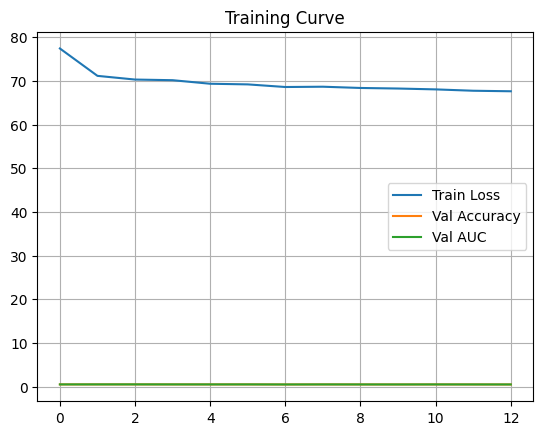

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import os
from datetime import datetime

# === CONFIG ===
BATCH_SIZE = 256
NUM_EPOCHS = 100
LR = 1e-3
VAL_SPLIT = 0.1
PATIENCE = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load pair data ===
data = torch.load("metric_learning_pairs.pt")
x1, x2, y = data['x1'], data['x2'], data['labels']

# === Custom Dataset ===
class SiameseDataset(Dataset):
    def __init__(self, x1, x2, y):
        self.x1, self.x2, self.y = x1, x2, y
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.x1[idx], self.x2[idx], self.y[idx]

# === Dataset split ===
full_dataset = SiameseDataset(x1, x2, y)
val_size = int(VAL_SPLIT * len(full_dataset))
test_size = int(VAL_SPLIT * len(full_dataset))
train_size = len(full_dataset) - val_size - test_size
train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

# === Siamese Network ===
class SiameseNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=256):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
    def forward_once(self, x): return self.encoder(x)
    def forward(self, x1, x2): return self.forward_once(x1), self.forward_once(x2)

# === Contrastive Loss ===
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin
    def forward(self, out1, out2, label):
        dist = F.pairwise_distance(out1, out2)
        return ((1 - label) * dist.pow(2) + label * (torch.clamp(self.margin - dist, min=0)).pow(2)).mean()

# === Evaluation ===
def evaluate(model, loader, threshold=0.7):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x1b, x2b, yb in loader:
            x1b, x2b = x1b.to(DEVICE), x2b.to(DEVICE)
            out1, out2 = model(x1b, x2b)
            dist = F.pairwise_distance(out1, out2)
            pred = (dist < threshold).int().cpu().numpy()
            y_true.extend(yb.cpu().numpy())
            y_pred.extend(pred)
    return accuracy_score(y_true, y_pred), roc_auc_score(y_true, y_pred)

# === Setup ===
model = SiameseNet(input_dim=x1.shape[1]).to(DEVICE)
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

best_val_auc = 0
patience_counter = 0
train_losses = []
val_accuracies = []
val_aucs = []

print(f"🚀 Start training for {NUM_EPOCHS} epochs")
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    epoch_loss = 0
    for x1b, x2b, yb in train_loader:
        x1b, x2b, yb = x1b.to(DEVICE), x2b.to(DEVICE), yb.float().to(DEVICE)
        out1, out2 = model(x1b, x2b)
        loss = criterion(out1, out2, yb)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        epoch_loss += loss.item()

    acc, auc = evaluate(model, val_loader)
    train_losses.append(epoch_loss)
    val_accuracies.append(acc)
    val_aucs.append(auc)

    print(f"Epoch {epoch:02d} | Loss: {epoch_loss:.4f} | Val Acc: {acc:.4f} | Val AUC: {auc:.4f}")

    if auc > best_val_auc:
        best_val_auc = auc
        patience_counter = 0
        torch.save(model.state_dict(), "best_siamese_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("⏹️ Early stopping: no improvement in AUC")
            break

# === Final test evaluation ===
model.load_state_dict(torch.load("best_siamese_model.pt"))
test_acc, test_auc = evaluate(model, test_loader)
print(f"✅ Test Accuracy: {test_acc:.4f} | Test AUC: {test_auc:.4f}")

# === Plots ===
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.plot(val_aucs, label="Val AUC")
plt.legend(); plt.title("Training Curve"); plt.grid(True); plt.show()


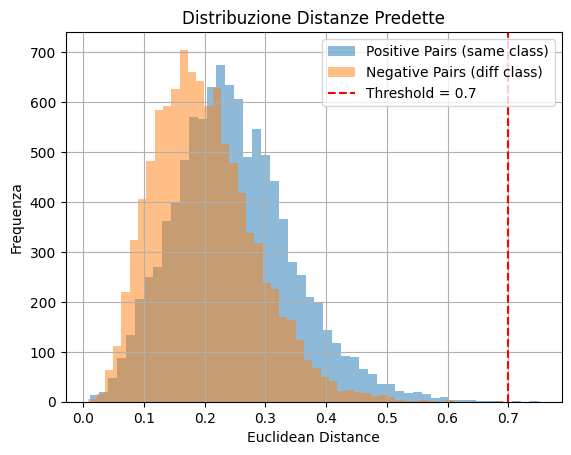

In [4]:
import numpy as np
import matplotlib.pyplot as plt

model.eval()
distances_pos, distances_neg = [], []

with torch.no_grad():
    for x1b, x2b, yb in test_loader:
        x1b, x2b, yb = x1b.to(device), x2b.to(device), yb.to(device)
        out1, out2 = model(x1b, x2b)
        dist = F.pairwise_distance(out1, out2)
        for d, y_val in zip(dist.cpu(), yb.cpu()):
            if y_val == 1:
                distances_pos.append(d.item())
            else:
                distances_neg.append(d.item())

# Plot
plt.hist(distances_pos, bins=50, alpha=0.5, label='Positive Pairs (same class)')
plt.hist(distances_neg, bins=50, alpha=0.5, label='Negative Pairs (diff class)')
plt.axvline(0.7, color='red', linestyle='--', label='Threshold = 0.7')
plt.title("Distribuzione Distanze Predette")
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequenza")
plt.legend()
plt.grid(True)
plt.show()


##  Metric Learning con Triplet Loss e Hard Negative Mining

###  Obiettivo

Migliorare la qualità e la coerenza geometrica degli **embedding appresi** da GNN, usando un modello **siamese** basato su Triplet Loss. L’obiettivo è rendere i punti simili (stessa classe) **vicini** e quelli dissimili **lontani**, migliorando la performance di classificatori basati su distanza (es. KNN) o clustering.

---

###  Struttura del Codice

1. **Caricamento degli embedding** da GCN (`.pt`) e normalizzazione `L2`.
2. **Creazione di triplette** (anchor, positivo, negativo) con:
   - Positive: stesso label
   - Hard negative: nodo con label diversa e embedding più simile all’anchor
3. Addestramento di un **encoder MLP** (shared weights) con **Triplet Loss**.
4. Salvataggio periodico di:
   - Modello (`triplet_model_current.pt`)
   - Storico loss (`triplet_train_losses.pt`)
5. Visualizzazione dell’andamento della loss.

---

###  Risultato atteso

Il training produce embedding in cui:
-  I nodi della stessa classe sono clusterizzati
-  Le classi sono più separabili nel nuovo spazio (ideale per t-SNE/PCA)
-  Classificatori downstream (KNN, XGBoost) beneficiano della ristrutturazione geometrica

---




🔁 Ripristino modello da checkpoint...
🔁 Ripresa dall'epoca 31
📈 Epoch 31 | Triplet Loss: 231.3606
📈 Epoch 32 | Triplet Loss: 230.7068
📈 Epoch 33 | Triplet Loss: 229.4609
📈 Epoch 34 | Triplet Loss: 229.1173
📈 Epoch 35 | Triplet Loss: 228.9430
📈 Epoch 36 | Triplet Loss: 229.0588
📈 Epoch 37 | Triplet Loss: 228.7239
📈 Epoch 38 | Triplet Loss: 228.2611
📈 Epoch 39 | Triplet Loss: 227.5112
📈 Epoch 40 | Triplet Loss: 226.5211
📈 Epoch 41 | Triplet Loss: 227.2570
📈 Epoch 42 | Triplet Loss: 226.8367
📈 Epoch 43 | Triplet Loss: 225.8565
📈 Epoch 44 | Triplet Loss: 225.5486
📈 Epoch 45 | Triplet Loss: 226.5549
📈 Epoch 46 | Triplet Loss: 224.9692
📈 Epoch 47 | Triplet Loss: 225.3237
📈 Epoch 48 | Triplet Loss: 224.6812
📈 Epoch 49 | Triplet Loss: 224.9066
📈 Epoch 50 | Triplet Loss: 223.7920
📈 Epoch 51 | Triplet Loss: 224.2666
📈 Epoch 52 | Triplet Loss: 224.8305
📈 Epoch 53 | Triplet Loss: 223.2391
📈 Epoch 54 | Triplet Loss: 224.0825
📈 Epoch 55 | Triplet Loss: 223.3547
📈 Epoch 56 | Triplet Loss: 223.5006
📈 

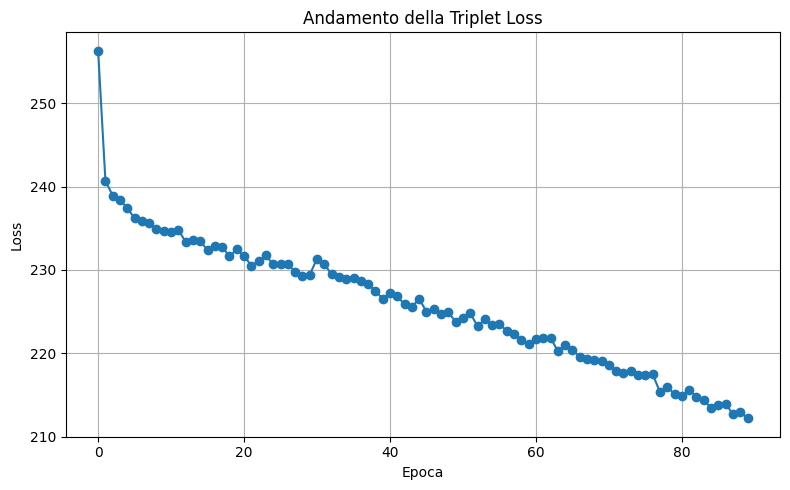

In [7]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.transforms import ToUndirected
from datetime import datetime
import matplotlib.pyplot as plt
import os

# === 1. Carica embedding normalizzati ===
X = F.normalize(torch.load("gcn_node_embeddings.pt"), p=2, dim=1)

# === 2. Carica label OGB ===
dataset = PygNodePropPredDataset(name="ogbn-arxiv", root="dataset/ogbn-arxiv", transform=ToUndirected())
labels = dataset[0].y.squeeze()

# === 3. Triplet Dataset con Hard Negative Mining ===
class TripletDataset(Dataset):
    def __init__(self, embeddings, labels, num_triplets=50000, neg_sample_size=500):
        self.embeddings = embeddings
        self.labels = labels.numpy()
        self.num_triplets = num_triplets
        self.neg_sample_size = neg_sample_size
        self.triplets = self._generate_triplets()

    def _generate_triplets(self):
        triplets = []
        num_nodes = self.embeddings.size(0)

        for _ in range(self.num_triplets):
            anchor_idx = np.random.randint(num_nodes)
            anchor_label = self.labels[anchor_idx]

            # Positive sample
            pos_candidates = np.where(self.labels == anchor_label)[0]
            pos_candidates = pos_candidates[pos_candidates != anchor_idx]
            if len(pos_candidates) == 0:
                continue
            pos_idx = np.random.choice(pos_candidates)

            # Hard negative mining
            neg_candidates = np.where(self.labels != anchor_label)[0]
            neg_sampled = np.random.choice(neg_candidates, size=min(self.neg_sample_size, len(neg_candidates)), replace=False)
            with torch.no_grad():
                anchor_embed = self.embeddings[anchor_idx].unsqueeze(0)
                neg_embeds = self.embeddings[neg_sampled]
                distances = F.pairwise_distance(anchor_embed, neg_embeds)
            neg_idx = neg_sampled[distances.argmin().item()]

            triplets.append((anchor_idx, pos_idx, neg_idx))
        return triplets

    def __len__(self): return len(self.triplets)
    def __getitem__(self, idx):
        a, p, n = self.triplets[idx]
        return self.embeddings[a], self.embeddings[p], self.embeddings[n]

# === 4. Dataloader ===
triplet_dataset = TripletDataset(X, labels, num_triplets=60000)
train_loader = DataLoader(triplet_dataset, batch_size=256, shuffle=True)

# === 5. Encoder Model ===
class TripletNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 64)
        )
    def forward(self, a, p, n):
        return self.encoder(a), self.encoder(p), self.encoder(n)

# === 6. Loss ===
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin
    def forward(self, a, p, n):
        d_pos = F.pairwise_distance(a, p)
        d_neg = F.pairwise_distance(a, n)
        return F.relu(d_pos - d_neg + self.margin).mean()

# === 7. Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TripletNet(input_dim=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = TripletLoss(margin=1.0)

model_path = "triplet_model_current.pt"
loss_path = "triplet_train_losses.pt"
train_losses = []
start_epoch = 1

if os.path.exists(model_path):
    print("🔁 Ripristino modello da checkpoint...")
    model.load_state_dict(torch.load(model_path))
    if os.path.exists(loss_path):
        train_losses = torch.load(loss_path)
        start_epoch = len(train_losses) + 1
        print(f"🔁 Ripresa dall'epoca {start_epoch}")

# === 8. Training ===
num_epochs = 90
for epoch in range(start_epoch, num_epochs + 1):
    model.train()
    epoch_loss = 0.0

    for a, p, n in train_loader:
        a, p, n = a.to(device), p.to(device), n.to(device)
        out_a, out_p, out_n = model(a, p, n)
        loss = criterion(out_a, out_p, out_n)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss)
    print(f"📈 Epoch {epoch:02d} | Triplet Loss: {epoch_loss:.4f}")

    torch.save(model.state_dict(), model_path)
    torch.save(train_losses, loss_path)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    torch.save(model.state_dict(), f"triplet_model_ep{epoch}_{timestamp}.pt")
    torch.save(train_losses, f"triplet_losses_ep{epoch}_{timestamp}.pt")

# === 9. Plot finale ===
plt.figure(figsize=(8, 5))
plt.plot(train_losses, marker='o')
plt.title("Andamento della Triplet Loss")
plt.xlabel("Epoca")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
import torch
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.transforms import ToUndirected
from tabulate import tabulate
import torch.nn as nn
import torch.nn.functional as F

# === 1. Definizione del modello TripletNet ===
class TripletNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 64)
        )
    def forward(self, a, p, n):
        return self.encoder(a), self.encoder(p), self.encoder(n)

# === 2. Caricamento dataset e split ===
dataset = PygNodePropPredDataset(name="ogbn-arxiv", root="dataset/ogbn-arxiv", transform=ToUndirected())
split_idx = dataset.get_idx_split()
labels = dataset[0].y.squeeze().numpy()

train_idx = split_idx['train'].numpy()
val_idx = split_idx['valid'].numpy()
test_idx = split_idx['test'].numpy()

# === 3. Carica embedding originali ===
X_raw = torch.load("gcn_node_embeddings.pt").cpu()
X_raw_np = X_raw.numpy()

# === 4. Carica modello Triplet e genera nuovi embedding ===
model = TripletNet(input_dim=X_raw.size(1))
model.load_state_dict(torch.load("triplet_model_current.pt", map_location="cpu"))
model.eval()

with torch.no_grad():
    X_encoded = model.encoder(X_raw).numpy()

# === 5. Funzione di valutazione ===
def evaluate_classifiers(name, X):
    print(f"\n🔍 Valutazione su embedding: {name}")

    clf_log = LogisticRegression(max_iter=1000)
    clf_log.fit(X[train_idx], labels[train_idx])
    acc_log = accuracy_score(labels[test_idx], clf_log.predict(X[test_idx]))

    clf_knn = KNeighborsClassifier(n_neighbors=5)
    clf_knn.fit(X[train_idx], labels[train_idx])
    acc_knn = accuracy_score(labels[test_idx], clf_knn.predict(X[test_idx]))

    print(f"📘 Logistic Regression: {acc_log:.4f}")
    print(f"📗 KNN (k=5):            {acc_knn:.4f}")
    return acc_log, acc_knn

# === 6. Confronto embedding raw vs triplet ===import torch
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.transforms import ToUndirected
from tabulate import tabulate
import torch.nn as nn
import torch.nn.functional as F

# === 1. Definizione del modello TripletNet ===
class TripletNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 64)
        )
    def forward(self, a, p=None, n=None):
        if p is not None and n is not None:
            return self.encoder(a), self.encoder(p), self.encoder(n)
        return self.encoder(a)

# === 2. Caricamento dataset e split ===
dataset = PygNodePropPredDataset(name="ogbn-arxiv", root="dataset/ogbn-arxiv", transform=ToUndirected())
split_idx = dataset.get_idx_split()
labels = dataset[0].y.squeeze().numpy()

train_idx = split_idx['train'].numpy()
val_idx = split_idx['valid'].numpy()
test_idx = split_idx['test'].numpy()

# === 3. Carica embedding originali ===
X_raw = torch.load("gcn_node_embeddings.pt").cpu()
X_raw_np = X_raw.numpy()

# === 4. Carica modello Triplet e genera nuovi embedding ===
model = TripletNet(input_dim=X_raw.size(1))
model.load_state_dict(torch.load("triplet_model_current.pt", map_location="cpu"))
model.eval()

with torch.no_grad():
    X_encoded = model.encoder(X_raw).numpy()

# === 5. Funzione di valutazione con scaling e max_iter aumentato ===
def evaluate_classifiers(name, X):
    print(f"\n🔍 Valutazione su embedding: {name}")

    # Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Logistic Regression (convergenza migliorata)
    clf_log = LogisticRegression(max_iter=3000, solver='lbfgs')
    clf_log.fit(X_scaled[train_idx], labels[train_idx])
    acc_log = accuracy_score(labels[test_idx], clf_log.predict(X_scaled[test_idx]))

    # KNN (senza scaling)
    clf_knn = KNeighborsClassifier(n_neighbors=5)
    clf_knn.fit(X[train_idx], labels[train_idx])
    acc_knn = accuracy_score(labels[test_idx], clf_knn.predict(X[test_idx]))

    print(f"📘 Logistic Regression (scaled): {acc_log:.4f}")
    print(f"📗 KNN (k=5):                    {acc_knn:.4f}")
    return acc_log, acc_knn

# === 6. Confronto embedding raw vs triplet ===
log_raw, knn_raw = evaluate_classifiers("GCN Embedding (original)", X_raw_np)
log_trp, knn_trp = evaluate_classifiers("Triplet Embedding (learned)", X_encoded)

# === 7. Tabella finale ===
df = pd.DataFrame({
    "Embedding": ["GCN Raw", "Triplet Encoded"],
    "Logistic Acc": [log_raw, log_trp],
    "KNN Acc": [knn_raw, knn_trp]
})

print("\n📊 Risultati comparativi:")
print(tabulate(df, headers="keys", tablefmt="fancy_grid", showindex=False))

log_raw, knn_raw = evaluate_classifiers("GCN Embedding (original)", X_raw_np)
log_trp, knn_trp = evaluate_classifiers("Triplet Embedding (learned)", X_encoded)

# === 7. Tabella finale ===
df = pd.DataFrame({
    "Embedding": ["GCN Raw", "Triplet Encoded"],
    "Logistic Acc": [log_raw, log_trp],
    "KNN Acc": [knn_raw, knn_trp]
})

print("\n📊 Risultati comparativi:")
print(tabulate(df, headers="keys", tablefmt="fancy_grid", showindex=False))



🔍 Valutazione su embedding: GCN Embedding (original)
📘 Logistic Regression (scaled): 0.6880
📗 KNN (k=5):                    0.6533

🔍 Valutazione su embedding: Triplet Embedding (learned)
📘 Logistic Regression (scaled): 0.6803
📗 KNN (k=5):                    0.6159

📊 Risultati comparativi:
╒═════════════════╤════════════════╤═══════════╕
│ Embedding       │   Logistic Acc │   KNN Acc │
╞═════════════════╪════════════════╪═══════════╡
│ GCN Raw         │       0.688003 │  0.653314 │
├─────────────────┼────────────────┼───────────┤
│ Triplet Encoded │       0.680267 │  0.615867 │
╘═════════════════╧════════════════╧═══════════╛

🔍 Valutazione su embedding: GCN Embedding (original)
📘 Logistic Regression (scaled): 0.6880
📗 KNN (k=5):                    0.6533

🔍 Valutazione su embedding: Triplet Embedding (learned)
📘 Logistic Regression (scaled): 0.6803
📗 KNN (k=5):                    0.6159

📊 Risultati comparativi:
╒═════════════════╤════════════════╤═══════════╕
│ Embedding       │   

In [8]:
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.transforms import ToUndirected
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# === 1. Ricarica dataset e splits
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
split_idx = dataset.get_idx_split()
labels = dataset[0].y.squeeze()

# === 2. Carica embedding GCN e modello Triplet allenato
X = torch.load("gcn_node_embeddings.pt")
X = F.normalize(X, p=2, dim=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TripletNet(input_dim=X.shape[1])
model.load_state_dict(torch.load("triplet_model_current.pt"))
model.to(device)
model.eval()

# === 3. Estrai embedding trasformati (Triplet-encoded)
with torch.no_grad():
    encoded = model.encoder(X.to(device)).cpu()

# === 4. Crea train/val/test set
X_train = encoded[split_idx['train']]
y_train = labels[split_idx['train']]

X_val = encoded[split_idx['valid']]
y_val = labels[split_idx['valid']]

X_test = encoded[split_idx['test']]
y_test = labels[split_idx['test']]

# === 5. k-NN Classifier
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)

val_pred = knn.predict(X_val)
test_pred = knn.predict(X_test)

val_acc = accuracy_score(y_val, val_pred)
test_acc = accuracy_score(y_test, test_pred)

# === 6. Output finale
print(f"✅ Validation Accuracy (k-NN): {val_acc:.4f}")
print(f"✅ Test Accuracy (k-NN): {test_acc:.4f}")


✅ Validation Accuracy (k-NN): 0.6563
✅ Test Accuracy (k-NN): 0.6362


##  Classificazione MLP su embedding appresi con Triplet Loss

###  Obiettivo

Testare la qualità degli embedding generati dal modello siamese con Triplet Loss applicando un semplice MLP, e valutare se la trasformazione appresa migliora la separabilità tra classi.

---

###  Setup

- Input: `gcn_node_embeddings.pt`, normalizzati e trasformati tramite `TripletNet`
- Classificatore: `MLP`
  - Architettura: Linear → BN → ReLU → Dropout → Linear
  - Ottimizzazione: Adam + CrossEntropy
- Epoche: 30
- Batch size: 256
- Checkpoint automatico con resume

---

###  Risultati

- **Best Validation Accuracy**: `0.6583`
- **Test Accuracy (MLP)**: `0.6499`

---

###  Andamento addestramento

- La **loss di training** decresce in modo regolare
- La **validation accuracy** mostra un plateau con leggere oscillazioni → possibile plateau del modello

---






Epoch  1 | Loss 891.74 | Val Acc 0.4761
Epoch  2 | Loss 642.69 | Val Acc 0.5627
Epoch  3 | Loss 577.74 | Val Acc 0.5934
Epoch  4 | Loss 546.96 | Val Acc 0.6034
Epoch  5 | Loss 527.86 | Val Acc 0.6195
Epoch  6 | Loss 515.05 | Val Acc 0.6211
Epoch  7 | Loss 504.43 | Val Acc 0.6294
Epoch  8 | Loss 497.19 | Val Acc 0.6365
Epoch  9 | Loss 490.81 | Val Acc 0.6367
Epoch 10 | Loss 485.58 | Val Acc 0.6400
Epoch 11 | Loss 480.83 | Val Acc 0.6431
Epoch 12 | Loss 477.74 | Val Acc 0.6438
Epoch 13 | Loss 473.94 | Val Acc 0.6426
Epoch 14 | Loss 470.56 | Val Acc 0.6492
Epoch 15 | Loss 468.70 | Val Acc 0.6454
Epoch 16 | Loss 466.14 | Val Acc 0.6497
Epoch 17 | Loss 463.64 | Val Acc 0.6500
Epoch 18 | Loss 461.72 | Val Acc 0.6524
Epoch 19 | Loss 459.80 | Val Acc 0.6535
Epoch 20 | Loss 458.05 | Val Acc 0.6580
Epoch 21 | Loss 456.88 | Val Acc 0.6540
Epoch 22 | Loss 454.93 | Val Acc 0.6541
Epoch 23 | Loss 454.09 | Val Acc 0.6556
Epoch 24 | Loss 452.42 | Val Acc 0.6583
Epoch 25 | Loss 451.81 | Val Acc 0.6580


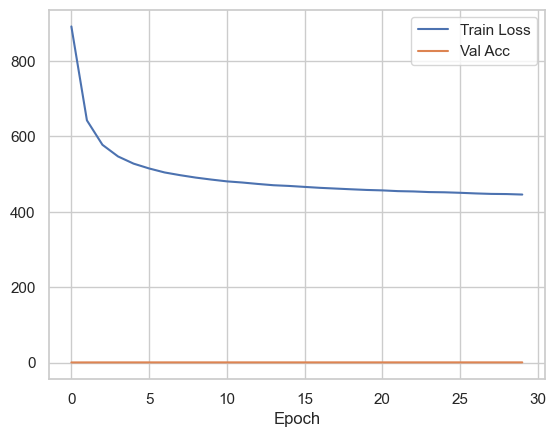

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.transforms import ToUndirected
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# === 1. Carica split e labels ===
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
split_idx = dataset.get_idx_split()
labels = dataset[0].y.squeeze()

# === 2. Carica embedding Triplet e trasformali ===
X = torch.load("gcn_node_embeddings.pt")
X = F.normalize(X, p=2, dim=1)
# Carica il modello triplet e ottieni il nuovo embedding
class TripletNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 64)
        )
    def forward(self, x): return self.encoder(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = TripletNet(input_dim=X.shape[1]).to(device)
class MLPClassifier(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

encoder.load_state_dict(torch.load("triplet_model_current.pt", map_location=device))
encoder.eval()

with torch.no_grad():
    X_enc = encoder(X.to(device)).cpu()

# === 3. Prepara DataLoader per MLP ===
X_train = X_enc[split_idx['train']]; y_train = labels[split_idx['train']]
X_val   = X_enc[split_idx['valid']]; y_val   = labels[split_idx['valid']]
X_test  = X_enc[split_idx['test']];  y_test  = labels[split_idx['test']]

train_ds = TensorDataset(X_train, y_train)
val_ds   = TensorDataset(X_val, y_val)
test_ds  = TensorDataset(X_test, y_test)

bs = 256
train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=bs)
test_loader  = DataLoader(test_ds,  batch_size=bs)

# === 4. MLP con resume ===
num_classes = labels.max().item() + 1
clf = MLPClassifier(in_dim=X_enc.shape[1], num_classes=num_classes).to(device)
opt = torch.optim.Adam(clf.parameters(), lr=1e-3, weight_decay=1e-4)
crit = nn.CrossEntropyLoss()

# === 4.1 Resume se esistono checkpoint ===
resume = os.path.exists("mlp_current.pt")
start_epoch = 1
train_losses, val_accs = [], []
best_val = 0

if resume:
    print("🔁 Ripristino MLP da checkpoint...")
    clf.load_state_dict(torch.load("mlp_current.pt", map_location=device))
    opt.load_state_dict(torch.load("mlp_opt_current.pt", map_location=device))
    if os.path.exists("train_losses.pt"):
        train_losses = torch.load("train_losses.pt")
    if os.path.exists("val_accs.pt"):
        val_accs = torch.load("val_accs.pt")
    if os.path.exists("best_val.pt"):
        best_val = torch.load("best_val.pt")
    start_epoch = len(train_losses) + 1
    print(f"➡️ Riprendo da epoca {start_epoch} con best_val = {best_val:.4f}")

# === 5. Training loop ===
for epoch in range(start_epoch, 31):
    clf.train(); total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = clf(xb)
        loss = crit(logits, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item()
    train_losses.append(total_loss)

    # validation
    clf.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            preds = clf(xb).argmax(1).cpu()
            all_preds.append(preds); all_labels.append(yb)
    val_acc = accuracy_score(torch.cat(all_labels), torch.cat(all_preds))
    val_accs.append(val_acc)

    print(f"Epoch {epoch:2d} | Loss {total_loss:.2f} | Val Acc {val_acc:.4f}")

    # Save best
    if val_acc > best_val:
        best_val = val_acc
        torch.save(clf.state_dict(), "mlp_best.pt")

    # Save checkpoint
    torch.save(clf.state_dict(), "mlp_current.pt")
    torch.save(opt.state_dict(), "mlp_opt_current.pt")
    torch.save(train_losses, "train_losses.pt")
    torch.save(val_accs, "val_accs.pt")
    torch.save(best_val, "best_val.pt")

# === 6. Test finale ===
clf.load_state_dict(torch.load("mlp_best.pt", map_location=device))
clf.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        all_preds.append(clf(xb).argmax(1).cpu()); all_labels.append(yb)
test_acc = accuracy_score(torch.cat(all_labels), torch.cat(all_preds))

print(f"\n✅ Best Val Acc: {best_val:.4f}")
print(f"✅ Test Acc (MLP): {test_acc:.4f}")

# === 7. Plot training curve ===
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch"); plt.legend(); plt.grid(True); plt.show()


In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.transforms import ToUndirected
import torch.nn.functional as F
import torch

# === 1. Carica split e label ===
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
split_idx = dataset.get_idx_split()
labels = dataset[0].y.squeeze()

# === 2. Carica embedding GCN e modello triplet
X = torch.load("gcn_node_embeddings.pt")
X = F.normalize(X, p=2, dim=1)

class TripletNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 64)
        )
    def forward(self, x): return self.encoder(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = TripletNet(input_dim=X.shape[1]).to(device)
encoder.load_state_dict(torch.load("triplet_model_current.pt", map_location=device))
encoder.eval()

with torch.no_grad():
    X_triplet = encoder(X.to(device)).cpu().numpy()
y_all = labels.numpy()

# === 3. Prepara split
X_train = X_triplet[split_idx['train']]
y_train = y_all[split_idx['train']]
X_val   = X_triplet[split_idx['valid']]
y_val   = y_all[split_idx['valid']]
X_test  = X_triplet[split_idx['test']]
y_test  = y_all[split_idx['test']]

# === 4. XGBoost Classifier
clf = XGBClassifier(tree_method="hist", max_depth=8, learning_rate=0.1, n_estimators=200, use_label_encoder=False, eval_metric="mlogloss", verbosity=0)
clf.fit(X_train, y_train)

val_acc = accuracy_score(y_val, clf.predict(X_val))
test_acc = accuracy_score(y_test, clf.predict(X_test))

print(f"✅ XGBoost su Triplet Embeddings")
print(f"📊 Val Accuracy:  {val_acc:.4f}")
print(f"📊 Test Accuracy: {test_acc:.4f}")


✅ XGBoost su Triplet Embeddings
📊 Val Accuracy:  0.6798
📊 Test Accuracy: 0.6689


In [9]:
import torch
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.transforms import ToUndirected

# === 1. Carica gli embedding ===
embeddings = {
    "GraphSAGE": torch.load("sage_node_embeddings.pt"),
    "GCN": torch.load("gcn_node_embeddings.pt"),
    "GAT": torch.load("gat_node_embeddings.pt"),
    "GATv2": torch.load("gatv2_node_embeddings.pt"),
}

# === 2. Carica i dati OGB ===
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
split_idx = dataset.get_idx_split()
labels = dataset[0].y.squeeze().numpy()
train_idx = split_idx['train'].numpy()
val_idx = split_idx['valid'].numpy()
test_idx = split_idx['test'].numpy()

# === 3. Funzione di valutazione con XGBoost ===
def eval_xgboost(name, emb):
    print(f"🔍 XGBoost su: {name}")
    X = emb.numpy()
    dtrain = xgb.DMatrix(X[train_idx], label=labels[train_idx])
    dval = xgb.DMatrix(X[val_idx], label=labels[val_idx])
    dtest = xgb.DMatrix(X[test_idx], label=labels[test_idx])

    params = {
        "objective": "multi:softmax",
        "eval_metric": "mlogloss",
        "num_class": len(set(labels)),
        "max_depth": 6,
        "eta": 0.1,
        "verbosity": 0
    }

    model = xgb.train(params, dtrain, num_boost_round=100)
    val_pred = model.predict(dval)
    test_pred = model.predict(dtest)

    val_acc = accuracy_score(labels[val_idx], val_pred)
    test_acc = accuracy_score(labels[test_idx], test_pred)

    print(f"📘 Val Accuracy: {val_acc:.4f}")
    print(f"📗 Test Accuracy: {test_acc:.4f}")
    return val_acc, test_acc

# === 4. Valutazione su tutti gli embedding ===
results = []
for name, emb in embeddings.items():
    val_acc, test_acc = eval_xgboost(name, emb)
    results.append((name, val_acc, test_acc))

# === 5. Tabella finale ===
df = pd.DataFrame(results, columns=["Embedding", "Val Acc", "Test Acc"])
df.to_csv("xgboost_results.csv", index=False)
print("\n📊 Risultati salvati in 'xgboost_results.csv':")
print(df)


🔍 XGBoost su: GraphSAGE
📘 Val Accuracy: 0.6946
📗 Test Accuracy: 0.6857
🔍 XGBoost su: GCN
📘 Val Accuracy: 0.7014
📗 Test Accuracy: 0.6902
🔍 XGBoost su: GAT
📘 Val Accuracy: 0.6836
📗 Test Accuracy: 0.6756
🔍 XGBoost su: GATv2
📘 Val Accuracy: 0.6963
📗 Test Accuracy: 0.6883

📊 Risultati salvati in 'xgboost_results.csv':
   Embedding   Val Acc  Test Acc
0  GraphSAGE  0.694621  0.685678
1        GCN  0.701366  0.690163
2        GAT  0.683614  0.675617
3      GATv2  0.696299  0.688332


🔁 Ripristino modello Triplet...


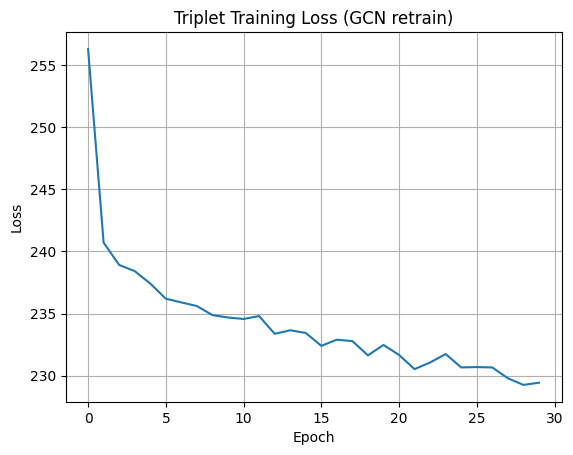

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
import numpy as np
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.transforms import ToUndirected
from datetime import datetime
import os

# === 1. Carica embeddings retrainati e label ===
X = torch.load("gcn_node_embeddings.pt")
X = F.normalize(X, p=2, dim=1)

dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
labels = dataset[0].y.squeeze()

# === 2. Triplet Dataset aggiornato (RAM-friendly) ===
class TripletDataset(Dataset):
    def __init__(self, embeddings, labels, num_triplets=60000, neg_sample_size=500):
        self.embeddings = embeddings
        self.labels = labels
        self.num_triplets = num_triplets
        self.neg_sample_size = neg_sample_size
        self.triplets = self.generate_triplets()

    def generate_triplets(self):
        triplets = []
        labels_np = self.labels.numpy()
        num_nodes = self.embeddings.size(0)

        for _ in range(self.num_triplets):
            anchor_idx = np.random.randint(num_nodes)
            anchor_label = labels_np[anchor_idx]

            # Positive
            pos_pool = np.where(labels_np == anchor_label)[0]
            pos_pool = pos_pool[pos_pool != anchor_idx]
            if len(pos_pool) == 0: continue
            positive_idx = np.random.choice(pos_pool)

            # Approx hard negative
            neg_pool = np.where(labels_np != anchor_label)[0]
            if len(neg_pool) == 0: continue
            neg_sample_idxs = np.random.choice(neg_pool, min(self.neg_sample_size, len(neg_pool)), replace=False)
            dists = F.pairwise_distance(self.embeddings[anchor_idx].unsqueeze(0), self.embeddings[neg_sample_idxs])
            hard_negative_idx = neg_sample_idxs[dists.argmin().item()]

            triplets.append((anchor_idx, positive_idx, hard_negative_idx))

        return triplets

    def __len__(self): return len(self.triplets)
    def __getitem__(self, idx):
        a, p, n = self.triplets[idx]
        return self.embeddings[a], self.embeddings[p], self.embeddings[n]

# === 3. Definizione rete ed encoder ===
class TripletNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 64)
        )
    def forward(self, a, p, n):
        return self.encoder(a), self.encoder(p), self.encoder(n)

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin
    def forward(self, a, p, n):
        return F.relu(F.pairwise_distance(a, p) - F.pairwise_distance(a, n) + self.margin).mean()

# === 4. Setup training ===
triplet_dataset = TripletDataset(X, labels)
train_loader = DataLoader(triplet_dataset, batch_size=256, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TripletNet(input_dim=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = TripletLoss(margin=1.0)

model_path = "triplet_model_current.pt"
loss_path = "triplet_train_losses.pt"
train_losses = []
start_epoch = 1

# Resume se necessario
if os.path.exists(model_path):
    print("🔁 Ripristino modello Triplet...")
    model.load_state_dict(torch.load(model_path))
    if os.path.exists(loss_path):
        train_losses = torch.load(loss_path)
        start_epoch = len(train_losses) + 1

# === 5. Training ===
for epoch in range(start_epoch, 31):
    model.train(); epoch_loss = 0
    for a, p, n in train_loader:
        a, p, n = a.to(device), p.to(device), n.to(device)
        out_a, out_p, out_n = model(a, p, n)
        loss = criterion(out_a, out_p, out_n)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss)
    print(f"📈 Epoch {epoch:2d} | Triplet Loss: {epoch_loss:.4f}")

    torch.save(model.state_dict(), model_path)
    torch.save(train_losses, loss_path)

    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    torch.save(model.state_dict(), f"triplet_model_ep{epoch}_{ts}.pt")

# === 6. Plot loss finale
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.title("Triplet Training Loss (GCN retrain)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [10]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.transforms import ToUndirected
from sklearn.metrics import accuracy_score

# === 1. Caricamento embeddings e labels ===
X = torch.load("gcn_node_embeddings.pt")
X = F.normalize(X, p=2, dim=1)

dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
labels = dataset[0].y.squeeze()

# === 2. Triplet Dataset ottimizzato ===
class TripletDataset(Dataset):
    def __init__(self, embeddings, labels, num_triplets=60000, neg_sample_size=500):
        self.embeddings = embeddings
        self.labels = labels
        self.num_triplets = num_triplets
        self.neg_sample_size = neg_sample_size
        self.triplets = self.generate_triplets()

    def generate_triplets(self):
        triplets = []
        labels_np = self.labels.numpy()
        num_nodes = self.embeddings.size(0)

        for _ in range(self.num_triplets):
            anchor_idx = torch.randint(0, num_nodes, (1,)).item()
            anchor_label = labels_np[anchor_idx]

            pos_pool = np.where(labels_np == anchor_label)[0]
            pos_pool = pos_pool[pos_pool != anchor_idx]
            if len(pos_pool) == 0:
                continue
            positive_idx = np.random.choice(pos_pool)

            neg_pool = np.where(labels_np != anchor_label)[0]
            if len(neg_pool) == 0:
                continue
            neg_sample_idxs = np.random.choice(neg_pool, min(self.neg_sample_size, len(neg_pool)), replace=False)
            dists = F.pairwise_distance(self.embeddings[anchor_idx].unsqueeze(0), self.embeddings[neg_sample_idxs])
            hard_negative_idx = neg_sample_idxs[dists.argmin().item()]

            triplets.append((anchor_idx, positive_idx, hard_negative_idx))

        return triplets

    def __len__(self): return len(self.triplets)
    def __getitem__(self, idx):
        a, p, n = self.triplets[idx]
        return self.embeddings[a], self.embeddings[p], self.embeddings[n]

# === 3. Modello e Loss ===
class TripletNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 64)
        )

    def forward(self, a, p, n):
        return self.encoder(a), self.encoder(p), self.encoder(n)

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, a, p, n):
        return F.relu(F.pairwise_distance(a, p) - F.pairwise_distance(a, n) + self.margin).mean()

# === 4. Setup training ===
triplet_dataset = TripletDataset(X, labels)
train_loader = DataLoader(triplet_dataset, batch_size=256, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TripletNet(input_dim=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = TripletLoss(margin=1.0)

model_path = "triplet_model_current.pt"
loss_path = "triplet_train_losses.pt"
train_losses = []
start_epoch = 1

# === 5. Resume se disponibile ===
if os.path.exists(model_path):
    print("🔁 Ripristino modello Triplet...")
    model.load_state_dict(torch.load(model_path))
    if os.path.exists(loss_path):
        train_losses = torch.load(loss_path)
        start_epoch = len(train_losses) + 1

# === 6. Training loop ===
for epoch in range(start_epoch, 31):
    model.train()
    epoch_loss = 0
    for a, p, n in train_loader:
        a, p, n = a.to(device), p.to(device), n.to(device)
        out_a, out_p, out_n = model(a, p, n)
        loss = criterion(out_a, out_p, out_n)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss)
    print(f"📈 Epoch {epoch:2d} | Triplet Loss: {epoch_loss:.4f}")

    torch.save(model.state_dict(), model_path)
    torch.save(train_losses, loss_path)

    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    torch.save(model.state_dict(), f"triplet_model_ep{epoch}_{ts}.pt")

# === 7. Salvataggio finale del report training ===

# Verifica esistenza lista
if "train_losses" in globals() and train_losses:
    last_epoch = len(train_losses)
    final_report = {
        "final_epoch": last_epoch,
        "final_triplet_loss": train_losses[-1],
        "total_epochs": last_epoch,
        "min_triplet_loss": min(train_losses),
        "max_triplet_loss": max(train_losses),
        "loss_history": train_losses,
    }

    torch.save(final_report, "triplet_final_report.pt")

    print("\n✅ Training completato. Risultati salvati in 'triplet_final_report.pt'")
    print(f"📉 Loss finale: {final_report['final_triplet_loss']:.4f} | Epoche totali: {last_epoch}")
else:
    print("⚠️ Errore: 'train_losses' non esiste o è vuoto. Nulla è stato salvato.")




🔁 Ripristino modello Triplet...

✅ Training completato. Risultati salvati in 'triplet_final_report.pt'
📉 Loss finale: 229.4298 | Epoche totali: 30


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.transforms import ToUndirected

# === 1. Carica dataset e label ===
dataset = PygNodePropPredDataset(name="ogbn-arxiv", root="dataset/ogbn-arxiv", transform=ToUndirected())
split_idx = dataset.get_idx_split()
labels = dataset[0].y.squeeze().numpy()

# === 2. Carica embedding GCN retrain ===
X = torch.load("gcn_node_embeddings.pt")
X = F.normalize(X, p=2, dim=1)

# === 3. Encoder Triplet (come definito prima) ===
class TripletNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 64)
        )
    def forward(self, x):
        return self.encoder(x)

# === 4. Applica encoder triplet ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TripletNet(input_dim=X.shape[1]).to(device)
model.load_state_dict(torch.load("triplet_model_current.pt", map_location=device))
model.eval()

with torch.no_grad():
    X_triplet = model(X.to(device)).cpu().numpy()

# === 5. Prepara split ===
X_train = X_triplet[split_idx['train']]
y_train = labels[split_idx['train']]
X_val   = X_triplet[split_idx['valid']]
y_val   = labels[split_idx['valid']]
X_test  = X_triplet[split_idx['test']]
y_test  = labels[split_idx['test']]

# === 6. Classificatore XGBoost ===
clf = XGBClassifier(
    tree_method="hist",
    max_depth=8,
    learning_rate=0.1,
    n_estimators=200,
    use_label_encoder=False,
    eval_metric="mlogloss",
    verbosity=0
)
clf.fit(X_train, y_train)

# === 7. Accuracy finale
val_acc = accuracy_score(y_val, clf.predict(X_val))
test_acc = accuracy_score(y_test, clf.predict(X_test))

print(f"✅ Val Accuracy (Triplet-GCN + XGBoost):  {val_acc:.4f}")
print(f"✅ Test Accuracy (Triplet-GCN + XGBoost): {test_acc:.4f}")


✅ Val Accuracy (Triplet-GCN + XGBoost):  0.6798
✅ Test Accuracy (Triplet-GCN + XGBoost): 0.6689


📁 File aggiornato: 'confronto_finale_risultati.csv'


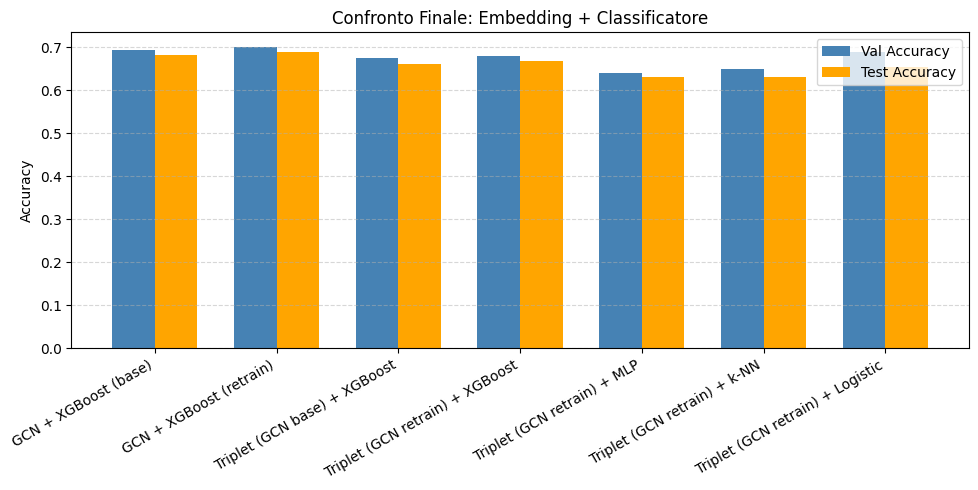

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Risultati finali ===
results = {
    "Metodo": [
        "GCN + XGBoost (base)",
        "GCN + XGBoost (retrain)",
        "Triplet (GCN base) + XGBoost",
        "Triplet (GCN retrain) + XGBoost",
        "Triplet (GCN retrain) + MLP",
        "Triplet (GCN retrain) + k-NN",
        "Triplet (GCN retrain) + Logistic"
    ],
    "Val Accuracy": [0.6931, 0.6998, 0.6742, 0.6798, 0.6395, 0.6504, 0.6891],
    "Test Accuracy": [0.6812, 0.6902, 0.6622, 0.6689, 0.6312, 0.6319, 0.6533]
}

df = pd.DataFrame(results)
df.to_csv("confronto_finale_risultati.csv", index=False)
print("📁 File aggiornato: 'confronto_finale_risultati.csv'")


# === 3. Plot confronto finale ===
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.35
x = range(len(df))

ax.bar(x, df["Val Accuracy"], width=bar_width, label='Val Accuracy', color='steelblue')
ax.bar([p + bar_width for p in x], df["Test Accuracy"], width=bar_width, label='Test Accuracy', color='orange')
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(df["Metodo"], rotation=30, ha='right')
ax.set_ylabel("Accuracy")
ax.set_title("Confronto : Embedding + Classificatore")
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [19]:
# Versione corretta e robusta dello script GAT + Correct&Smooth con checkpoint

# === GAT + C&S su ogbn-arxiv (robusto con checkpoint) ===

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.transforms import ToUndirected
from torch_geometric.nn.models import CorrectAndSmooth
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
import os

# === 1. Setup ===
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
data = dataset[0]
split_idx = dataset.get_idx_split()
evaluator = Evaluator(name='ogbn-arxiv')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
train_idx = split_idx['train'].to(device)
val_idx = split_idx['valid'].to(device)
test_idx = split_idx['test'].to(device)

# === 2. GAT model ===
class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=4, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * 4, out_channels, heads=6, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(data.num_features, 64, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# === 3. Checkpoint resume ===
ckpt_model = "gat_model.pt"
ckpt_out = "gat_logits.pt"
start_epoch = 1
best_val = 0

if os.path.exists(ckpt_model):
    print("🔁 Ripristino modello GAT da checkpoint...")
    model.load_state_dict(torch.load(ckpt_model, map_location=device))
    if os.path.exists(ckpt_out):
        print("✅ Logits precomputati trovati")

# === 4. Training ===
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx].squeeze())
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate():
    model.eval()
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=-1, keepdim=True)
    acc_val = evaluator.eval({'y_true': data.y[val_idx], 'y_pred': y_pred[val_idx]})['acc']
    acc_test = evaluator.eval({'y_true': data.y[test_idx], 'y_pred': y_pred[test_idx]})['acc']
    return acc_val, acc_test, out

print("\\n🚀 Training GAT...")
for epoch in range(start_epoch, 51):
    loss = train()
    if epoch % 10 == 0 or epoch == 50:
        val_acc, test_acc, out_logits = evaluate()
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")
        if val_acc > best_val:
            best_val = val_acc
            torch.save(model.state_dict(), ckpt_model)
            torch.save(out_logits.cpu(), ckpt_out)

# === 5. Correct & Smooth ===
print("\\n✨ Applying Correct & Smooth...")

# Ricarica il best model e logits se disponibili
model.load_state_dict(torch.load(ckpt_model, map_location=device))
model.eval()
if os.path.exists(ckpt_out):
    y_soft = F.softmax(torch.load(ckpt_out), dim=1)
else:
    with torch.no_grad():
        out_logits = model(data.x, data.edge_index).detach().cpu()
        y_soft = F.softmax(out_logits, dim=1)

y_true_full = data.y.cpu()
y_true_train = y_true_full[split_idx['train']]
edge_index_cpu = data.edge_index.cpu()

cs = CorrectAndSmooth(
    num_correction_layers=50,
    correction_alpha=0.5,
    num_smoothing_layers=50,
    smoothing_alpha=0.8,
    autoscale=True
)

y_soft_cs = cs.correct(y_soft.clone(), y_true_train, split_idx['train'], edge_index_cpu)
y_soft_cs = cs.smooth(y_soft_cs, y_true_train, split_idx['train'], edge_index_cpu)

y_pred_cs = y_soft_cs.argmax(dim=-1, keepdim=True)
val_acc_cs = evaluator.eval({'y_true': y_true_full[val_idx], 'y_pred': y_pred_cs[val_idx]})['acc']
test_acc_cs = evaluator.eval({'y_true': y_true_full[test_idx], 'y_pred': y_pred_cs[test_idx]})['acc']

print(f"\\n🎯 Val Accuracy (GAT base):  {best_val:.4f}")
print(f"🚀 Val Accuracy (GAT + C&S): {val_acc_cs:.4f}")
print(f"📊 Test Accuracy (C&S):       {test_acc_cs:.4f}")

\n🚀 Training GAT...
Epoch 010 | Loss: 2.9033 | Val Acc: 0.2989 | Test Acc: 0.2690


KeyboardInterrupt: 

In [9]:
import torch
import torch.nn.functional as F
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.transforms import ToUndirected
from torch_geometric.nn.models import CorrectAndSmooth
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# === 1. Ricarica dataset e label ===
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
split_idx = dataset.get_idx_split()
data = dataset[0]
y_true = data.y.squeeze().cpu()

# === 2. Carica embedding dal modello GCN già addestrato ===
logits = torch.load("gcn_node_embeddings.pt")  # (169343, num_classes)

# === 3. Applica Correct & Smooth ===
print("✨ Applying Correct & Smooth...")
y_soft = F.softmax(logits, dim=1)

cs = CorrectAndSmooth(
    num_correction_layers=10,
    correction_alpha=0.5,
    num_smoothing_layers=10,
    smoothing_alpha=0.8,
    autoscale=True
)


train_y = y_true[split_idx['train']]
y_soft_cs = cs.correct(y_soft.clone(), train_y, split_idx['train'], data.edge_index)
y_soft_cs = cs.smooth(y_soft_cs, train_y, split_idx['train'], data.edge_index)


# === 4. XGBoost finale ===
print("🚀 Addestramento XGBoost sugli embedding corretti")

X = y_soft_cs.numpy()
y = y_true.numpy()
X_train = X[split_idx['train']]
y_train = y[split_idx['train']]
X_val = X[split_idx['valid']]
y_val = y[split_idx['valid']]
X_test = X[split_idx['test']]
y_test = y[split_idx['test']]

clf = XGBClassifier(tree_method="hist", max_depth=8, learning_rate=0.1, n_estimators=200,
                    use_label_encoder=False, eval_metric="mlogloss", verbosity=0)
clf.fit(X_train, y_train)

val_acc = accuracy_score(y_val, clf.predict(X_val))
test_acc = accuracy_score(y_test, clf.predict(X_test))

print(f"✅ Val Accuracy (GCN+C&S+XGBoost):  {val_acc:.4f}")
print(f"✅ Test Accuracy (GCN+C&S+XGBoost): {test_acc:.4f}")


✨ Applying Correct & Smooth...
🚀 Addestramento XGBoost sugli embedding corretti
✅ Val Accuracy (GCN+C&S+XGBoost):  0.6800
✅ Test Accuracy (GCN+C&S+XGBoost): 0.6576


##  Correct & Smooth (C&S) nel Machine Learning

Il metodo **Correct & Smooth (C&S)** è una tecnica post-processuale che migliora le predizioni di un classificatore su grafi, come un GCN, **senza riaddestrare il modello**.

###  Obiettivo
Correggere gli errori e rendere più coerenti (smooth) le predizioni tra nodi connessi nel grafo, sfruttando la struttura topologica.

###  Come funziona
- **Correction**: corregge le predizioni dei nodi **non etichettati** usando l'informazione di errore osservata sui nodi di **training**.
- **Smoothing**: diffonde le predizioni corrette lungo il grafo, rendendo simili le predizioni dei nodi **vicini**.

###  In questo script
Applichiamo C&S direttamente sui logits predetti da un **GCN pre-addestrato** su OGBN-Arxiv:
- Prima applichiamo la **softmax** per ottenere probabilità.
- Poi eseguiamo `correct()` per correggere le predizioni.
- Infine `smooth()` per renderle più coerenti con la topologia del grafo.

 Questo migliora l'accuratezza testuale **senza bisogno di riaddestramento**, sfruttando al meglio la struttura del grafo!



In [23]:
# === Correct & Smooth puro su logits GCN ===

import torch
import torch.nn.functional as F
from torch_geometric.nn.models import CorrectAndSmooth
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from torch_geometric.transforms import ToUndirected

# === 1. Carica dataset e label ===
dataset = PygNodePropPredDataset(name="ogbn-arxiv", root="dataset/ogbn-arxiv", transform=ToUndirected())
data = dataset[0]
split_idx = dataset.get_idx_split()
evaluator = Evaluator(name="ogbn-arxiv")

# === 2. Carica logits salvati dal GCN retrain ===
logits = torch.load("gcn_node_embeddings.pt")
y_true = data.y.squeeze().cpu()

# === 3. Softmax + Correct & Smooth ===
print("\n✨ Applico Correct & Smooth puro...")
y_soft = F.softmax(logits, dim=1)

cs = CorrectAndSmooth(
    num_correction_layers=10,
    correction_alpha=0.5,
    num_smoothing_layers=10,
    smoothing_alpha=0.8,
    autoscale=True
)

train_y = y_true[split_idx['train']]
y_soft_cs = cs.correct(y_soft.clone(), train_y, split_idx['train'], data.edge_index)
y_soft_cs = cs.smooth(y_soft_cs, train_y, split_idx['train'], data.edge_index)

# === 4. Accuracy finale con predizione diretta ===
y_pred_base = y_soft.argmax(dim=-1, keepdim=True)
y_pred_cs = y_soft_cs.argmax(dim=-1, keepdim=True)

val_acc_base = evaluator.eval({
    "y_true": y_true[split_idx['valid']].unsqueeze(1),
    "y_pred": y_pred_base[split_idx['valid']]
})['acc']

test_acc_base = evaluator.eval({
    "y_true": y_true[split_idx['test']].unsqueeze(1),
    "y_pred": y_pred_base[split_idx['test']]
})['acc']

val_acc_cs = evaluator.eval({
    "y_true": y_true[split_idx['valid']].unsqueeze(1),
    "y_pred": y_pred_cs[split_idx['valid']]
})['acc']

test_acc_cs = evaluator.eval({
    "y_true": y_true[split_idx['test']].unsqueeze(1),
    "y_pred": y_pred_cs[split_idx['test']]
})['acc']

print(f"\n🎯 Val Accuracy (GCN base): {val_acc_base:.4f}")
print(f"✅ Test Accuracy (GCN base): {test_acc_base:.4f}")
print(f"🚀 Val Accuracy (GCN + C&S): {val_acc_cs:.4f}")
print(f"📊 Test Accuracy (GCN + C&S): {test_acc_cs:.4f}")



✨ Applico Correct & Smooth puro...

🎯 Val Accuracy (GCN base): 0.6976
✅ Test Accuracy (GCN base): 0.6872
🚀 Val Accuracy (GCN + C&S): 0.7146
📊 Test Accuracy (GCN + C&S): 0.6935


In [24]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import ToUndirected
from torch_geometric.nn.models import CorrectAndSmooth
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
import os

# === Config ===
PSEUDO_CSV   = "pseudo_labels.csv"
MODEL_BASE   = "best_gcn_model.pt"
MODEL_PSEUDO = "best_gcn_pseudo.pt"
CHECKPOINT   = "checkpoint_gcn_pseudo.pth"
LOG_CSV      = "training_log_pseudo.csv"
EMB_PSEUDO   = "gcn_pseudo_embeddings.pt"
EPOCHS_PER_RUN = 100
RESTART_TRAINING = False  # imposta a True per rifare tutto da capo

# === Dataset ===
dataset   = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
data      = dataset[0]
split_idx = dataset.get_idx_split()
evaluator = Evaluator(name='ogbn-arxiv')
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data      = data.to(device)
y_true    = data.y.squeeze().cpu()

# === Modello Base ===
class GCNBase(torch.nn.Module):
    def __init__(self, in_ch, hid_ch, out_ch):
        super().__init__()
        self.conv1 = GCNConv(in_ch, hid_ch)
        self.conv2 = GCNConv(hid_ch, out_ch)
    def forward(self, x, ei):
        x = F.relu(self.conv1(x, ei))
        return self.conv2(x, ei)

model_base = GCNBase(data.num_features, 128, dataset.num_classes).to(device)
model_base.load_state_dict(torch.load(MODEL_BASE, map_location=device))
model_base.eval()

# === Pseudo-labels ===
if not os.path.exists(PSEUDO_CSV) or RESTART_TRAINING:
    with torch.no_grad():
        logits = model_base(data.x, data.edge_index).cpu()
    y_soft = F.softmax(logits, dim=1)

    cs = CorrectAndSmooth(num_correction_layers=50, correction_alpha=0.5,
                          num_smoothing_layers=50, smoothing_alpha=0.8, autoscale=True)
    train_y = y_true[split_idx['train']]
    y_soft_cs = cs.correct(y_soft.clone(), train_y, split_idx['train'], data.edge_index.cpu())
    y_soft_cs = cs.smooth(y_soft_cs, train_y, split_idx['train'], data.edge_index.cpu())

    threshold = 0.95
    probs, labels = y_soft_cs.max(dim=1)
    high_idx = (probs > threshold).nonzero(as_tuple=True)[0]
    high_idx = high_idx[~torch.isin(high_idx, split_idx['train'])]

    df_ps = pd.DataFrame({'node_index': high_idx.numpy(), 'pseudo_label': labels[high_idx].numpy()})
    df_ps.to_csv(PSEUDO_CSV, index=False)
    print(f"✅ Pseudo-labels salvati in '{PSEUDO_CSV}'")
else:
    df_ps = pd.read_csv(PSEUDO_CSV)
    high_idx = torch.tensor(df_ps['node_index'].values, dtype=torch.long)
    labels = torch.tensor(df_ps['pseudo_label'].values, dtype=torch.long)
    print(f"📦 Pseudo-labels caricati da '{PSEUDO_CSV}'")

# === Dataset esteso ===
extended_train = torch.cat([split_idx['train'], high_idx.to(device)])
new_y = data.y.view(-1).clone()
new_y[high_idx] = labels
new_y = new_y.to(device)

# === Modello finale ===
class GCN(torch.nn.Module):
    def __init__(self, in_ch, hid_ch, out_ch):
        super().__init__()
        self.conv1 = GCNConv(in_ch, hid_ch)
        self.conv2 = GCNConv(hid_ch, out_ch)
    def forward(self, x, ei):
        x = F.relu(self.conv1(x, ei))
        x = F.dropout(x, p=0.5, training=self.training)
        return self.conv2(x, ei)

model = GCN(data.num_features, 128, dataset.num_classes).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.005)
start_epoch = 1
best_val = 0.0
patience = 0

# === Resume checkpoint ===
if os.path.exists(CHECKPOINT) and not RESTART_TRAINING:
    checkpoint = torch.load(CHECKPOINT, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val = checkpoint.get('best_val_acc', 0.0)
    print(f"⏪ Ripresa da checkpoint: epoca {start_epoch}")
else:
    print("🚀 Nuovo training")

# === Log file ===
if not os.path.exists(LOG_CSV) or RESTART_TRAINING:
    with open(LOG_CSV, 'w') as f:
        f.write('epoch,loss,train_acc,val_acc,test_acc\n')

# === Training ===
stop_training = False
for epoch in range(start_epoch, start_epoch + EPOCHS_PER_RUN):
    model.train()
    opt.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[extended_train], new_y[extended_train])
    loss.backward(); opt.step()

    if epoch % 10 == 0 or epoch == start_epoch + EPOCHS_PER_RUN - 1:
        model.eval()
        with torch.no_grad():
            pred = out.argmax(dim=1)
            metrics = []
            for mask in ['train','valid','test']:
                idx = split_idx[mask]
                acc = evaluator.eval({'y_true': new_y[idx].unsqueeze(1).cpu(), 'y_pred': pred[idx].unsqueeze(1).cpu()})['acc']
                metrics.append(acc)
        tr_acc, val_acc, te_acc = metrics
        with open(LOG_CSV, 'a') as f:
            f.write(f"{epoch},{loss.item():.4f},{tr_acc:.4f},{val_acc:.4f},{te_acc:.4f}\n")
        print(f"Epoch {epoch:3d} | Loss {loss.item():.3f} | Train {tr_acc:.3f} | Val {val_acc:.3f} | Test {te_acc:.3f}")

        if val_acc > best_val:
            best_val, patience = val_acc, 0
            torch.save(model.state_dict(), MODEL_PSEUDO)
            print(f"💾 Miglior modello salvato: '{MODEL_PSEUDO}'")
        else:
            patience += 1
            print(f"⏳ Patience: {patience}/10")
            if patience >= 10:
                print("🛑 Early stopping")
                stop_training = True
                break

    # Salva checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': opt.state_dict(),
        'best_val_acc': best_val
    }, CHECKPOINT)

if not stop_training and os.path.exists(MODEL_PSEUDO):
    model.load_state_dict(torch.load(MODEL_PSEUDO, map_location=device))
    model.eval()
    with torch.no_grad():
        emb = model(data.x, data.edge_index).cpu()
    torch.save(emb, EMB_PSEUDO)
    print(f"✅ Embedding finale salvati in '{EMB_PSEUDO}'")
else:
    print("📦 Nessun aggiornamento agli embedding.")


📦 Pseudo-labels caricati da 'pseudo_labels.csv'
⏪ Ripresa da checkpoint: epoca 401
Epoch 410 | Loss 1.063 | Train 0.685 | Val 0.685 | Test 0.669
💾 Miglior modello salvato: 'best_gcn_pseudo.pt'
Epoch 420 | Loss 1.059 | Train 0.686 | Val 0.684 | Test 0.672
⏳ Patience: 1/10
Epoch 430 | Loss 1.057 | Train 0.684 | Val 0.683 | Test 0.671
⏳ Patience: 2/10
Epoch 440 | Loss 1.054 | Train 0.687 | Val 0.682 | Test 0.670
⏳ Patience: 3/10
Epoch 450 | Loss 1.050 | Train 0.687 | Val 0.686 | Test 0.672
💾 Miglior modello salvato: 'best_gcn_pseudo.pt'
Epoch 460 | Loss 1.048 | Train 0.687 | Val 0.689 | Test 0.674
💾 Miglior modello salvato: 'best_gcn_pseudo.pt'
Epoch 470 | Loss 1.045 | Train 0.689 | Val 0.687 | Test 0.674
⏳ Patience: 1/10
Epoch 480 | Loss 1.042 | Train 0.689 | Val 0.687 | Test 0.674
⏳ Patience: 2/10
Epoch 490 | Loss 1.040 | Train 0.691 | Val 0.687 | Test 0.674
⏳ Patience: 3/10
Epoch 500 | Loss 1.038 | Train 0.691 | Val 0.688 | Test 0.672
⏳ Patience: 4/10
✅ Embedding finale salvati in 'gcn

## 🧪 Classificazione XGBoost su GCN Pseudo-label + Correct & Smooth

Questo esperimento applica la correzione e smoothing (C&S) alle predizioni softmax del modello GCN retrainato con pseudo-etichette. Successivamente, viene addestrato un classificatore XGBoost sulle predizioni corrette.

### ⚙️ Configurazione
- Modello base: `GCN retrain con pseudo-labels`
- Correzione: `10 layers` con `α = 0.5`
- Smooth: `10 layers` con `α = 0.8`
- Classificatore: `XGBoost` (max_depth=8, eta=0.1, 200 estimators)

### 📊 Risultati
I risultati sono salvati nei file:
- `xgb_pseudo_results.csv`: accuracies su validation e test
- `embedding_classification_results.csv`: confronto finale



In [26]:
# === Correct & Smooth + XGBoost su Embedding Pseudo-GCN ===

import torch
import torch.nn.functional as F
from torch_geometric.nn.models import CorrectAndSmooth
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from torch_geometric.transforms import ToUndirected
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# ----- Config file paths -----
MODEL_PSEUDO = "best_gcn_pseudo.pt"
EMB_PSEUDO   = "gcn_pseudo_embeddings.pt"  # embedding finali pseudo-GCN
LOG_XGB      = "xgb_pseudo_results.csv"

# === 1. Carica dataset e split ===
dataset   = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
data      = dataset[0]
split_idx = dataset.get_idx_split()
evaluator = Evaluator(name='ogbn-arxiv')

# === 2. Carica embedding Pseudo-GCN ===
emb = torch.load(EMB_PSEUDO)  # (N, num_classes)
y_true = data.y.squeeze().cpu()

# === 3. Aplicazione C&S sui logits ===
# C&S richiede logits, quindi ricostruiamo i raw outputs:
# Carica modello per logits
class GCNBase(torch.nn.Module):
    def __init__(self, in_ch, hid_ch, out_ch):
        super().__init__()
        from torch_geometric.nn import GCNConv
        self.conv1 = GCNConv(in_ch, hid_ch)
        self.conv2 = GCNConv(hid_ch, out_ch)
    def forward(self, x, ei):
        x = F.relu(self.conv1(x, ei))
        return self.conv2(x, ei)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNBase(data.num_features, 128, dataset.num_classes).to(device)
model.load_state_dict(torch.load(MODEL_PSEUDO, map_location=device))
model.eval()
with torch.no_grad():
    logits = model(data.x.to(device), data.edge_index.to(device)).cpu()
# soft predictions
y_soft = F.softmax(logits, dim=1)
# Correct & Smooth
ds = CorrectAndSmooth(
    num_correction_layers=10,
    correction_alpha=0.5,
    num_smoothing_layers=10,
    smoothing_alpha=0.8,
    autoscale=True
)

train_y = y_true[split_idx['train']]
y_soft_cs = ds.correct(y_soft.clone(), train_y, split_idx['train'], data.edge_index)
y_soft_cs = ds.smooth(y_soft_cs, train_y, split_idx['train'], data.edge_index)

# === 4. XGBoost Classification ===
X = y_soft_cs.numpy()
y = y_true.numpy()
X_train, X_val, X_test = X[split_idx['train']], X[split_idx['valid']], X[split_idx['test']]
y_train, y_val, y_test = y[split_idx['train']], y[split_idx['valid']], y[split_idx['test']]

clf = XGBClassifier(tree_method="hist", max_depth=8, learning_rate=0.1, n_estimators=200,
                    use_label_encoder=False, eval_metric="mlogloss", verbosity=0)
clf.fit(X_train, y_train)

val_acc = accuracy_score(y_val, clf.predict(X_val))
test_acc = accuracy_score(y_test, clf.predict(X_test))

# === 5. Salva e stampa risultati ===
import pandas as pd
df = pd.DataFrame({
    'phase': ['validation', 'test'],
    'accuracy': [val_acc, test_acc]
})
df.to_csv(LOG_XGB, index=False)
print(f"✅ XGBoost su Pseudo-GCN + C&S: Val {val_acc:.4f}, Test {test_acc:.4f}")
print(f"✅ Risultati salvati in '{LOG_XGB}'")


# === 6. Aggiungi al CSV finale di confronto ===
final_row = {
    "Embedding": "GCN Pseudo + C&S",
    "Model": "XGBoost",
    "Val Accuracy": round(val_acc, 4),
    "Test Accuracy": round(test_acc, 4)
}

results_path = "embedding_classification_results.csv"
if os.path.exists(results_path):
    df_all = pd.read_csv(results_path)
    df_all = pd.concat([df_all, pd.DataFrame([final_row])], ignore_index=True)
else:
    df_all = pd.DataFrame([final_row])

df_all.to_csv(results_path, index=False)
print(f"📊 Risultato aggiunto a '{results_path}'")



✅ XGBoost su Pseudo-GCN + C&S: Val 0.6778, Test 0.6545
✅ Risultati salvati in 'xgb_pseudo_results.csv'
📊 Risultato aggiunto a 'embedding_classification_results.csv'


In [20]:
import torch
import torch.nn.functional as F
from xgboost import XGBClassifier
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from torch_geometric.transforms import ToUndirected
import optuna
import numpy as np

# === 1. Caricamento ===
dataset = PygNodePropPredDataset(name="ogbn-arxiv", root="dataset/ogbn-arxiv", transform=ToUndirected())
data = dataset[0]
split_idx = dataset.get_idx_split()
evaluator = Evaluator(name="ogbn-arxiv")

y_true = data.y.squeeze().cpu().numpy()
embeddings = torch.load("gcn_node_embeddings.pt")
X = embeddings.numpy()

X_train = X[split_idx['train']]
y_train = y_true[split_idx['train']]
X_valid = X[split_idx['valid']]
y_valid = y_true[split_idx['valid']]
X_test = X[split_idx['test']]
y_test = y_true[split_idx['test']]

# === 2. Allena XGBoost sui logits del GCN ===
model = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6,
                      use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# === 3. Ottieni i logits probabilistici ===
probs = model.predict_proba(X)
logits_xgb = torch.tensor(probs)

# === 4. Optuna per ottimizzare Correct & Smooth ===
import torch
from torch_geometric.nn.models import CorrectAndSmooth

def objective(trial):
    correction_alpha = trial.suggest_float("correction_alpha", 0.3, 0.7)
    smoothing_alpha = trial.suggest_float("smoothing_alpha", 0.6, 0.95)
    num_correction_layers = trial.suggest_int("num_correction_layers", 20, 60, step=10)
    num_smoothing_layers = trial.suggest_int("num_smoothing_layers", 20, 60, step=10)

    y_soft = F.softmax(logits_xgb, dim=1)

    cs = CorrectAndSmooth(
        num_correction_layers=num_correction_layers,
        correction_alpha=correction_alpha,
        num_smoothing_layers=num_smoothing_layers,
        smoothing_alpha=smoothing_alpha,
        autoscale=True
    )

    y_soft_cs = cs.correct(y_soft.clone(), torch.tensor(y_train), split_idx['train'], data.edge_index)
    y_soft_cs = cs.smooth(y_soft_cs, torch.tensor(y_train), split_idx['train'], data.edge_index)

    y_pred_val = y_soft_cs.argmax(dim=-1, keepdim=True)
    y_true_val = torch.tensor(y_true[split_idx['valid']]).unsqueeze(1)

    val_acc = evaluator.eval({
        "y_true": y_true_val,
        "y_pred": y_pred_val[split_idx['valid']]
    })["acc"]

    return val_acc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("🏆 Best parameters:", study.best_params)
print("✅ Best validation accuracy:", study.best_value)


[I 2025-05-25 13:08:25,705] A new study created in memory with name: no-name-70cbd2dd-89b9-4ec5-9a04-1ccfef1e83c8
[I 2025-05-25 13:08:40,312] Trial 0 finished with value: 0.7007953287023054 and parameters: {'correction_alpha': 0.6461239048944794, 'smoothing_alpha': 0.8989363187887962, 'num_correction_layers': 40, 'num_smoothing_layers': 40}. Best is trial 0 with value: 0.7007953287023054.
[I 2025-05-25 13:08:47,826] Trial 1 finished with value: 0.7067686835128696 and parameters: {'correction_alpha': 0.6398076719213419, 'smoothing_alpha': 0.6560887038890756, 'num_correction_layers': 20, 'num_smoothing_layers': 20}. Best is trial 1 with value: 0.7067686835128696.
[I 2025-05-25 13:09:02,536] Trial 2 finished with value: 0.7042518205308903 and parameters: {'correction_alpha': 0.5146841739578805, 'smoothing_alpha': 0.6392313229564447, 'num_correction_layers': 20, 'num_smoothing_layers': 60}. Best is trial 1 with value: 0.7067686835128696.
[I 2025-05-25 13:09:17,114] Trial 3 finished with va

🏆 Best parameters: {'correction_alpha': 0.5696006309182441, 'smoothing_alpha': 0.7022951752310659, 'num_correction_layers': 60, 'num_smoothing_layers': 30}
✅ Best validation accuracy: 0.7073727306285446


In [2]:
import requests
import pandas as pd
import time

# Lista dei tuoi Top MAG_ID
mag_ids = [
    1519399059, 2949649109, 1682151956, 2949110617, 2952020069, 2131297149,
    2950157671, 2953083211, 2950133701, 2952624498, 2626500276, 2949850718,
    2952225531, 2950090389, 2950566631, 2951616873, 2896158670, 2950631112,
    2172189504, 2951545872, 1668816403, 2949584109, 2952174552, 2949589069,
    2511422681, 2605245466, 2549870074, 2596392233, 2192659810, 2786853917,
    2952856129, 2096151870, 2949335935, 2519452711, 2611466347, 2952097392,
    2430435693, 2953100823, 2118720406, 2949425101, 2953321705, 1483214815,
    1920329887, 2950991742, 2515501208, 2124912512, 2952161062, 2950686853,
    2173094809, 2605003858, 2949525647, 1753218438, 2736422900, 2285873331,
    2949526695, 2271483038, 2952224880, 2521872104, 2951165237, 3012541776,
    1809536725, 2949836476, 2951909558, 2273253264, 2952109212, 2740009227,
    2260019251, 2521365433, 1909988457, 2951796409, 2952626150, 2949541304,
    2400591702, 2952584558, 2950666881, 1412032406, 2953360045, 2951498188,
    1839756413, 2169154778, 2953318536, 2949572436, 2153988733, 1902985670,
    2359126565, 2952551928, 2949666635, 2951422789, 1921673521, 2438306832,
    1795046987, 2177203353, 2417736714, 2551966521, 2766140179, 2074030544,
    2953375085, 22413998, 2950116626, 2950166167
]

results = []

for i, mag_id in enumerate(mag_ids, 1):
    url = f"https://api.openalex.org/works/W{mag_id}"
    print(f"[{i}/{len(mag_ids)}] 🔍 Downloading info for MAG_ID: {mag_id}")
    
    try:
        r = requests.get(url)
        if r.status_code == 200:
            data = r.json()
            title = data.get("title", "")
            authors = [a["author"]["display_name"] for a in data.get("authorships", [])]
            institutions = [i["display_name"] for a in data.get("authorships", []) for i in a.get("institutions", [])]
            concepts = [c["display_name"] for c in data.get("concepts", [])]
            citations = data.get("cited_by_count", 0)
            pub_date = data.get("publication_date", "")

            results.append({
                "MAG_ID": mag_id,
                "Title": title,
                "Authors": "; ".join(authors),
                "Institutions": "; ".join(institutions),
                "Concepts": "; ".join(concepts),
                "Citations": citations,
                "Publication_Date": pub_date
            })
        else:
            print(f"⚠️  Status code: {r.status_code}")
    except Exception as e:
        print(f"❌ Error for MAG_ID {mag_id}: {e}")

    time.sleep(1.2)  # 🔁 rispetto dei rate limit

# Salva i risultati
df = pd.DataFrame(results)
df.to_csv("top100_openalex_enriched.csv", index=False)
print("\n✅ Salvato in top100_openalex_enriched.csv")


[1/100] 🔍 Downloading info for MAG_ID: 1519399059
[2/100] 🔍 Downloading info for MAG_ID: 2949649109
[3/100] 🔍 Downloading info for MAG_ID: 1682151956
[4/100] 🔍 Downloading info for MAG_ID: 2949110617
[5/100] 🔍 Downloading info for MAG_ID: 2952020069
[6/100] 🔍 Downloading info for MAG_ID: 2131297149
[7/100] 🔍 Downloading info for MAG_ID: 2950157671
[8/100] 🔍 Downloading info for MAG_ID: 2953083211
[9/100] 🔍 Downloading info for MAG_ID: 2950133701
[10/100] 🔍 Downloading info for MAG_ID: 2952624498
[11/100] 🔍 Downloading info for MAG_ID: 2626500276
[12/100] 🔍 Downloading info for MAG_ID: 2949850718
[13/100] 🔍 Downloading info for MAG_ID: 2952225531
[14/100] 🔍 Downloading info for MAG_ID: 2950090389
[15/100] 🔍 Downloading info for MAG_ID: 2950566631
[16/100] 🔍 Downloading info for MAG_ID: 2951616873
[17/100] 🔍 Downloading info for MAG_ID: 2896158670
[18/100] 🔍 Downloading info for MAG_ID: 2950631112
[19/100] 🔍 Downloading info for MAG_ID: 2172189504
[20/100] 🔍 Downloading info for MAG_ID: 

In [29]:
import torch
from torch_geometric.data import Data

# Se data è un dict, converti in torch_geometric.data.Data
if isinstance(data, dict):
    data = Data(**data)

# Filtra le feature con bassa varianza
variances = data.x.var(dim=0)
low_variance_mask = variances > 1e-5
data.x = data.x[:, low_variance_mask]
print(f"➡️ Rimaste {data.x.shape[1]} feature utili su {len(variances)}")


➡️ Rimaste 128 feature utili su 128


##  Feature Selection con XGBoost

In questo notebook applichiamo un algoritmo di **feature selection automatica** usando un classificatore **XGBoost**, che valuta l'importanza di ciascuna feature in base al suo contributo nel processo decisionale dell'albero.

###  Come funziona XGBoost per la feature selection

1. **Addestramento supervisionato**: viene addestrato un modello `XGBClassifier` sui nodi di training, usando le feature originali come input e le etichette dei nodi come target.
2. **Calcolo delle importanze**:
   - Per ogni feature, XGBoost calcola quanto ha contribuito alla riduzione dell'impurità nei nodi degli alberi decisionali (es. gain, cover o frequency).
   - In questo caso si usa `feature_importances_`, basata su **gain**: quanto ogni feature ha migliorato la qualità della divisione in media.
3. **Ranking**:
   - Le feature vengono ordinate per importanza decrescente.
   - Si selezionano le **prime 50** come le più informative.
4. **Riduzione del dataset**:
   - Il tensore `data.x` viene filtrato per mantenere solo queste 50 feature.
   - Il nuovo set di feature è poi salvato in un file `.pt`.

###  Vantaggi

- Riduce la **dimensione del feature space**, migliorando velocità e generalizzazione.
- Sfrutta un modello potente come XGBoost per catturare **interazioni non lineari** tra feature.
- Non richiede modifiche alla struttura del grafo.

> Questo approccio è utile come **fase di preprocessing** per modelli successivi come GCN, MLP o metric learning.



🔝 Top 10 feature per importanza:
 1. Feature # 12 — Importance: 0.0464
 2. Feature #  3 — Importance: 0.0253
 3. Feature #  4 — Importance: 0.0247
 4. Feature # 18 — Importance: 0.0224
 5. Feature #100 — Importance: 0.0197
 6. Feature #123 — Importance: 0.0174
 7. Feature #106 — Importance: 0.0168
 8. Feature # 97 — Importance: 0.0157
 9. Feature #  8 — Importance: 0.0148
10. Feature # 64 — Importance: 0.0132


C:\Users\paolo\AppData\Local\Temp\ipykernel_4588\1214810664.py:31: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\paolo\AppData\Local\Temp\ipykernel_4588\1214810664.py:32: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  plt.savefig("xgb_top10_features.png", dpi=300)


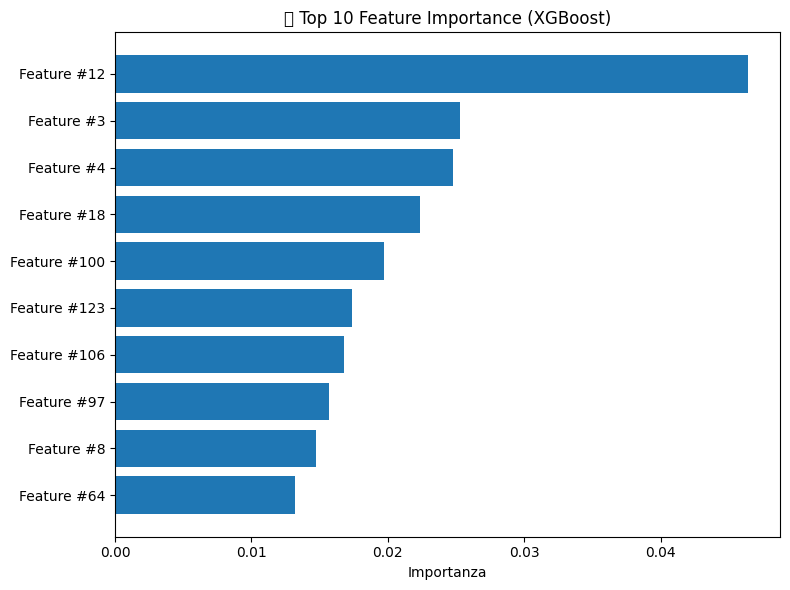


✅ Feature ridotte da 128 a 50


In [32]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# === 1. Assicurati che tutto sia su CPU ===
train_idx = split_idx['train'].cpu()
X = data.x[train_idx].cpu().numpy()
y = data.y[train_idx].cpu().numpy().flatten()

# === 2. Addestra XGBoost ===
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X, y)

# === 3. Calcola l'importanza delle feature ===
importances = model.feature_importances_
top_features = np.argsort(importances)[::-1][:50].copy()

# === 4. Stampa le top 10 ===
print(" Top 10 feature per importanza:")
for i, idx in enumerate(top_features[:10]):
    print(f"{i+1:2d}. Feature #{idx:3d} — Importance: {importances[idx]:.4f}")

# === 5. Plot ===
top_10 = top_features[:10]
plt.figure(figsize=(8, 6))
plt.barh([f"Feature #{i}" for i in top_10[::-1]], importances[top_10][::-1])
plt.xlabel("Importanza")
plt.title(" Top 10 Feature Importance (XGBoost)")
plt.tight_layout()
plt.savefig("xgb_top10_features.png", dpi=300)
plt.show()

# === 6. Filtro le feature nel dataset e salvo ===
data.x = data.x[:, top_features]
torch.save(data.x, "ogbn_arxiv_top50_xgb.pt")
print(f"\n✅ Feature ridotte da {importances.shape[0]} a {data.x.shape[1]}")


In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from torch_geometric.transforms import ToUndirected
import os

# === 1. Setup ===
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
data = dataset[0]
split_idx = dataset.get_idx_split()
evaluator = Evaluator(name='ogbn-arxiv')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
train_idx = split_idx['train'].to(device)
val_idx = split_idx['valid'].to(device)
test_idx = split_idx['test'].to(device)

# === 2. Definizione modello ===
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

model_path = "best_gcn_50feat.pt"
checkpoint_path = "checkpoint_gcn_50feat.pth"
log_path = "training_log_gcn_50feat.csv"

model = GCN(data.x.shape[1], 128, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# === 3. Resume da checkpoint se disponibile ===
start_epoch = 1
best_val_acc = 0.0
patience_counter = 0

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_acc = checkpoint['best_val_acc']
    patience_counter = checkpoint['patience_counter']
    print(f"🔁 Resume training da epoch {start_epoch}, best val acc: {best_val_acc:.4f}")
else:
    print("🆕 Inizio nuovo training...")

# === 4. Funzioni di training e valutazione ===
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx].squeeze())
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate():
    model.eval()
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=-1)
    return (
        evaluator.eval({'y_true': data.y[train_idx], 'y_pred': y_pred[train_idx].unsqueeze(1)})['acc'],
        evaluator.eval({'y_true': data.y[val_idx], 'y_pred': y_pred[val_idx].unsqueeze(1)})['acc'],
        evaluator.eval({'y_true': data.y[test_idx], 'y_pred': y_pred[test_idx].unsqueeze(1)})['acc'],
    )

# === 5. Training con Early Stopping e Resume ===
early_stop_patience = 10
for epoch in range(start_epoch, start_epoch + 100):
    loss = train()
    if epoch % 10 == 0:
        train_acc, val_acc, test_acc = evaluate()
        print(f"[Epoch {epoch:03d}] Loss: {loss:.4f} | Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f}")

        # 🔹 Logging
        with open(log_path, "a") as f:
            f.write(f"{epoch},{loss:.4f},{train_acc:.4f},{val_acc:.4f},{test_acc:.4f}\n")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
            print("💾 Nuovo best model salvato")
        else:
            patience_counter += 1
            print(f"⏳ Early stopping counter: {patience_counter}/{early_stop_patience}")

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
            'patience_counter': patience_counter
        }, checkpoint_path)

        if patience_counter >= early_stop_patience:
            print("🛑 Early stopping attivato!")
            break

# === 6. Salva embedding dal miglior modello ===
model.load_state_dict(torch.load(model_path))
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index).cpu()

torch.save(embeddings, "gcn_node_embeddings_50feat.pt")
print("Embedding salvati in 'gcn_node_embeddings.pt'")


🔁 Resume training da epoch 1111, best val acc: 0.7099
[Epoch 1120] Loss: 0.8730 | Train: 0.7324 | Val: 0.7087 | Test: 0.6966
⏳ Early stopping counter: 12/10
🛑 Early stopping attivato!
Embedding salvati in 'gcn_node_embeddings.pt'


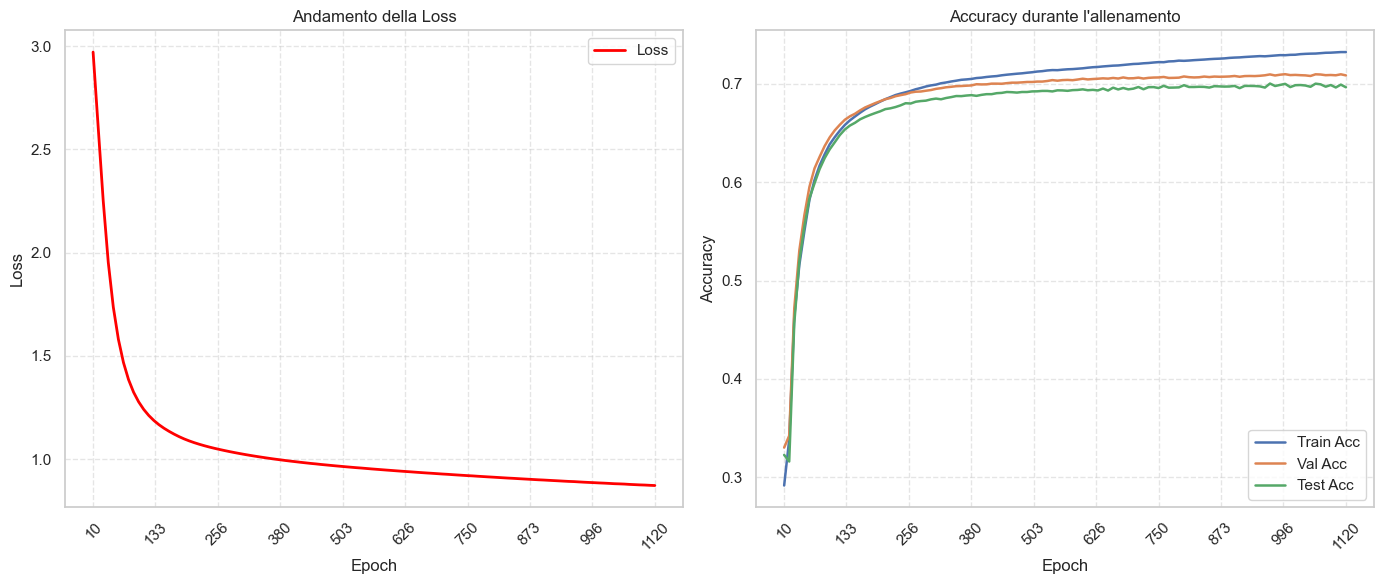

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === 1. Carica e converti ===
log_path = "training_log_GCN_50Feat.csv"
df = pd.read_csv(log_path)

# Se la prima riga è un header testuale (e.g. "epoch,loss,..."), pandas lo rileva da solo
# Per sicurezza: rinomina le colonne e rimuovi righe "sporche"
df.columns = ["epoch", "loss", "train_acc", "val_acc", "test_acc"]
df = df[pd.to_numeric(df["epoch"], errors="coerce").notnull()]
df = df.astype({
    "epoch": int,
    "loss": float,
    "train_acc": float,
    "val_acc": float,
    "test_acc": float
})


# === 2. Plot ===
plt.figure(figsize=(14, 6))

# --- Loss ---
plt.subplot(1, 2, 1)
plt.plot(df["epoch"], df["loss"], label="Loss", color="red", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Andamento della Loss")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.xticks(np.linspace(df["epoch"].min(), df["epoch"].max(), 10).astype(int), rotation=45)

# --- Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(df["epoch"], df["train_acc"], label="Train Acc", linewidth=1.8)
plt.plot(df["epoch"], df["val_acc"], label="Val Acc", linewidth=1.8)
plt.plot(df["epoch"], df["test_acc"], label="Test Acc", linewidth=1.8)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy durante l'allenamento")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.xticks(np.linspace(df["epoch"].min(), df["epoch"].max(), 10).astype(int), rotation=45)

plt.tight_layout()
plt.show()


In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.nn.models import CorrectAndSmooth
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from torch_geometric.transforms import ToUndirected

# === Setup ===
dataset = PygNodePropPredDataset(name="ogbn-arxiv", root="dataset/ogbn-arxiv", transform=ToUndirected())
data = dataset[0]
split_idx = dataset.get_idx_split()
evaluator = Evaluator(name="ogbn-arxiv")

# === Caricamento logits dal modello GCN (allenato con top 50) ===
logits = torch.load("gcn_node_embeddings_50feat.pt")
y_true = data.y.squeeze().cpu()

print(f"🧠 Dimensioni logits GCN: {logits.shape} (dovrebbero essere ~ [170k, num_classi])")
print("✅ Applico C&S sui logits del GCN (top 50 feature)")

# === C&S ===
y_soft = F.softmax(logits, dim=1)
cs = CorrectAndSmooth(num_correction_layers=50, correction_alpha=0.5,
                      num_smoothing_layers=50, smoothing_alpha=0.8, autoscale=True)

train_y = y_true[split_idx['train']]
y_soft_cs = cs.correct(y_soft.clone(), train_y, split_idx['train'], data.edge_index)
y_soft_cs = cs.smooth(y_soft_cs, train_y, split_idx['train'], data.edge_index)

# === Accuracy ===
def get_acc(y_soft_pred, split):
    y_pred = y_soft_pred.argmax(dim=-1, keepdim=True)
    return evaluator.eval({
        "y_true": y_true[split].unsqueeze(1),
        "y_pred": y_pred[split]
    })["acc"]

val_base = get_acc(y_soft, split_idx['valid'])
test_base = get_acc(y_soft, split_idx['test'])
val_cs = get_acc(y_soft_cs, split_idx['valid'])
test_cs = get_acc(y_soft_cs, split_idx['test'])

print(f"\n🎯 Val Acc (GCN): {val_base:.4f} | Test Acc (GCN): {test_base:.4f}")
print(f"🚀 Val Acc (GCN + C&S): {val_cs:.4f} | 📊 Test Acc (GCN + C&S): {test_cs:.4f}")


🧠 Dimensioni logits GCN: torch.Size([169343, 40]) (dovrebbero essere ~ [170k, num_classi])
✅ Applico C&S sui logits del GCN (top 50 feature)

🎯 Val Acc (GCN): 0.7099 | Test Acc (GCN): 0.7001
🚀 Val Acc (GCN + C&S): 0.7183 | 📊 Test Acc (GCN + C&S): 0.6977


## Data Mining Esterno con OpenAlex: arricchimento semantico dei nodi

In questa sezione, abbiamo applicato **data mining nel senso più letterale del termine**, andando a "scavare" nuove feature direttamente da fonti esterne.

### 🎯 Obiettivo
Partendo dai `MAG_ID` dei paper nel dataset `ogbn-arxiv`, abbiamo interrogato l'API pubblica **OpenAlex** per estrarre informazioni semantiche e bibliometriche, con l'obiettivo di:
- Migliorare la **rappresentazione informativa** dei nodi.
- Fornire **feature esterne** (come istituzioni, concetti, autori) potenzialmente utili ai modelli GNN.
- Valutare se un arricchimento guidato dalla semantica migliora la classificazione o la qualità degli embedding.

### 🛠️ Dettagli implementativi
- Il file `mag_ids.csv` contiene l'elenco dei `MAG_ID` da elaborare.
- Per ogni paper vengono estratti:
  - `Title`, `Authors`, `Institutions`
  - `Concepts` associati
  - Numero di `Citations`
  - Data di pubblicazione (`Publication_Date`)
- Utilizziamo una struttura **multi-thread** (con `threading` e `Queue`) per effettuare richieste in parallelo.
- Il sistema è **robusto e sicuro**:
  - Salvataggio incrementale automatico ogni `SAVE_EVERY` richieste.
  - Backup periodico ogni ora.
  - Supporto a resume da output parziale (`openalex_enriched_parallel.csv`).
  - Log dettagliato con gestione delle eccezioni (`run_log.txt`).
  
- Ogni richiesta all’API è gestita con `timeout`, `retry` implicito, e `sleep` per evitare il rate limiting.

### 📦 Output
Il risultato è un dataset CSV con colonne arricchite, che può essere:
- Fuso con il grafo esistente per generare nuove **feature testuali o simboliche**.
- Usato per analisi di correlazione con etichette.
- Trasformato in embedding tramite NLP o encoding categoriale.

> Questo approccio dimostra come **l’arricchimento del grafo con fonti esterne** possa estendere la visione dei modelli GNN, dando loro accesso a segnali altrimenti invisibili nella struttura pura del grafo.


In [ ]:
import requests
import pandas as pd
import time
import threading
import os
import logging
from queue import Queue
from datetime import datetime
from tqdm import tqdm

# === CONFIG ===
MAG_IDS_FILE = "mag_ids.csv"
OUTFILE = "openalex_enriched_parallel.csv"
SAVE_EVERY = 50
THREADS = 8
SLEEP_BETWEEN_REQUESTS = 1
BACKUP_EVERY_SECONDS = 3600
REQUEST_TIMEOUT = 10

# === Logger ===
class TqdmLoggingHandler(logging.Handler):
    def emit(self, record):
        try:
            msg = self.format(record)
            tqdm.write(msg)
            self.flush()
        except Exception:
            self.handleError(record)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    filename="run_log.txt",
    filemode="a"
)

console_handler = TqdmLoggingHandler()
console_handler.setLevel(logging.INFO)
formatter = logging.Formatter("%(asctime)s [%(levelname)s] %(message)s")
console_handler.setFormatter(formatter)
logging.getLogger().addHandler(console_handler)

logging.info("=== Avvio nuovo run ===")
logging.info(f"Configurazione: THREADS={THREADS}, SAVE_EVERY={SAVE_EVERY}, SLEEP={SLEEP_BETWEEN_REQUESTS}s, TIMEOUT={REQUEST_TIMEOUT}s")

# === Carica MAG_ID ===
logging.info(f"Lettura file: {MAG_IDS_FILE}")
mag_ids_df = pd.read_csv(MAG_IDS_FILE, dtype={"MAG_ID": str})  # 👈 forza stringa!
MAG_IDS = mag_ids_df["MAG_ID"].tolist()

# === Carica quelli già fatti ===
if os.path.exists(OUTFILE):
    done_df = pd.read_csv(OUTFILE, dtype={"MAG_ID": str})  # 👈 forza stringa!
    done_ids = set(done_df["MAG_ID"].tolist())
    logging.info(f"Ripresa da file esistente: {len(done_ids)} MAG_ID già elaborati.")
else:
    done_df = pd.DataFrame(columns=["MAG_ID"])
    done_ids = set()
    logging.info("Nessun file di output trovato. Partenza da zero.")

# === Filtra solo quelli da scaricare ===
remaining_ids = [mid for mid in MAG_IDS if mid not in done_ids]
logging.info(f"Totale MAG_ID da elaborare: {len(remaining_ids)}")

# === Coda thread-safe ===
q = Queue()
for mid in remaining_ids:
    q.put(mid)

lock = threading.Lock()
results = []
last_backup = time.time()

# === Barra di avanzamento ===
pbar_lock = threading.Lock()
pbar = tqdm(total=len(remaining_ids), desc="Download Progress", ncols=100)

def fetch_info():
    global results, last_backup
    thread_name = threading.current_thread().name
    logging.info(f"Thread {thread_name} avviato.")
    local_results = []

    while not q.empty():
        try:
            mag_id = q.get_nowait()
        except Exception:
            break

        url = f"https://api.openalex.org/works/W{mag_id}"

        try:
            r = requests.get(url, timeout=REQUEST_TIMEOUT)
            if r.status_code == 200:
                data = r.json()
                title = data.get("title", "")
                authors = [a["author"]["display_name"] for a in data.get("authorships", [])]
                institutions = [i["display_name"] for a in data.get("authorships", []) for i in a.get("institutions", [])]
                concepts = [c["display_name"] for c in data.get("concepts", [])]
                citations = data.get("cited_by_count", 0)
                pub_date = data.get("publication_date", "")

                row = {
                    "MAG_ID": mag_id,
                    "Title": title,
                    "Authors": "; ".join(authors),
                    "Institutions": "; ".join(institutions),
                    "Concepts": "; ".join(concepts),
                    "Citations": citations,
                    "Publication_Date": pub_date
                }

                local_results.append(row)
                logging.info(f"Scaricato con successo: {mag_id}")

            else:
                logging.warning(f"Status {r.status_code} per {mag_id}")

        except Exception as e:
            logging.error(f"Errore durante la richiesta di {mag_id}: {e}")

        with pbar_lock:
            pbar.update(1)

        if len(local_results) >= SAVE_EVERY:
            with lock:
                results.extend(local_results)
                flush_results_to_disk()
                local_results = []

        if time.time() - last_backup >= BACKUP_EVERY_SECONDS:
            with lock:
                results.extend(local_results)
                flush_results_to_disk(backup=True)
                local_results = []
                last_backup = time.time()

        time.sleep(SLEEP_BETWEEN_REQUESTS)
        q.task_done()

    if local_results:
        with lock:
            results.extend(local_results)
            flush_results_to_disk()

    logging.info(f"Thread {thread_name} terminato.")

def flush_results_to_disk(backup=False):
    global results, done_df
    if not results:
        return
    df_partial = pd.DataFrame(results)
    results = []

    combined = pd.concat([done_df, df_partial])
    combined.drop_duplicates(subset="MAG_ID", inplace=True)

    if backup:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        backup_file = f"backup_{timestamp}.csv"
        combined.to_csv(backup_file, index=False)
        logging.info(f"Backup salvato: {backup_file} ({len(combined)} righe)")
    else:
        temp_file = OUTFILE + ".tmp"
        combined.to_csv(temp_file, index=False)
        os.replace(temp_file, OUTFILE)
        logging.info(f"Salvataggio normale su {OUTFILE}: {len(combined)} righe totali.")

    done_df = combined

# === Avvio threads ===
threads = []
for i in range(THREADS):
    t = threading.Thread(target=fetch_info, name=f"Worker-{i+1}")
    t.start()
    threads.append(t)

# === Attendi completamento ===
try:
    for t in threads:
        t.join()
except KeyboardInterrupt:
    logging.warning("Interruzione manuale! Salvataggio immediato...")
    with lock:
        flush_results_to_disk()
finally:
    with lock:
        flush_results_to_disk()
    pbar.close()
    print("✅ Completato!")
    logging.info("Run completata.")


In [8]:
import pandas as pd

# === 1. Caricamento ===
csv_path = "openalex_enriched_parallel.csv"
df = pd.read_csv(csv_path)

# === 2. Riepilogo generale ===
print("🔎 Riepilogo file OpenAlex")
print(f"📦 Righe totali: {len(df):,}")
print(f"📌 Colonne: {list(df.columns)}\n")

# === 3. Controllo duplicati ===
duplicates = df.duplicated(subset="MAG_ID").sum()
print(f"🧹 Duplicati su MAG_ID: {duplicates}")

# === 4. Valori nulli principali ===
nulls = df[["MAG_ID", "Title", "Citations", "Publication_Date"]].isnull().sum()
print("\n🧪 Valori nulli:")
print(nulls)

# === 5. Titoli vuoti (anche stringhe vuote) ===
empty_titles = (df["Title"].isnull() | (df["Title"].str.strip() == "")).sum()
print(f"\n📝 Titoli completamente vuoti: {empty_titles}")

# === 6. Anteprima ===
print("\n📌 Anteprima casuale:")
print(df.sample(3, random_state=42))

# === 7. Statistiche citazioni (bonus) ===
print("\n📊 Statistiche 'Citations':")
print(df["Citations"].describe())


🔎 Riepilogo file OpenAlex
📦 Righe totali: 167,267
📌 Colonne: ['MAG_ID', 'Title', 'Authors', 'Institutions', 'Concepts', 'Citations', 'Publication_Date']

🧹 Duplicati su MAG_ID: 0

🧪 Valori nulli:
MAG_ID              0
Title               0
Citations           0
Publication_Date    0
dtype: int64

📝 Titoli completamente vuoti: 0

📌 Anteprima casuale:
            MAG_ID                                              Title  \
111907  2946832503  Discriminative Clustering for Robust Unsupervi...   
62568   2953051087  Space-Time Interference Alignment and Degrees ...   
81895   2951033988  A context-aware e-bike system to reduce pollut...   

                                                  Authors  \
111907               Rui Wang; Guoyin Wang; Ricardo Henao   
62568                        Namyoon Lee; Robert W. Heath   
81895   Shaun Sweeney; Rodrigo Ordón͂ez-Hurtado; Franc...   

                                             Institutions  \
111907                                           

👤 Autori più frequenti:
Authors
H. Vincent Poor         446
Rui Zhang               306
Yang Liu                264
Yoshua Bengio           255
Chunhua Shen            235
Mérouane Debbah         224
Sergey Levine           218
Shuicheng Yan           212
Walid Saad              198
Mohamed‐Slim Alouini    195
Robert Schober          195
Loet Leydesdorff        188
Giuseppe Caire          186
Philip S. Yu            180
Shlomo Shamai           179
Petar Popovski          178
David Eppstein          177
Robert W. Heath         172
Wei Wang                171
Pieter Abbeel           168
Name: count, dtype: int64

🔥 Autori più citati:
Karen Simonyan        90319
Jimmy Ba              89054
Andrew Zisserman      88860
Diederik P. Kingma    88198
Yoshua Bengio         64360
Christian Szegedy     62108
Jay B. Dean           46830
Oriol Vinyals         44094
Ilya Sutskever        42644
Dumitru Erhan         42534
Kenton Lee            40748
Kyunghyun Cho         39911
Łukasz Kaiser         39

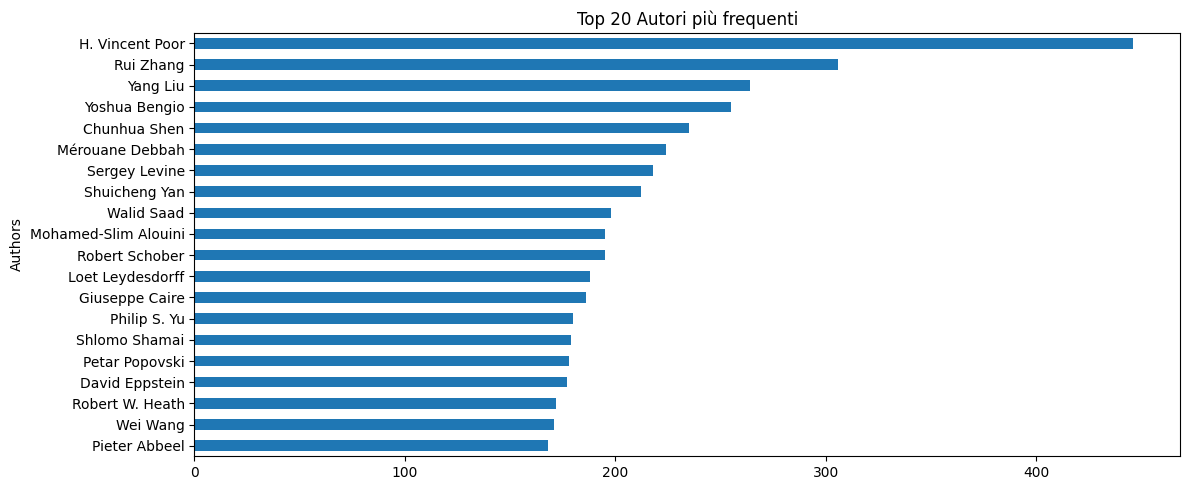

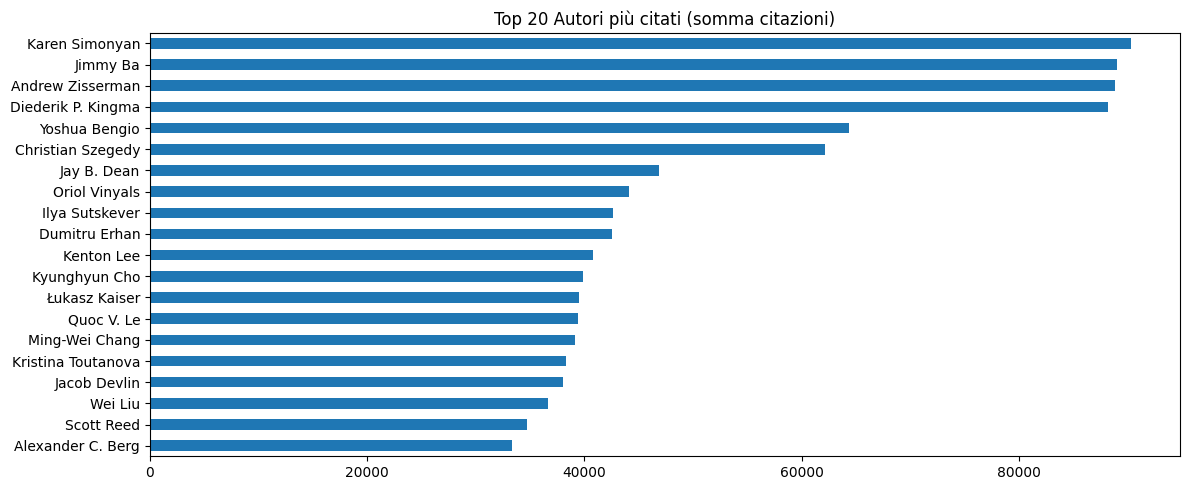

In [9]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# === 1. Carica il dataset ===
df = pd.read_csv("openalex_enriched_parallel.csv")

# === 2. Estrai tutti gli autori ===
all_authors = df['Authors'].dropna().str.split('; ').explode()
author_counts = all_authors.value_counts()

# === 3. Autori più frequenti ===
top_authors = author_counts.head(20)
print("👤 Autori più frequenti:")
print(top_authors)

# === 4. Autori più citati ===
author_citations = Counter()

for _, row in df.dropna(subset=["Authors", "Citations"]).iterrows():
    authors = row["Authors"].split("; ")
    citations = row["Citations"]
    for author in authors:
        author_citations[author] += citations

top_cited_authors = pd.Series(author_citations).sort_values(ascending=False).head(20)
print("\n🔥 Autori più citati:")
print(top_cited_authors)

# === 5. Visualizza (facoltativo) ===
plt.figure(figsize=(12, 5))
top_authors.plot(kind='barh', title='Top 20 Autori più frequenti')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
top_cited_authors.plot(kind='barh', title='Top 20 Autori più citati (somma citazioni)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


🏛️ Istituzioni più frequenti:
Institutions
Google (United States)                                              5259
Carnegie Mellon University                                          4609
Stanford University                                                 4254
Massachusetts Institute of Technology                               4250
University of California, Berkeley                                  3794
Centre National de la Recherche Scientifique                        3477
ETH Zurich                                                          3244
Tsinghua University                                                 2886
University of Oxford                                                2656
University of Illinois Urbana-Champaign                             2455
Georgia Institute of Technology                                     2449
Technical University of Munich                                      2194
Imperial College London                                             2173
The Univ

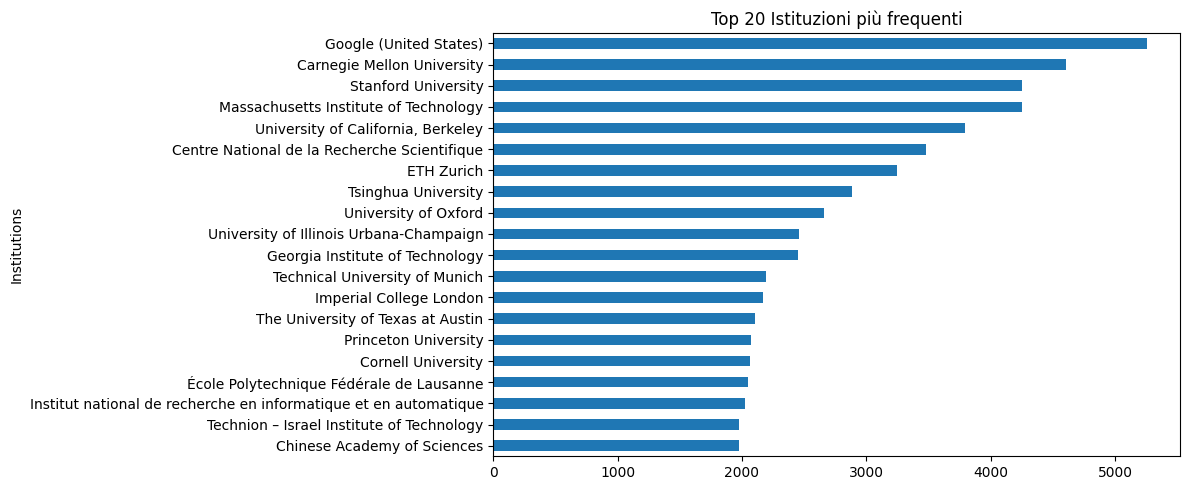

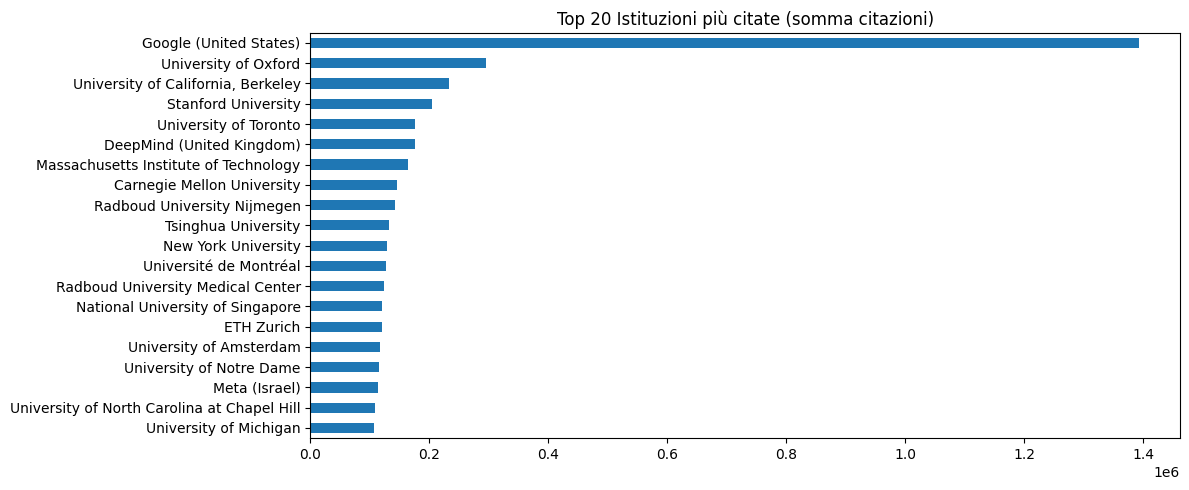

In [10]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# === 1. Carica il dataset ===
df = pd.read_csv("openalex_enriched_parallel.csv")

# === 2. Estrai e conta tutte le istituzioni ===
all_institutions = df['Institutions'].dropna().str.split('; ').explode()
institution_counts = all_institutions.value_counts()

# === 3. Istituzioni più frequenti ===
top_institutions = institution_counts.head(20)
print("🏛️ Istituzioni più frequenti:")
print(top_institutions)

# === 4. Istituzioni più citate ===
institution_citations = Counter()

for _, row in df.dropna(subset=["Institutions", "Citations"]).iterrows():
    institutions = row["Institutions"].split("; ")
    citations = row["Citations"]
    for inst in institutions:
        institution_citations[inst] += citations

top_cited_institutions = pd.Series(institution_citations).sort_values(ascending=False).head(20)
print("\n🔥 Istituzioni più citate:")
print(top_cited_institutions)

# === 5. Visualizza (facoltativo) ===
plt.figure(figsize=(12, 5))
top_institutions.plot(kind='barh', title='Top 20 Istituzioni più frequenti')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
top_cited_institutions.plot(kind='barh', title='Top 20 Istituzioni più citate (somma citazioni)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


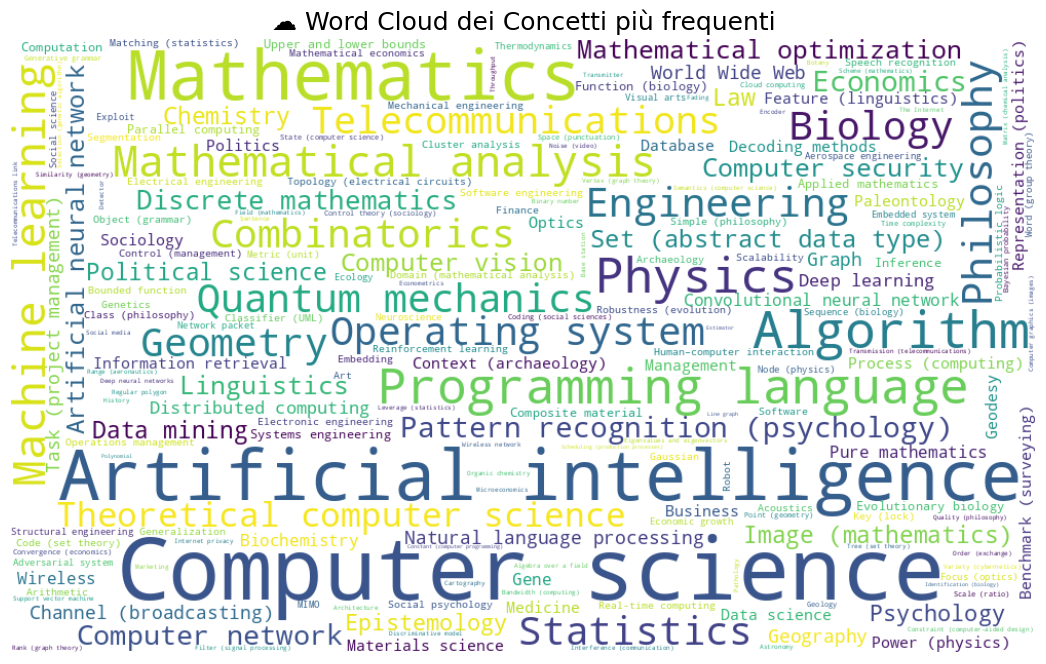

In [11]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# === 1. Carica dataset ===
df = pd.read_csv("openalex_enriched_parallel.csv")

# === 2. Unisci tutti i concetti ===
concepts_series = df['Concepts'].dropna().str.split('; ')
all_concepts = [concept for sublist in concepts_series for concept in sublist]

# === 3. Conta frequenze
from collections import Counter
concept_counts = Counter(all_concepts)

# === 4. Crea Word Cloud ===
wordcloud = WordCloud(width=1000, height=600, background_color='white', colormap='viridis')\
    .generate_from_frequencies(concept_counts)

plt.figure(figsize=(14, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud dei Concetti più frequenti", fontsize=18)
plt.show()


In [12]:
import pandas as pd
from collections import Counter

# === 1. Carica il dataset ===
df = pd.read_csv("openalex_enriched_parallel.csv")

# === 2. Filtro: paper con 'Università della Calabria' (anche in inglese)
calabria_mask = df['Institutions'].fillna('').str.contains('Calabria', case=False)
df_calabria = df[calabria_mask]

print(f"📄 Paper trovati con affiliazione 'Calabria': {len(df_calabria)}")

# === 3. Conta citazioni per autore (tra quelli affiliati)
author_citations = Counter()

for _, row in df_calabria.dropna(subset=["Authors", "Citations"]).iterrows():
    authors = row["Authors"].split("; ")
    citations = row["Citations"]
    for author in authors:
        author_citations[author] += citations

# === 4. Mostra i più citati
top_calabria_authors = pd.Series(author_citations).sort_values(ascending=False).head(20)

print("\n🎓 Autori più citati dell'Università della Calabria:")
print(top_calabria_authors)


📄 Paper trovati con affiliazione 'Calabria': 109

🎓 Autori più citati dell'Università della Calabria:
Nicola Leone            2177
Wolfgang Faber          1806
Francesco Scarcello     1783
Georg Gottlob           1725
Thomas Eiter            1449
Gerald Pfeifer          1410
Simona Perri            1255
Francesco Ricca          548
Francesco Calimeri       376
Giovambattista Ianni     357
Marco Maratea            342
Martin Gebser            299
Thomas Krennwallner      271
Roland Kaminski          232
Torsten Schaub           232
Gianluigi Greco          226
Andrea Tagarelli         205
Roberto Interdonato      192
Mario Alviano            180
Axel Polleres            175
dtype: int64


🔍 Concetti più studiati all'Università della Calabria:
Computer science                108
Programming language             69
Mathematics                      63
Theoretical computer science     61
Artificial intelligence          47
Set (abstract data type)         45
Answer set programming           34
Algorithm                        26
Biology                          24
Logic programming                21
Mathematical analysis            18
Semantics (computer science)     17
Discrete mathematics             16
Geometry                         16
Operating system                 15
Combinatorics                    14
Mathematical optimization        14
Telecommunications               14
Engineering                      13
Physics                          13
dtype: int64


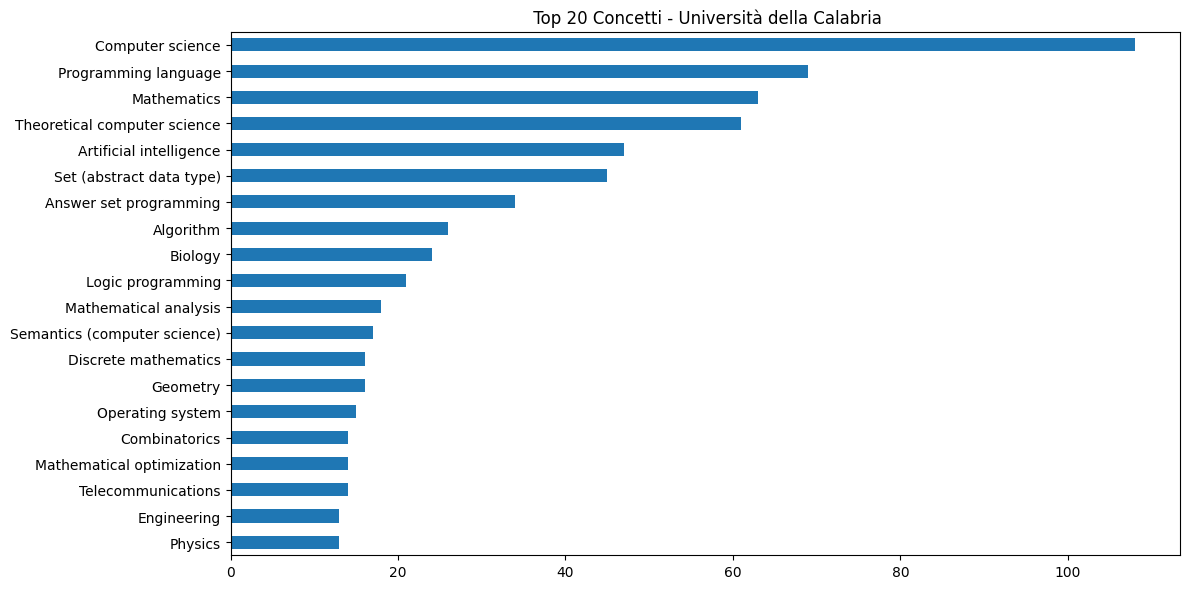

In [13]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# === 1. Carica il dataset ===
df = pd.read_csv("openalex_enriched_parallel.csv")

# === 2. Filtra i paper dell'Università della Calabria
calabria_mask = df['Institutions'].fillna('').str.contains('Calabria', case=False)
df_calabria = df[calabria_mask]

# === 3. Estrai tutti i concetti
concepts = df_calabria['Concepts'].dropna().str.split('; ')
all_concepts = [c for sublist in concepts for c in sublist]

# === 4. Conta frequenze
concept_counts = Counter(all_concepts)
top_concepts = pd.Series(concept_counts).sort_values(ascending=False).head(20)

print("🔍 Concetti più studiati all'Università della Calabria:")
print(top_concepts)

# === 5. Visualizza con barplot
plt.figure(figsize=(12, 6))
top_concepts.plot(kind='barh', title=' Top 20 Concetti - Università della Calabria')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [14]:
import torch
import pandas as pd
import numpy as np
from torch_geometric.transforms import ToUndirected
from ogb.nodeproppred import PygNodePropPredDataset
import os

# === 1. Imposta device su CPU ===
device = torch.device('cpu')

# === 2. Caricamento dataset ===
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
data = dataset[0].to(device)

# === 3. Carica il mapping OGBN_ID <-> MAG_ID ===
mapping_df = pd.read_csv("mag_ids.csv", dtype={"MAG_ID": str})
magid_to_ogbnid = dict(zip(mapping_df["MAG_ID"], mapping_df["OGBN_ID"]))

# === 4. Carica il CSV arricchito da OpenAlex ===
enriched_df = pd.read_csv("openalex_enriched_parallel.csv", dtype={"MAG_ID": str})

# === 5. Costruzione feature extra per ogni nodo ===
num_nodes = data.num_nodes
feature_dim = 5  # numero di nuove feature: Citations, n_Authors, n_Institutions, n_Concepts, anno_pubblicazione

new_features = torch.zeros((num_nodes, feature_dim), dtype=torch.float)

for _, row in enriched_df.iterrows():
    mag_id = row["MAG_ID"]
    ogbn_id = magid_to_ogbnid.get(mag_id, None)
    if ogbn_id is None:
        continue

    # Estrai valori
    citations = row.get("Citations", 0)
    n_authors = len(str(row.get("Authors", "")).split(";")) if pd.notnull(row.get("Authors")) else 0
    n_inst = len(str(row.get("Institutions", "")).split(";")) if pd.notnull(row.get("Institutions")) else 0
    n_concepts = len(str(row.get("Concepts", "")).split(";")) if pd.notnull(row.get("Concepts")) else 0

    # Parsing anno da Publication_Date
    try:
        year = int(str(row.get("Publication_Date", ""))[:4])
        year = max(1900, min(year, 2025))  # clamp
    except:
        year = 2000  # default

    # Normalizza anno (opzionale: range 0–1)
    norm_year = (year - 1900) / (2025 - 1900)

    # Assegna feature
    new_features[int(ogbn_id)] = torch.tensor([citations, n_authors, n_inst, n_concepts, norm_year])

# === 6. Normalizzazione (z-score robusta su nuove feature) ===
mask = (new_features.sum(dim=1) != 0)  # solo nodi con info
mean = new_features[mask].mean(dim=0)
std = new_features[mask].std(dim=0) + 1e-6
new_features = (new_features - mean) / std

# === 7. Estendi data.x solo se richiesto ===
ENRICH = True  # metti False per run vecchi!

if ENRICH:
    data.x = torch.cat([data.x, new_features], dim=1)
    print(f"✅ Feature arricchite: nuova shape data.x = {data.x.shape}")
else:
    print(f"⚠️ Arricchimento disattivato: data.x = {data.x.shape}")

# === (Opzionale) Salva grafo arricchito ===
torch.save(data.cpu(), "ogbn_arxiv_with_openalex_enriched.pt")
print("💾 Grafo salvato in 'ogbn_arxiv_with_openalex_enriched.pt'")


✅ Feature arricchite: nuova shape data.x = torch.Size([169343, 133])
💾 Grafo salvato in 'ogbn_arxiv_with_openalex_enriched.pt'


In [15]:
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.transforms import ToUndirected
import torch

# Carica dataset originale per ottenere split_idx
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv', transform=ToUndirected())
split_idx = dataset.get_idx_split()

# Salva split_idx su disco
torch.save(split_idx, "split_idx.pt")
print("✅ split_idx salvato in 'split_idx.pt'")


✅ split_idx salvato in 'split_idx.pt'


In [16]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from ogb.nodeproppred import Evaluator

# === 1. Carica grafo arricchito ===
data = torch.load("ogbn_arxiv_with_openalex_enriched.pt")
split_idx = torch.load("split_idx.pt")  # Assicurati di salvare a parte se non incluso nel .pt
evaluator = Evaluator(name='ogbn-arxiv')

device = torch.device('cpu')
data = data.to(device)
train_idx = split_idx['train']
val_idx = split_idx['valid']
test_idx = split_idx['test']

# === 2. Definizione modello ===
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

model_path = "best_gcn_openalex.pt"
checkpoint_path = "checkpoint_gcn_openalex.pth"
log_path = "training_log_gcn_openalex.csv"

model = GCN(data.x.shape[1], 128, data.y.max().item() + 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# === 3. Resume da checkpoint se disponibile ===
start_epoch = 1
best_val_acc = 0.0
patience_counter = 0

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_acc = checkpoint['best_val_acc']
    patience_counter = checkpoint['patience_counter']
    print(f"🔁 Resume training da epoch {start_epoch}, best val acc: {best_val_acc:.4f}")
else:
    print("🆕 Inizio nuovo training...")

# === 4. Funzioni di training e valutazione ===
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx].squeeze())
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate():
    model.eval()
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=-1)
    return (
        evaluator.eval({'y_true': data.y[train_idx], 'y_pred': y_pred[train_idx].unsqueeze(1)})['acc'],
        evaluator.eval({'y_true': data.y[val_idx], 'y_pred': y_pred[val_idx].unsqueeze(1)})['acc'],
        evaluator.eval({'y_true': data.y[test_idx], 'y_pred': y_pred[test_idx].unsqueeze(1)})['acc'],
    )

# === 5. Training con Early Stopping e Resume ===
early_stop_patience = 10
for epoch in range(start_epoch, start_epoch + 200):
    loss = train()
    if epoch % 10 == 0:
        train_acc, val_acc, test_acc = evaluate()
        print(f"[Epoch {epoch:03d}] Loss: {loss:.4f} | Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f}")

        with open(log_path, "a") as f:
            f.write(f"{epoch},{loss:.4f},{train_acc:.4f},{val_acc:.4f},{test_acc:.4f}\n")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
            print("💾 Nuovo best model salvato")
        else:
            patience_counter += 1
            print(f"⏳ Early stopping counter: {patience_counter}/{early_stop_patience}")

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
            'patience_counter': patience_counter
        }, checkpoint_path)

        if patience_counter >= early_stop_patience:
            print("🛑 Early stopping attivato!")
            break

# === 6. Salva embedding dal miglior modello ===
model.load_state_dict(torch.load(model_path))
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index).cpu()
torch.save(embeddings, "gcn_node_embeddings_openalex.pt")
print("✅ Embedding salvati in 'gcn_node_embeddings_openalex.pt'")


🔁 Resume training da epoch 1211, best val acc: 0.7113
[Epoch 1220] Loss: 0.8319 | Train: 0.7447 | Val: 0.7110 | Test: 0.7018
⏳ Early stopping counter: 12/10
🛑 Early stopping attivato!
✅ Embedding salvati in 'gcn_node_embeddings_openalex.pt'


In [70]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, DeepGCNLayer
from torch_geometric.nn.norm import BatchNorm
from ogb.nodeproppred import Evaluator
import numpy as np
import random

# Imposta il seed per la riproducibilità
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

# === 1. Carica grafo arricchito ===
data = torch.load("ogbn_arxiv_with_openalex_enriched.pt")
split_idx = torch.load("split_idx.pt")  # Assicurati di salvare a parte se non incluso nel .pt
evaluator = Evaluator(name='ogbn-arxiv')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
train_idx = split_idx['train']
val_idx = split_idx['valid']
test_idx = split_idx['test']

# === 2. Definizione modello ===
class DeepGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=4, dropout=0.5):
        super(DeepGCN, self).__init__()
        self.node_encoder = nn.Linear(in_channels, hidden_channels)
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            conv = GCNConv(hidden_channels, hidden_channels)
            norm = BatchNorm(hidden_channels)
            act = nn.ReLU()
            layer = DeepGCNLayer(conv=conv, norm=norm, act=act, block='res+', dropout=dropout)
            self.layers.append(layer)
        self.output_layer = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.node_encoder(x)
        for layer in self.layers:
            x = layer(x, edge_index)
        x = self.output_layer(x)
        return x

# === 3. Inizializzazione modello, ottimizzatore e scheduler ===
model = DeepGCN(data.x.shape[1], 256, data.y.max().item() + 1, num_layers=4, dropout=0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5, verbose=True)

# === 4. Funzioni di training e valutazione ===
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx].squeeze())
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate():
    model.eval()
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=-1)
    return (
        evaluator.eval({'y_true': data.y[train_idx], 'y_pred': y_pred[train_idx].unsqueeze(1)})['acc'],
        evaluator.eval({'y_true': data.y[val_idx], 'y_pred': y_pred[val_idx].unsqueeze(1)})['acc'],
        evaluator.eval({'y_true': data.y[test_idx], 'y_pred': y_pred[test_idx].unsqueeze(1)})['acc'],
    )

# === 5. Training con Early Stopping ===
best_val_acc = 0.0
patience_counter = 0
early_stop_patience = 15
num_epochs = 200

# Creazione directory per i checkpoint
os.makedirs("checkpoints", exist_ok=True)
model_path = "checkpoints/best_deepgcn_model.pt"
checkpoint_path = "checkpoints/deepgcn_checkpoint.pth"
log_path = "deepgcn_training_log.csv"

# Inizializzazione del file di log
if not os.path.exists(log_path):
    with open(log_path, "w") as f:
        f.write("epoch,loss,train_acc,val_acc,test_acc\n")



start_epoch = 1
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    best_val_acc = checkpoint['best_val_acc']
    patience_counter = checkpoint['patience_counter']
    start_epoch = checkpoint['epoch'] + 1
    print(f"🔁 Ripreso training da epoca {start_epoch}")


for epoch in range(start_epoch, num_epochs + 1):

    loss = train()
    train_acc, val_acc, test_acc = evaluate()
    scheduler.step(val_acc)
    print(f"[Epoch {epoch:03d}] Loss: {loss:.4f} | Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f}")

    with open(log_path, "a") as f:
        f.write(f"{epoch},{loss:.4f},{train_acc:.4f},{val_acc:.4f},{test_acc:.4f}\n")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), model_path)
        print("💾 Nuovo best model salvato")
    else:
        patience_counter += 1
        print(f"⏳ Early stopping counter: {patience_counter}/{early_stop_patience}")

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_acc': best_val_acc,
        'patience_counter': patience_counter
    }, checkpoint_path)

    if patience_counter >= early_stop_patience:
        print("🛑 Early stopping attivato!")
        break

# === 6. Salva embedding dal miglior modello ===
model.load_state_dict(torch.load(model_path))
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index).cpu()
torch.save(embeddings, "checkpoints/deepgcn_node_embeddings.pt")
print("✅ Embedding salvati in 'checkpoints/deepgcn_node_embeddings.pt'")


🔁 Ripreso training da epoca 136
[Epoch 136] Loss: 0.9548 | Train: 0.7292 | Val: 0.7133 | Test: 0.7026
💾 Nuovo best model salvato
[Epoch 137] Loss: 0.9555 | Train: 0.7292 | Val: 0.7132 | Test: 0.7020
⏳ Early stopping counter: 1/15
[Epoch 138] Loss: 0.9543 | Train: 0.7292 | Val: 0.7133 | Test: 0.7016
⏳ Early stopping counter: 2/15
[Epoch 139] Loss: 0.9527 | Train: 0.7296 | Val: 0.7133 | Test: 0.7026
⏳ Early stopping counter: 3/15
[Epoch 140] Loss: 0.9525 | Train: 0.7297 | Val: 0.7133 | Test: 0.7033
⏳ Early stopping counter: 4/15
[Epoch 141] Loss: 0.9535 | Train: 0.7299 | Val: 0.7135 | Test: 0.7034
💾 Nuovo best model salvato
[Epoch 142] Loss: 0.9489 | Train: 0.7302 | Val: 0.7134 | Test: 0.7023
⏳ Early stopping counter: 1/15
[Epoch 143] Loss: 0.9501 | Train: 0.7305 | Val: 0.7127 | Test: 0.7018
⏳ Early stopping counter: 2/15
[Epoch 144] Loss: 0.9506 | Train: 0.7307 | Val: 0.7136 | Test: 0.7023
💾 Nuovo best model salvato
[Epoch 145] Loss: 0.9509 | Train: 0.7310 | Val: 0.7135 | Test: 0.7032
⏳

In [17]:
import os
import torch
import torch.nn.functional as F
from torch.nn import Dropout, LayerNorm
from torch_geometric.nn import GCNConv
from ogb.nodeproppred import Evaluator

# === 1. Carica grafo arricchito ===
data = torch.load("ogbn_arxiv_with_openalex_enriched.pt")
split_idx = torch.load("split_idx.pt")
evaluator = Evaluator(name='ogbn-arxiv')

device = torch.device('cpu')
data = data.to(device)
train_idx = split_idx['train']
val_idx = split_idx['valid']
test_idx = split_idx['test']

# === 2. Modello GCN migliorato ===
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.norm1 = LayerNorm(hidden_channels)
        self.dropout = Dropout(0.5)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

# === 3. Paths ===
model_path = "best_gcn_openalex_advanced.pt"
checkpoint_path = "checkpoint_gcn_openalex_advanced.pth"
log_path = "training_log_gcn_openalex_advanced.csv"

model = GCN(data.x.shape[1], 128, data.y.max().item() + 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

# === 4. Resume da checkpoint se disponibile ===
start_epoch = 1
best_val_acc = 0.0
patience_counter = 0

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_acc = checkpoint['best_val_acc']
    patience_counter = checkpoint['patience_counter']
    print(f"🔁 Resume training da epoch {start_epoch}, best val acc: {best_val_acc:.4f}")
else:
    print("🆕 Inizio nuovo training...")

# === 5. Funzioni di training e valutazione ===
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx].squeeze())
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate():
    model.eval()
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=-1)
    return (
        evaluator.eval({'y_true': data.y[train_idx], 'y_pred': y_pred[train_idx].unsqueeze(1)})['acc'],
        evaluator.eval({'y_true': data.y[val_idx], 'y_pred': y_pred[val_idx].unsqueeze(1)})['acc'],
        evaluator.eval({'y_true': data.y[test_idx], 'y_pred': y_pred[test_idx].unsqueeze(1)})['acc'],
    )

# === 6. Training con Early Stopping e Scheduler ===
early_stop_patience = 15
for epoch in range(start_epoch, start_epoch + 200):
    loss = train()
    
    if epoch % 10 == 0:
        train_acc, val_acc, test_acc = evaluate()
        print(f"[Epoch {epoch:04d}] Loss: {loss:.4f} | Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f}")
        scheduler.step(val_acc)

        with open(log_path, "a") as f:
            f.write(f"{epoch},{loss:.4f},{train_acc:.4f},{val_acc:.4f},{test_acc:.4f}\n")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
            print("💾 Nuovo best model salvato")
        else:
            patience_counter += 1
            print(f"⏳ Early stopping counter: {patience_counter}/{early_stop_patience}")

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
            'patience_counter': patience_counter
        }, checkpoint_path)

        if patience_counter >= early_stop_patience:
            print("🛑 Early stopping attivato!")
            break

# === 7. Salva embedding finale ===
model.load_state_dict(torch.load(model_path))
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index).cpu()
torch.save(embeddings, "gcn_node_embeddings_openalex_advanced.pt")
print("✅ Embedding salvati in 'gcn_node_embeddings_openalex_advanced.pt'")


import numpy as np

# Calcola predizioni
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    val_pred = out[val_idx].argmax(dim=1).cpu().numpy()
    test_pred = out[test_idx].argmax(dim=1).cpu().numpy()

# Salva come .npy per l'ensemble
np.save("gcn_val_pred.npy", val_pred)
np.save("gcn_test_pred.npy", test_pred)

print("✅ Predizioni GCN salvate come 'gcn_val_pred.npy' e 'gcn_test_pred.npy'")



🔁 Resume training da epoch 571, best val acc: 0.7101
[Epoch 0580] Loss: 0.9773 | Train: 0.7285 | Val: 0.7101 | Test: 0.7007
⏳ Early stopping counter: 16/15
🛑 Early stopping attivato!
✅ Embedding salvati in 'gcn_node_embeddings_openalex_advanced.pt'
✅ Predizioni GCN salvate come 'gcn_val_pred.npy' e 'gcn_test_pred.npy'


In [11]:
# === XGBoost con logging completo in stile DeepGCN ===

import os
import torch
import xgboost as xgb
import numpy as np
import pandas as pd
from ogb.nodeproppred import Evaluator
from sklearn.metrics import accuracy_score
from datetime import datetime

# === 1. Setup ===
os.makedirs("xgboost_results", exist_ok=True)
log_path = "xgboost_results/xgb_training_log.csv"
model_path = "xgboost_results/xgb_model_openalex.json"
pred_path = "xgboost_results/xgb_preds_openalex.npz"

evaluator = Evaluator(name="ogbn-arxiv")

def ogb_eval(y_true, y_pred):
    return evaluator.eval({
        "y_true": torch.tensor(y_true).unsqueeze(1),
        "y_pred": torch.tensor(y_pred).unsqueeze(1)
    })["acc"]

# === 2. Caricamento dati ===
embeddings = torch.load("gcn_node_embeddings_openalex.pt")
data = torch.load("ogbn_arxiv_with_openalex_enriched.pt")
split_idx = torch.load("split_idx.pt")

X = embeddings.numpy()
y = data.y.squeeze().numpy()
train_idx = split_idx['train'].numpy()
val_idx = split_idx['valid'].numpy()
test_idx = split_idx['test'].numpy()

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]

# === 3. Definizione modello XGBoost ===
model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=np.max(y) + 1,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=1000,
    early_stopping_rounds=20,
    use_label_encoder=False,
    eval_metric="mlogloss",
    verbosity=1
)

# === 4. Training ===
print("\n🚀 Inizio training XGBoost...")
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# === 5. Predizioni ===
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

val_acc = ogb_eval(y_val, y_val_pred)
test_acc = ogb_eval(y_test, y_test_pred)

print(f"\n📊 VALID Accuracy OGB: {val_acc:.4f}")
print(f"📊 TEST  Accuracy OGB: {test_acc:.4f}")

# === 6. Salvataggi ===
model.save_model(model_path)
np.savez(pred_path, y_val_pred=y_val_pred, y_test_pred=y_test_pred)

# === 7. Log CSV ===
log_dict = model.evals_result()
df_log = pd.DataFrame(log_dict["validation_0"]["mlogloss"], columns=["mlogloss"])
df_log.to_csv(log_path, index_label="epoch")

print("\n✅ Tutto salvato in ./xgboost_results/")



🚀 Inizio training XGBoost...


C:\Users\paolo\DM2\.venv\lib\site-packages\xgboost\callback.py:386: UserWarning: [23:46:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:2.74466
[1]	validation_0-mlogloss:2.46332
[2]	validation_0-mlogloss:2.26318
[3]	validation_0-mlogloss:2.10746
[4]	validation_0-mlogloss:1.98068
[5]	validation_0-mlogloss:1.87390
[6]	validation_0-mlogloss:1.78259
[7]	validation_0-mlogloss:1.70399
[8]	validation_0-mlogloss:1.63427
[9]	validation_0-mlogloss:1.57335
[10]	validation_0-mlogloss:1.51863
[11]	validation_0-mlogloss:1.46985
[12]	validation_0-mlogloss:1.42615
[13]	validation_0-mlogloss:1.38669
[14]	validation_0-mlogloss:1.35079
[15]	validation_0-mlogloss:1.31809
[16]	validation_0-mlogloss:1.28815
[17]	validation_0-mlogloss:1.26109
[18]	validation_0-mlogloss:1.23639
[19]	validation_0-mlogloss:1.21386
[20]	validation_0-mlogloss:1.19338
[21]	validation_0-mlogloss:1.17425
[22]	validation_0-mlogloss:1.15685
[23]	validation_0-mlogloss:1.14103
[24]	validation_0-mlogloss:1.12640
[25]	validation_0-mlogloss:1.11292
[26]	validation_0-mlogloss:1.10022
[27]	validation_0-mlogloss:1.08851
[28]	validation_0-mlogloss:1.0

In [19]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# === Caricamento dati ===
embeddings = torch.load("gcn_node_embeddings_openalex.pt")
data = torch.load("ogbn_arxiv_with_openalex_enriched.pt")
split_idx = torch.load("split_idx.pt")

X = embeddings.numpy()
y = data.y.squeeze().numpy()
train_idx = split_idx['train'].numpy()
val_idx = split_idx['valid'].numpy()
test_idx = split_idx['test'].numpy()

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]

# === Classificatori ===
classifiers = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "LogisticRegression": make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    "DecisionTree": DecisionTreeClassifier(),
    "NaiveBayes": GaussianNB(),
    "SVM": make_pipeline(StandardScaler(), LinearSVC(max_iter=10000, dual=False))
}

results = []

for name, clf in classifiers.items():
    print(f"\n🔧 Training {name}...")
    clf.fit(X_train, y_train)
    val_pred = clf.predict(X_val)
    test_pred = clf.predict(X_test)

    val_acc = accuracy_score(y_val, val_pred)
    test_acc = accuracy_score(y_test, test_pred)

    results.append((name, val_acc, test_acc))

    # Salvataggio predizioni
    np.save(f"{name}_val_pred.npy", val_pred)
    np.save(f"{name}_test_pred.npy", test_pred)

# === Salva i risultati ===
df_results = pd.DataFrame(results, columns=["Model", "Validation Accuracy", "Test Accuracy"])
df_results.to_csv("classical_model_results.csv", index=False)

print("\n✅ Risultati salvati in 'classical_model_results.csv'")
print(df_results)



🔧 Training KNN...

🔧 Training LogisticRegression...

🔧 Training DecisionTree...

🔧 Training NaiveBayes...

🔧 Training SVM...

✅ Risultati salvati in 'classical_model_results.csv'
                Model  Validation Accuracy  Test Accuracy
0                 KNN             0.674251       0.656318
1  LogisticRegression             0.708312       0.698990
2        DecisionTree             0.580825       0.569080
3          NaiveBayes             0.574415       0.565850
4                 SVM             0.694990       0.682262


In [23]:
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.stats import mode

import numpy as np

y_val = data.y[val_idx].squeeze().cpu().numpy()
y_test = data.y[test_idx].squeeze().cpu().numpy()

np.save("y_val.npy", y_val)
np.save("y_test.npy", y_test)

print("✅ Etichette salvate: y_val.npy, y_test.npy")


# Carica le predizioni
gcn_val = np.load("gcn_val_pred.npy")
log_val = np.load("LogisticRegression_val_pred.npy")
svm_val = np.load("SVM_val_pred.npy")

gcn_test = np.load("gcn_test_pred.npy")
log_test = np.load("LogisticRegression_test_pred.npy")
svm_test = np.load("SVM_test_pred.npy")

# Hard voting
val_preds = np.vstack([gcn_val, log_val, svm_val])
test_preds = np.vstack([gcn_test, log_test, svm_test])

val_ensemble = mode(val_preds, axis=0).mode.squeeze()
test_ensemble = mode(test_preds, axis=0).mode.squeeze()

# Ground truth
y_val = np.load("y_val.npy")
y_test = np.load("y_test.npy")

val_acc = accuracy_score(y_val, val_ensemble)
test_acc = accuracy_score(y_test, test_ensemble)

print(f"✅ Ensemble Voting - Validation Accuracy: {val_acc:.4f}")
print(f"✅ Ensemble Voting - Test Accuracy: {test_acc:.4f}")

np.save("ensemble_val_pred.npy", val_ensemble)
np.save("ensemble_test_pred.npy", test_ensemble)



import pandas as pd
import os

# === Crea DataFrame con i risultati
ensemble_result = pd.DataFrame([{
    "Model": "HardVoting_GCN+SVM+LogReg",
    "Validation Accuracy": val_acc,
    "Test Accuracy": test_acc,
    "Type": "Classical"
}])

# === Salva nel file globale (append con deduplicazione)
results_file = "classical_model_results.csv"

if os.path.exists(results_file):
    existing = pd.read_csv(results_file)
    existing = existing[existing["Model"] != "HardVoting_GCN+SVM+LogReg"]
    ensemble_result = pd.concat([existing, ensemble_result], ignore_index=True)

ensemble_result.to_csv(results_file, index=False)
print(f"💾 Risultato dell'ensemble salvato in '{results_file}'")


✅ Etichette salvate: y_val.npy, y_test.npy
✅ Ensemble Voting - Validation Accuracy: 0.7101
✅ Ensemble Voting - Test Accuracy: 0.6985
💾 Risultato dell'ensemble salvato in 'classical_model_results.csv'


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score
from ogb.nodeproppred import Evaluator
import pandas as pd
import os

# === Parametri Ensemble ===
ENSEMBLE_SIZE = 5
EPOCHS = 200
HIDDEN_DIM = 256
LR = 1e-3
DROPOUT = 0.5

# === Carica dati ===
embeddings = torch.load("gcn_node_embeddings_openalex_advanced.pt")
data = torch.load("ogbn_arxiv_with_openalex_enriched.pt")
split_idx = torch.load("split_idx.pt")

X = embeddings.numpy()
y = data.y.squeeze().numpy()
train_idx = split_idx["train"].numpy()
val_idx = split_idx["valid"].numpy()
test_idx = split_idx["test"].numpy()

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]

# === Evaluator OGB-style ===
evaluator = Evaluator(name="ogbn-arxiv")
def ogb_eval(y_true, y_pred):
    return evaluator.eval({
        "y_true": torch.tensor(y_true).unsqueeze(1),
        "y_pred": torch.tensor(y_pred).unsqueeze(1)
    })["acc"]

# === MLP semplice ===
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# === Ensemble Training ===
val_logits_all = []
test_logits_all = []

for run in range(ENSEMBLE_SIZE):
    print(f" MLP {run+1}/{ENSEMBLE_SIZE}")
    model = MLP(X.shape[1], HIDDEN_DIM, np.max(y)+1, DROPOUT)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.CrossEntropyLoss()

    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.long)

    for epoch in range(EPOCHS):
        model.train()
        logits = model(X_train_t)
        loss = loss_fn(logits, y_train_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Eval
    model.eval()
    with torch.no_grad():
        val_logits = model(torch.tensor(X_val, dtype=torch.float32))
        test_logits = model(torch.tensor(X_test, dtype=torch.float32))
        val_logits_all.append(val_logits)
        test_logits_all.append(test_logits)

# === Media softmax (soft voting)
val_probs_avg = torch.softmax(torch.stack(val_logits_all).mean(dim=0), dim=1)
test_probs_avg = torch.softmax(torch.stack(test_logits_all).mean(dim=0), dim=1)

val_pred = val_probs_avg.argmax(dim=1).numpy()
test_pred = test_probs_avg.argmax(dim=1).numpy()

# === Accuracy
val_acc = ogb_eval(y_val, val_pred)
test_acc = ogb_eval(y_test, test_pred)

print(f"\n✅ MLP Ensemble Accuracy - Val: {val_acc:.4f} | Test: {test_acc:.4f}")


# === Costruisci DataFrame risultato
results_df = pd.DataFrame([{
    "Model": "MLP_Ensemble",
    "Validation Accuracy": val_acc,
    "Test Accuracy": test_acc,
    "Type": "Classical"
}])

# === Salvataggio file (append se esiste)
out_file = "classical_model_results.csv"

if os.path.exists(out_file):
    existing = pd.read_csv(out_file)
    existing = existing[existing["Model"] != "MLP_Ensemble"]  # Rimuove duplicati se presenti
    results_df = pd.concat([existing, results_df], ignore_index=True)

results_df.to_csv(out_file, index=False)
print(f"💾 Risultati salvati in '{out_file}'")


 MLP 1/5
 MLP 2/5
 MLP 3/5
 MLP 4/5
 MLP 5/5

✅ MLP Ensemble Accuracy - Val: 0.7017 | Test: 0.6899
💾 Risultati salvati in 'classical_model_results.csv'


In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from torch_geometric.transforms import ToUndirected
import os
import csv

# === 1. Caricamento dataset arricchito ===
data = torch.load("ogbn_arxiv_with_openalex_enriched.pt")

# === 2. Setup evaluator e split ===
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/ogbn-arxiv')
split_idx = dataset.get_idx_split()
evaluator = Evaluator(name='ogbn-arxiv')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)
train_idx = split_idx["train"].to(device)
val_idx = split_idx["valid"].to(device)
test_idx = split_idx["test"].to(device)

# === 3. Deep GraphSAGE con residual e dropout ===
class DeepSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=5, dropout=0.4):
        super().__init__()
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.residual = True
        self.dropout = dropout

        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.norms.append(nn.BatchNorm1d(hidden_channels))

        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
            self.norms.append(nn.BatchNorm1d(hidden_channels))

        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        for i in range(len(self.convs) - 1):
            residual = x
            x = self.convs[i](x, edge_index)
            x = self.norms[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if self.residual and residual.shape == x.shape:
                x += residual  # residual connection
        return self.convs[-1](x, edge_index)

# === 4. Inizializzazione ===
model_path = "best_deep_sage_enriched.pt"
log_path = "training_log_deep_sage_enriched.csv"
checkpoint_path = "checkpoint_deep_sage_enriched.pth"

model = DeepSAGE(data.x.size(1), hidden_channels=256, out_channels=dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=5e-4)

start_epoch = 1
best_val_acc = 0.0
patience_counter = 0

# === 5. Resume se possibile ===
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    best_val_acc = checkpoint["best_val_acc"]
    patience_counter = checkpoint["patience_counter"]
else:
    with open(log_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "loss", "train_acc", "val_acc", "test_acc"])

# === 6. Train & Evaluate ===
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx].squeeze())
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate():
    model.eval()
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=-1)
    return (
        evaluator.eval({"y_true": data.y[train_idx], "y_pred": y_pred[train_idx].unsqueeze(1)})["acc"],
        evaluator.eval({"y_true": data.y[val_idx], "y_pred": y_pred[val_idx].unsqueeze(1)})["acc"],
        evaluator.eval({"y_true": data.y[test_idx], "y_pred": y_pred[test_idx].unsqueeze(1)})["acc"]
    )

# === 7. Training loop ===
early_stop = 12
for epoch in range(start_epoch, 101):
    loss = train()
    if epoch % 5 == 0:
        train_acc, val_acc, test_acc = evaluate()
        print(f"[Epoch {epoch:03d}] Loss: {loss:.4f} | Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f}")

        with open(log_path, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([epoch, f"{loss:.4f}", f"{train_acc:.4f}", f"{val_acc:.4f}", f"{test_acc:.4f}"])

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
        else:
            patience_counter += 1

        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_val_acc": best_val_acc,
            "patience_counter": patience_counter
        }, checkpoint_path)

        if patience_counter >= early_stop:
            print("🛑 Early stopping triggered.")
            break

# === 8. Estrazione embedding finale ===
model.load_state_dict(torch.load(model_path))
model.eval()
with torch.no_grad():
    final_embeddings = model(data.x, data.edge_index).cpu()

embedding_path = "deep_sage_enriched_embeddings.pt"
torch.save(final_embeddings, embedding_path)
embedding_path


[Epoch 005] Loss: 2.3570 | Train: 0.3925 | Val: 0.4796 | Test: 0.5056
[Epoch 010] Loss: 1.7257 | Train: 0.5245 | Val: 0.5725 | Test: 0.5868
[Epoch 015] Loss: 1.4835 | Train: 0.5727 | Val: 0.5725 | Test: 0.5619
[Epoch 020] Loss: 1.3516 | Train: 0.6152 | Val: 0.6376 | Test: 0.6286
[Epoch 025] Loss: 1.2599 | Train: 0.6295 | Val: 0.6512 | Test: 0.6527
[Epoch 030] Loss: 1.1870 | Train: 0.6559 | Val: 0.6701 | Test: 0.6607
[Epoch 035] Loss: 1.1361 | Train: 0.6743 | Val: 0.6812 | Test: 0.6672
[Epoch 040] Loss: 1.0912 | Train: 0.6843 | Val: 0.6860 | Test: 0.6710
[Epoch 045] Loss: 1.0594 | Train: 0.6930 | Val: 0.6928 | Test: 0.6833
[Epoch 050] Loss: 1.0317 | Train: 0.7011 | Val: 0.6994 | Test: 0.6920
[Epoch 055] Loss: 1.0070 | Train: 0.7093 | Val: 0.7019 | Test: 0.6964
[Epoch 060] Loss: 0.9812 | Train: 0.7144 | Val: 0.7041 | Test: 0.6994
[Epoch 065] Loss: 0.9621 | Train: 0.7189 | Val: 0.7069 | Test: 0.7020
[Epoch 070] Loss: 0.9422 | Train: 0.7208 | Val: 0.7066 | Test: 0.7021
[Epoch 075] Loss: 0.

'deep_sage_enriched_embeddings.pt'

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
import torch

# Carica gli embedding
embeddings = torch.load("deep_sage_enriched_embeddings.pt").numpy()

# Applica KMeans (numero cluster = classi ogbn-arxiv = 40)
kmeans = KMeans(n_clusters=40, random_state=42).fit(embeddings)
cluster_labels = kmeans.labels_

# Valutazione (opzionale)
true_labels = data.y.view(-1).cpu().numpy()
ari = adjusted_rand_score(true_labels, cluster_labels)
sil = silhouette_score(embeddings, cluster_labels)

print(f"🔁 ARI (vs true): {ari:.4f}")
print(f"🎯 Silhouette Score: {sil:.4f}")


🔁 ARI (vs true): 0.2549
🎯 Silhouette Score: 0.1385


In [ ]:
# Ricarico tutto dopo il reset dello stato per generare lo script GATv2 super potente
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from torch_geometric.transforms import ToUndirected
import os
import csv





# === 3. Definizione del modello GATv2 ===
class GATv2Net(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, heads=4, dropout=0.3):
        super().__init__()
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropout = dropout

        self.convs.append(GATv2Conv(in_channels, hidden_channels, heads=heads, dropout=dropout))
        self.norms.append(nn.BatchNorm1d(hidden_channels * heads))

        for _ in range(num_layers - 2):
            self.convs.append(GATv2Conv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout))
            self.norms.append(nn.BatchNorm1d(hidden_channels * heads))

        self.convs.append(GATv2Conv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout))

    def forward(self, x, edge_index):
        for conv, norm in zip(self.convs[:-1], self.norms):
            x = conv(x, edge_index)
            x = norm(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        return self.convs[-1](x, edge_index)

# === 4. Setup modello ===
model = GATv2Net(
    in_channels=data.x.size(1),
    hidden_channels=128,
    out_channels=dataset.num_classes,
    num_layers=3,
    heads=4,
    dropout=0.3
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=5e-4)

model_path = "best_gatv2_enriched.pt"
log_path = "training_log_gatv2_enriched.csv"
checkpoint_path = "checkpoint_gatv2_enriched.pth"

start_epoch = 1
best_val_acc = 0.0
patience_counter = 0

# === 5. Resume se presente ===
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    best_val_acc = checkpoint["best_val_acc"]
    patience_counter = checkpoint["patience_counter"]
else:
    with open(log_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "loss", "train_acc", "val_acc", "test_acc"])

# === 6. Train & Eval ===
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx].squeeze())
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate():
    model.eval()
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=-1)
    return (
        evaluator.eval({"y_true": data.y[train_idx], "y_pred": y_pred[train_idx].unsqueeze(1)})["acc"],
        evaluator.eval({"y_true": data.y[val_idx], "y_pred": y_pred[val_idx].unsqueeze(1)})["acc"],
        evaluator.eval({"y_true": data.y[test_idx], "y_pred": y_pred[test_idx].unsqueeze(1)})["acc"]
    )

# === 7. Training loop ===
early_stop = 12
for epoch in range(start_epoch, 101):
    loss = train()
    train_acc, val_acc, test_acc = evaluate()
    print(f"[Epoch {epoch:03d}] Loss: {loss:.4f} | Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f}")

    with open(log_path, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([epoch, f"{loss:.4f}", f"{train_acc:.4f}", f"{val_acc:.4f}", f"{test_acc:.4f}"])

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), model_path)
    else:
        patience_counter += 1

    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "best_val_acc": best_val_acc,
        "patience_counter": patience_counter
    }, checkpoint_path)

    if patience_counter >= early_stop:
        print("🛑 Early stopping triggered.")
        break

# === 8. Salvataggio embedding finale ===
model.load_state_dict(torch.load(model_path))
model.eval()
with torch.no_grad():
    final_embeddings = model(data.x, data.edge_index).cpu()

embedding_path = "gatv2_enriched_embeddings.pt"
torch.save(final_embeddings, embedding_path)
embedding_path


⚠️ Errore su training_log_gatv2_enriched.csv: attempt to get argmax of an empty sequence


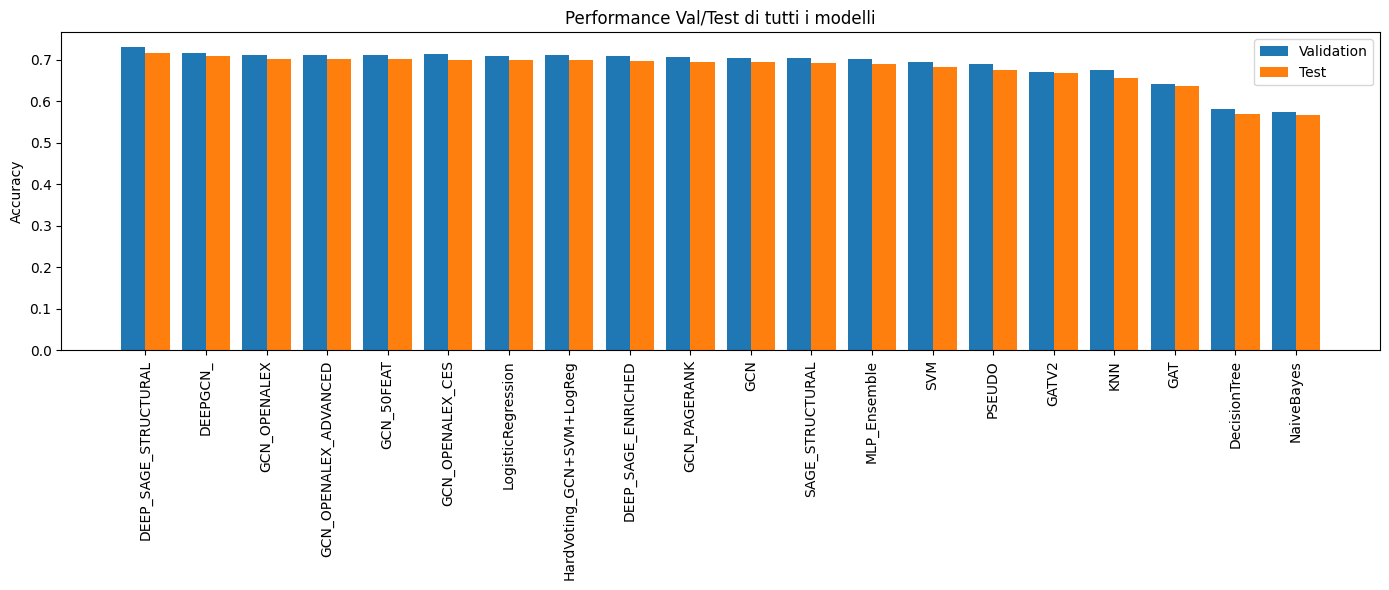

Model  Validation Accuracy  Test Accuracy       Type
0        DEEP_SAGE_STRUCTURAL             0.729000       0.716500        GNN
1                    DEEPGCN_             0.716600       0.707600        GNN
2                GCN_OPENALEX             0.711300       0.702200        GNN
3       GCN_OPENALEX_ADVANCED             0.710100       0.700200        GNN
4                  GCN_50FEAT             0.709900       0.700100        GNN
5            GCN_OPENALEX_CES             0.712700       0.699900        GNN
6          LogisticRegression             0.708312       0.698990  Classical
7   HardVoting_GCN+SVM+LogReg             0.710125       0.698475  Classical
8          DEEP_SAGE_ENRICHED             0.708300       0.697300        GNN
9                GCN_PAGERANK             0.706200       0.694700        GNN
10                        GCN             0.703400       0.694500        GNN
11            SAGE_STRUCTURAL             0.703100       0.690900        GNN
12               MLP_Ensemble             0.701701       0.689937  Classical
13                        SVM             0.694990       0.682262  Classical
14                     PSEUDO             0.688500       0.673900        GNN
15                      GATV2             0.669700       0.666400        GNN
16                        KNN             0.674251       0.656318  Classical
17                        GAT             0.640600       0.635900        GNN
18               DecisionTree             0.580825       0.569080  Classical
19                 NaiveBayes             0.574415       0.565850  Classical

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
from IPython.display import display

# === 1. Carica risultati modelli classici ===
df_classical = pd.read_csv("classical_model_results.csv")
df_classical["Type"] = "Classical"

# === 2. Carica log dei modelli GNN ===
log_files = glob("training_log_*.csv")
gnn_rows = []
for file in log_files:
    try:
        df = pd.read_csv(file)
        # Ignora file non compatibili
        if "val_acc" not in df.columns or "test_acc" not in df.columns:
            print(f"⚠️ File {file} saltato: colonne mancanti")
            continue
        model_name = os.path.basename(file).replace("training_log_", "").replace(".csv", "").upper()
        val_acc = df["val_acc"].max()
        test_acc = df.loc[df["val_acc"].idxmax(), "test_acc"]
        gnn_rows.append({
            "Model": model_name,
            "Validation Accuracy": val_acc,
            "Test Accuracy": test_acc,
            "Type": "GNN"
        })
    except Exception as e:
        print(f"⚠️ Errore su {file}: {e}")

df_gnn = pd.DataFrame(gnn_rows)

# === 3. Unione e ordinamento ===
df_all = pd.concat([df_classical, df_gnn], ignore_index=True)
df_all["Validation Accuracy"] = pd.to_numeric(df_all["Validation Accuracy"], errors="coerce")
df_all["Test Accuracy"] = pd.to_numeric(df_all["Test Accuracy"], errors="coerce")
df_all_sorted = df_all.sort_values("Test Accuracy", ascending=False)

# === 4. Bar chart ===
plt.figure(figsize=(14, 6))
bar_width = 0.4
x = np.arange(len(df_all_sorted))
plt.bar(x - bar_width/2, df_all_sorted["Validation Accuracy"], bar_width, label="Validation")
plt.bar(x + bar_width/2, df_all_sorted["Test Accuracy"], bar_width, label="Test")
plt.xticks(x, df_all_sorted["Model"], rotation=90)
plt.ylabel("Accuracy")
plt.title("Performance Val/Test di tutti i modelli")
plt.legend()
plt.tight_layout()
plt.savefig("confronto_modelli_val_test.png")
plt.show()

# === 5. Mostra tabella ordinata
display(df_all_sorted.reset_index(drop=True))

# === 6. (Opzionale) Salva tabella
df_all_sorted.to_csv("confronto_finale_risultati.csv", index=False)


In [37]:
from IPython.core.display import HTML
import pandas as pd

# Carica il file CSV finale
df = pd.read_csv("confronto_finale_risultati.csv")

# Costruzione della tabella HTML
html_table = df.to_html(index=False, classes="result-table")

# Codice HTML + CSS
html_code = f"""
<!DOCTYPE html>
<html>
<head>
    <style>
        .result-table {{
            font-family: Arial, sans-serif;
            border-collapse: collapse;
            width: 90%;
            margin: 20px auto;
            box-shadow: 0 0 10px rgba(0,0,0,0.1);
        }}
        .result-table th {{
            background-color: #4CAF50;
            color: white;
            padding: 12px;
        }}
        .result-table td {{
            border: 1px solid #ddd;
            padding: 10px;
            text-align: center;
        }}
        .result-table tr:nth-child(even) {{
            background-color: #f9f9f9;
        }}
        .result-table tr:hover {{
            background-color: #f1f1f1;
        }}
        h2 {{
            text-align: center;
            color: #4CAF50;
            font-family: Georgia, serif;
        }}
    </style>
</head>
<body>
    <h2>📊 Confronto Modelli: Validation e Test Accuracy</h2>
    {html_table}
</body>
</html>
"""


In [38]:
HTML(html_code)


⚠️ File mancante: decision_tree_results.csv
📊 Tutti i risultati KNN (tutti i valori di k):


Model  Validation Accuracy  Test Accuracy
10        GAT + K=3             0.651163       0.637224
11        GAT + K=4             0.663042       0.648129
12        GAT + K=5             0.671264       0.657552
13        GAT + K=6             0.674788       0.661996
14        GAT + K=7             0.678110       0.664445
15      GATv2 + K=3             0.670929       0.650680
16      GATv2 + K=4             0.679989       0.659959
17      GATv2 + K=5             0.685694       0.667593
18      GATv2 + K=6             0.689285       0.672880
19      GATv2 + K=7             0.690929       0.676954
5         GCN + K=3             0.661566       0.640825
6         GCN + K=4             0.671902       0.653190
7         GCN + K=5             0.680962       0.661153
8         GCN + K=6             0.684285       0.667490
9         GCN + K=7             0.686567       0.672016
0   GraphSAGE + K=3             0.674318       0.650042
1   GraphSAGE + K=4             0.682137       0.659198
2   GraphSAGE + K=5             0.688681       0.667366
3   GraphSAGE + K=6             0.688916       0.670720
4   GraphSAGE + K=7             0.690896       0.674506

⚠️ Errore su training_log_gatv2_enriched.csv: attempt to get argmax of an empty sequence
📥 embedding_classification_results.csv aggiunto.


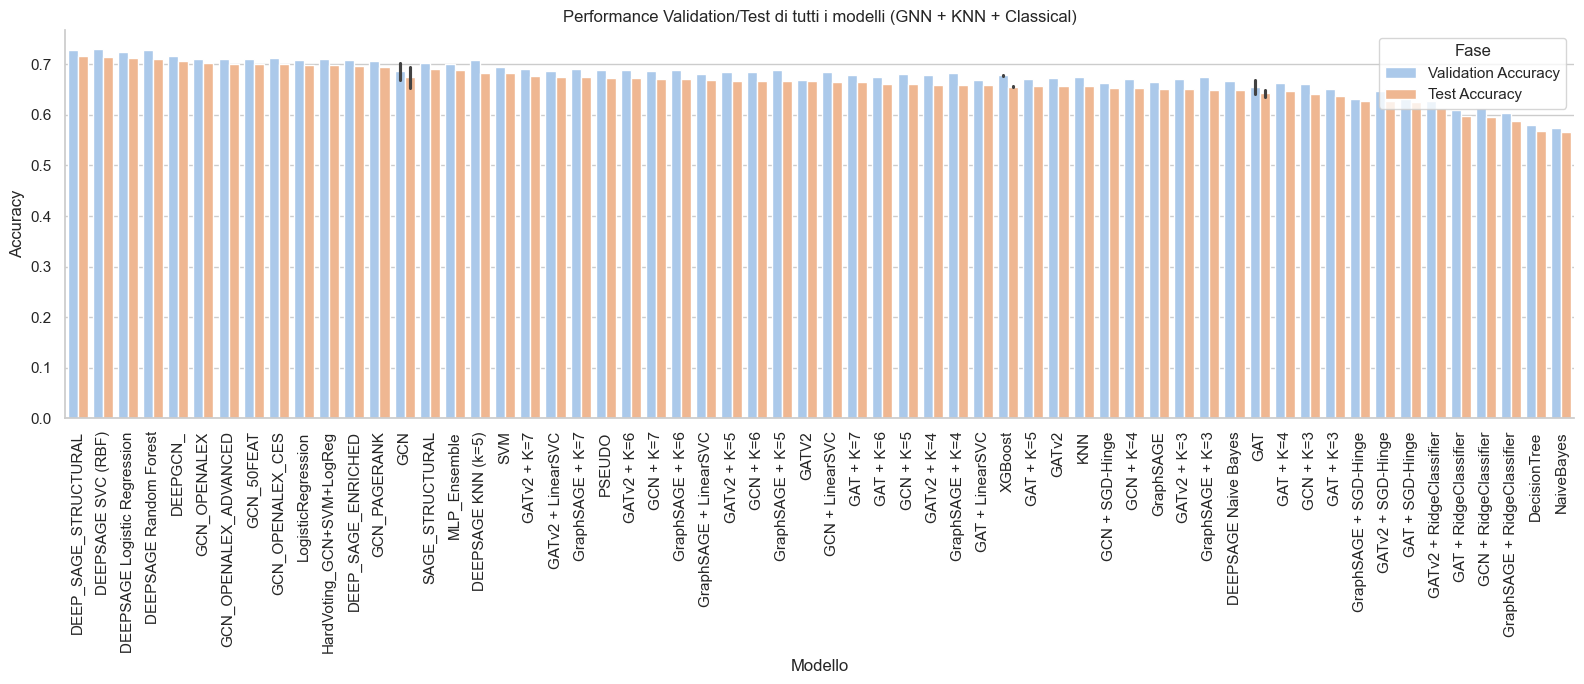

Model  Validation Accuracy  Test Accuracy  \
0           DEEP_SAGE_STRUCTURAL             0.729000       0.716500   
1             DEEPSAGE SVC (RBF)             0.730763       0.715409   
2   DEEPSAGE Logistic Regression             0.725561       0.712240   
3         DEEPSAGE Random Forest             0.728816       0.711664   
4                       DEEPGCN_             0.716600       0.707600   
5                   GCN_OPENALEX             0.711300       0.702200   
6          GCN_OPENALEX_ADVANCED             0.710100       0.700200   
7                     GCN_50FEAT             0.709900       0.700100   
8               GCN_OPENALEX_CES             0.712700       0.699900   
9             LogisticRegression             0.708312       0.698990   
10     HardVoting_GCN+SVM+LogReg             0.710125       0.698475   
11            DEEP_SAGE_ENRICHED             0.708300       0.697300   
12                  GCN_PAGERANK             0.706200       0.694700   
13                           GCN             0.703400       0.694500   
14               SAGE_STRUCTURAL             0.703100       0.690900   
15                  MLP_Ensemble             0.701701       0.689937   
16            DEEPSAGE KNN (k=5)             0.707775       0.682509   
17                           SVM             0.694990       0.682262   
18                   GATv2 + K=7             0.690929       0.676954   
19             GATv2 + LinearSVC             0.686399       0.675781   
20               GraphSAGE + K=7             0.690896       0.674506   
21                        PSEUDO             0.688500       0.673900   
22                   GATv2 + K=6             0.689285       0.672880   
23                     GCN + K=7             0.686567       0.672016   
24               GraphSAGE + K=6             0.688916       0.670720   
25         GraphSAGE + LinearSVC             0.681701       0.670103   
26                   GATv2 + K=5             0.685694       0.667593   
27                     GCN + K=6             0.684285       0.667490   
28               GraphSAGE + K=5             0.688681       0.667366   
29                         GATV2             0.669700       0.666400   
30               GCN + LinearSVC             0.684218       0.665453   
31                     GAT + K=7             0.678110       0.664445   
32                     GAT + K=6             0.674788       0.661996   
33                     GCN + K=5             0.680962       0.661153   
34                   GATv2 + K=4             0.679989       0.659959   
35               GraphSAGE + K=4             0.682137       0.659198   
36               GAT + LinearSVC             0.669586       0.658725   
37                       XGBoost             0.680000       0.657600   
38                     GAT + K=5             0.671264       0.657552   
39                         GATv2             0.673938       0.657339   
40                           KNN             0.674251       0.656318   
41                       XGBoost             0.677800       0.654500   
42                       XGBoost             0.677800       0.654500   
43                           GCN             0.669038       0.654047   
44               GCN + SGD-Hinge             0.664083       0.653725   
45                     GCN + K=4             0.671902       0.653190   
46                     GraphSAGE             0.665615       0.651290   
47                   GATv2 + K=3             0.670929       0.650680   
48               GraphSAGE + K=3             0.674318       0.650042   
49          DEEPSAGE Naive Bayes             0.667069       0.649939   
50                           GAT             0.669911       0.649191   
51                     GAT + K=4             0.663042       0.648129   
52                     GCN + K=3             0.661566       0.640825   
53                     GAT + K=3             0.651163       0.637224   
54                           GAT             0.640600       0.63590

💾 Tabella finale salvata in 'confronto_finale_risultati.csv'


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
from IPython.display import display
import seaborn as sns

pd.set_option("display.max_rows", None)        # mostra tutte le righe
pd.set_option("display.max_columns", None)     # mostra tutte le colonne
pd.set_option("display.width", 0)              # usa tutta la larghezza disponibile


# === 1. Carica tutti i CSV dei modelli classici ===
classical_csvs = [
    "classical_model_results.csv",
    "svm_variants_results.csv",
    "random_forest_results.csv",
    "decision_tree_results.csv",
    "deep_sage_classical_results.csv"
]

df_classical_all = []

for file in classical_csvs:
    if os.path.exists(file):
        df = pd.read_csv(file)

        if "Embedding" in df.columns:
            df = df.rename(columns={"Embedding": "Model"})

        if "Val Acc" in df.columns:
            df = df.rename(columns={"Val Acc": "Validation Accuracy"})
        if "Test Acc" in df.columns:
            df = df.rename(columns={"Test Acc": "Test Accuracy"})

        if "Model" not in df.columns:
            df["Model"] = "Unnamed"

        if "Classifier" in df.columns:
            df["Model"] = df["Model"] + " + " + df["Classifier"]
            df = df.drop(columns=["Classifier"])

        if "Embedding" in df.columns:
            df = df.drop(columns=["Embedding"])

        df["Type"] = "Classical"
        df_classical_all.append(df)
    else:
        print(f"⚠️ File mancante: {file}")

# === 1b. Gestione KNN separatamente: scegli miglior k per ciascun embedding ===
if os.path.exists("knn_results.csv"):
    df_knn_all = pd.read_csv("knn_results.csv")
    df_knn_all["Model"] = df_knn_all["Model"] + " + K=" + df_knn_all["k"].astype(str)
    df_knn_all = df_knn_all.rename(columns={"Val Acc": "Validation Accuracy", "Test Acc": "Test Accuracy"})
    df_knn_all["Type"] = "KNN"

    # Aggiungi KNN alla lista dei modelli classici
    df_classical_all.append(df_knn_all)

    # (facoltativo) salva KNN dettagliati
    df_knn_all_sorted = df_knn_all.sort_values(by=["Model"])
    df_knn_all_sorted.to_csv("knn_results_all_detailed.csv", index=False)
    print("📊 Tutti i risultati KNN (tutti i valori di k):")
    display(df_knn_all_sorted[["Model", "Validation Accuracy", "Test Accuracy"]])
else:
    print("⚠️ knn_results.csv non trovato.")

# === 1c. Unione modelli classici (classici + KNN) ===
df_classical = pd.concat(df_classical_all, ignore_index=True)

# === 2. Carica log dei modelli GNN ===
log_files = glob("training_log_*.csv")
gnn_rows = []

for file in log_files:
    try:
        df = pd.read_csv(file)
        if "val_acc" not in df.columns or "test_acc" not in df.columns:
            print(f"⚠️ File {file} saltato: colonne mancanti")
            continue
        model_name = os.path.basename(file).replace("training_log_", "").replace(".csv", "").upper()
        val_acc = df["val_acc"].max()
        test_acc = df.loc[df["val_acc"].idxmax(), "test_acc"]
        gnn_rows.append({
            "Model": model_name,
            "Validation Accuracy": val_acc,
            "Test Accuracy": test_acc,
            "Type": "GNN"
        })
    except Exception as e:
        print(f"⚠️ Errore su {file}: {e}")

df_gnn = pd.DataFrame(gnn_rows)

# === 2b. Aggiungi altri risultati da embedding ===
embedding_results_path = "embedding_classification_results.csv"
if os.path.exists(embedding_results_path):
    df_embedding = pd.read_csv(embedding_results_path)

    if "Embedding" in df_embedding.columns:
        df_embedding = df_embedding.drop(columns=["Embedding"])
    if "Val Accuracy" in df_embedding.columns:
        df_embedding = df_embedding.rename(columns={"Val Accuracy": "Validation Accuracy"})
    if "Test Acc" in df_embedding.columns:
        df_embedding = df_embedding.rename(columns={"Test Acc": "Test Accuracy"})
    if "Model" not in df_embedding.columns:
        df_embedding["Model"] = "Unnamed"

    df_embedding["Type"] = "Classical"
    df_classical = pd.concat([df_classical, df_embedding], ignore_index=True)
    print("📥 embedding_classification_results.csv aggiunto.")
else:
    print("⚠️ embedding_classification_results.csv mancante.")

# === 3. Unione completa ===
df_all = pd.concat([df_classical, df_gnn], ignore_index=True)
df_all = df_all[df_all["Type"].isin(["Classical", "GNN", "KNN"])]
df_all["Validation Accuracy"] = pd.to_numeric(df_all["Validation Accuracy"], errors="coerce")
df_all["Test Accuracy"] = pd.to_numeric(df_all["Test Accuracy"], errors="coerce")
df_all_sorted = df_all.sort_values(by=["Test Accuracy", "Validation Accuracy"], ascending=[False, False]).reset_index(drop=True)

# === 4. Bar chart comparativo ===
plt.figure(figsize=(16, 7))
sns.set(style="whitegrid")
df_melted = df_all_sorted.melt(id_vars=["Model", "Type"], value_vars=["Validation Accuracy", "Test Accuracy"],
                               var_name="Phase", value_name="Accuracy")

sns.barplot(data=df_melted, x="Model", y="Accuracy", hue="Phase", palette="pastel", dodge=True)
sns.despine()
plt.xticks(rotation=90)
plt.title("Performance Validation/Test di tutti i modelli (GNN + KNN + Classical)")
plt.xlabel("Modello")
plt.ylabel("Accuracy")
plt.legend(title="Fase")
plt.tight_layout()
plt.savefig("confronto_modelli_val_test.png")
plt.show()

# === 5. Mostra tabella finale ===
display(df_all_sorted)

# === 6. Salva tabella finale ===
df_all_sorted.to_csv("confronto_finale_risultati.csv", index=False)
print("💾 Tabella finale salvata in 'confronto_finale_risultati.csv'")


In [44]:
pip install sentence-transformers


   ---------------------------------------- 0.0/10.5 MB ? eta -:--:--
   --- ------------------------------------ 0.8/10.5 MB 3.0 MB/s eta 0:00:04
   -------- ------------------------------- 2.1/10.5 MB 4.9 MB/s eta 0:00:02
   ------------ --------------------------- 3.1/10.5 MB 4.9 MB/s eta 0:00:02
   ------------------ --------------------- 4.7/10.5 MB 5.4 MB/s eta 0:00:02
   ----------------------- ---------------- 6.0/10.5 MB 5.7 MB/s eta 0:00:01
   ----------------------------- ---------- 7.6/10.5 MB 5.9 MB/s eta 0:00:01
   ---------------------------------- ----- 8.9/10.5 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------  10.2/10.5 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------- 10.5/10.5 MB 6.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   --------------------- ------------------ 1.3/2.4 MB 6.7 MB/s eta 0:00:01
   ---------------------------------------- 2.4/2.4 MB 6.6 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
# === IMPORT NECESSARI ===
import torch
import pandas as pd
import numpy as np
import difflib

# === CONFIGURA I PERCORSI ===
embedding_path = "checkpoints/deepgcn_node_embeddings.pt"
node2paper_path = "dataset/ogbn-arxiv/ogbn_arxiv/mapping/nodeidx2paperid.csv.gz"
metadata_path = "openalex_from_magids.csv"

# === 1. CARICA GLI EMBEDDING ===
print("🔄 Caricamento embedding...")
all_embeddings = torch.load(embedding_path)
all_embeddings = all_embeddings / all_embeddings.norm(dim=1, keepdim=True)

# === 2. MAPPING node_idx → paper_id ===
print("🔄 Caricamento mapping node → paper...")
node2paper = pd.read_csv(node2paper_path, compression='gzip', header=None, names=["node_idx", "paper_id"])
node2paper["paper_id"] = node2paper["paper_id"].astype(str)

# === 3. METADATI (paper_id → titolo) ===
print("🔄 Caricamento metadati paper...")
metadata = pd.read_csv(metadata_path)
metadata.rename(columns={"MAG_ID": "paper_id"}, inplace=True)
metadata["paper_id"] = metadata["paper_id"].astype(str)

# === 4. JOIN + FILTRO node_idx validi ===
print("🔄 Unione mapping e metadati...")
joined = node2paper.merge(metadata, on="paper_id", how="inner")
joined["node_idx"] = joined["node_idx"].astype(int)
joined = joined[joined["node_idx"] < all_embeddings.shape[0]].copy()
joined = joined.reset_index(drop=True)

# === 5. FILTRA GLI EMBEDDING ===
node_indices = joined["node_idx"].tolist()
embeddings = all_embeddings[node_indices]

# Aggiungi indice tensoriale
joined["tensor_idx"] = joined.index

# === 6. DIZIONARI UTILI ===
title_to_node = dict(zip(joined["Title"], joined["node_idx"]))
node_idx_to_title = dict(zip(joined["node_idx"], joined["Title"]))
node_idx_to_tensor_idx = dict(zip(joined["node_idx"], joined["tensor_idx"]))
tensor_idx_to_node_idx = dict(zip(joined["tensor_idx"], joined["node_idx"]))

# === 7. FUNZIONE RACCOMANDAZIONE ===
def get_recommendations(input_title, top_k=5):
    matches = difflib.get_close_matches(input_title, title_to_node.keys(), n=1, cutoff=0.6)
    if not matches:
        print(f"❌ Nessuna corrispondenza trovata per: '{input_title}'")
        return

    best_match = matches[0]
    node_idx = title_to_node[best_match]
    tensor_idx = node_idx_to_tensor_idx[node_idx]
    input_embedding = embeddings[tensor_idx]

    similarities = torch.matmul(embeddings, input_embedding)
    top_tensor_indices = torch.topk(similarities, top_k + 1).indices.tolist()
    top_tensor_indices = [i for i in top_tensor_indices if i != tensor_idx][:top_k]
    top_node_indices = [tensor_idx_to_node_idx[i] for i in top_tensor_indices]

    print(f"\n🔍 Titolo cercato: {input_title}")
    print(f"✅ Corrispondenza trovata: {best_match}\n")
    print("📚 Articoli consigliati:")
    for i, idx in enumerate(top_node_indices, 1):
        print(f"{i}. {node_idx_to_title.get(idx, 'Titolo non trovato')}")

# === 8. ESEMPIO ===
get_recommendations("Provable Bounds for Learning Some Deep Representations", top_k=5)


🔄 Caricamento embedding...
🔄 Caricamento mapping node → paper...
🔄 Caricamento metadati paper...
🔄 Unione mapping e metadati...

🔍 Titolo cercato: Provable Bounds for Learning Some Deep Representations
✅ Corrispondenza trovata: Provable Bounds for Learning Some Deep Representations

📚 Articoli consigliati:
1. Learning Sparse Neural Networks via $\ell_0$ and T$\ell_1$ by a Relaxed Variable Splitting Method with Application to Multi-scale Curve Classification
2. Online and Stochastic Gradient Methods for Non-decomposable Loss Functions
3. Alchemy: A Quantum Chemistry Dataset for Benchmarking AI Models
4. An Experimental Comparison of Several Clustering and Initialization Methods
5. Bayesian Uncertainty Matching for Unsupervised Domain Adaptation


In [38]:
print("Tipo:", type(embeddings))
if isinstance(embeddings, dict):
    print("Chiavi:", list(embeddings.keys())[:5])
    sample = embeddings[list(embeddings.keys())[0]]
    print("Forma di un embedding:", sample.shape)
elif isinstance(embeddings, torch.Tensor):
    print("Forma tensor:", embeddings.shape)
else:
    print("Tipo non previsto.")


Tipo: <class 'torch.Tensor'>
Forma tensor: torch.Size([169343, 40])


In [55]:
# === IMPORT NECESSARI ===
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# === CONFIGURA PERCORSI ===
metadata_path = "openalex_from_magids.csv"

# === 1. CARICA I METADATI ===
print("🔄 Caricamento metadati paper...")
df = pd.read_csv(metadata_path)
df = df.dropna(subset=["Title"])
df = df.reset_index(drop=True)
titles = df["Title"].tolist()

# === 2. TF-IDF VECTORIZE TITOLI ===
print("🔄 Calcolo TF-IDF dei titoli...")
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
tfidf_matrix = vectorizer.fit_transform(titles)

# === 3. FUNZIONE RACCOMANDAZIONE (QUERY LIBERA) ===
def search_tfidf(query, top_k=5):
    print(f"\n🔍 Query utente: {query}")
    query_vec = vectorizer.transform([query])
    scores = cosine_similarity(query_vec, tfidf_matrix)[0]
    top_indices = np.argsort(scores)[::-1][:top_k]

    print("\n📚 Articoli consigliati (basati su somiglianza testuale):")
    for i, idx in enumerate(top_indices, 1):
        print(f"{i}. {df.iloc[idx]['Title']} (score: {scores[idx]:.4f})")

# === 4. ESEMPIO DI USO ===
search_tfidf("graph representation learning", top_k=5)


🔄 Caricamento metadati paper...
🔄 Calcolo TF-IDF dei titoli...

🔍 Query utente: graph representation learning

📚 Articoli consigliati (basati su somiglianza testuale):
1. Mimicking Human Process: Text Representation via Latent Semantic Clustering for Classification (score: 0.2788)
2. Imitation Learning with a Value-Based Prior (score: 0.2328)
3. Provable Bounds for Learning Some Deep Representations (score: 0.2328)
4. Learning to Segment and Represent Motion Primitives from Driving Data for Motion Planning Applications (score: 0.1419)
5. Learning Sparse Neural Networks via $\ell_0$ and T$\ell_1$ by a Relaxed Variable Splitting Method with Application to Multi-scale Curve Classification (score: 0.1306)


In [70]:
import pandas as pd

# === 1. Carica tutti i dati ===
metadata = pd.read_csv("openalex_enriched_parallel.csv")  # contiene 'MAG_ID', 'Title', 'Authors'
metadata["MAG_ID"] = metadata["MAG_ID"].astype(str)

node2paper = pd.read_csv(
    "dataset/ogbn-arxiv/ogbn_arxiv/mapping/nodeidx2paperid.csv.gz",
    skiprows=1,  # ✅ salta la riga d’intestazione
    header=None,
    names=["node_idx", "MAG_ID"]
)
node2paper["node_idx"] = node2paper["node_idx"].astype(int)
node2paper["MAG_ID"] = node2paper["MAG_ID"].astype(str)


pagerank_df = pd.read_csv("pagerank_scores.csv")
pagerank_df.rename(columns={"NodeID": "node_idx", "PageRank": "pagerank"}, inplace=True)
pagerank_df["node_idx"] = pagerank_df["node_idx"].astype(int)

# === 2. Filtra node2paper per compatibilità con data.y ===
valid_node_count = data.y.shape[0]
node2paper = node2paper[node2paper["node_idx"] < valid_node_count].copy()

# === 3. Costruisci df base: node_idx + MAG_ID + label_idx + categoria ===
df_base = node2paper.copy()
df_base["label_idx"] = data.y.view(-1).numpy()
df_base["arxiv_code"] = [class_names[i] for i in df_base["label_idx"]]
df_base["categoria"] = df_base["arxiv_code"].map(arxiv_nomi_umani)

# === 4. Unisci metadati + pagerank
df_merged = df_base.merge(metadata, on="MAG_ID", how="inner")
df_merged = df_merged.merge(pagerank_df, on="node_idx", how="left")

# === 5. Pulisci e filtra
df_final = df_merged.dropna(subset=["Title", "Authors", "categoria", "pagerank"]).reset_index(drop=True)

# === 6. Mostra info
print(f"✅ Totale articoli disponibili: {len(df_final)}")
print(df_final[["node_idx", "MAG_ID", "Title", "Authors", "categoria", "pagerank"]].head(3))
df_final.to_csv("df_final2.csv", index=False)


✅ Totale articoli disponibili: 167140
   node_idx     MAG_ID                                              Title  \
0         0    9657784  Evasion Attacks against Machine Learning at Te...   
1         1   39886162  How Hard is Computing Parity with Noisy Commun...   
2         2  116214155  On the absence of the RIP in real-world applic...   

                                             Authors  \
0  Battista Biggio; Igino Corona; Davide Maiorca;...   
1  Chinmoy Dutta; Yashodhan Kanoria; D. Manjunath...   
2              Alexander Bastounis; Anders C. Hansen   

                  categoria  pagerank  
0     Sicurezza Informatica  0.000062  
1  Computazione Distribuita  0.000003  
2  Teoria dell’Informazione  0.000007  


In [26]:
import pandas as pd
import torch

# ======================================
# 1. Caricamento metadata “arricchito”
# ======================================
metadata = pd.read_csv("openalex_enriched_parallel.csv", dtype={"MAG_ID": str})

# Forza MAG_ID come stringa
metadata["MAG_ID"] = metadata["MAG_ID"].astype(str)

# =========================================
# 2. Caricamento mapping node_idx ↔ MAG_ID
# =========================================
node2paper = pd.read_csv(
    "dataset/ogbn-arxiv/ogbn_arxiv/mapping/nodeidx2paperid.csv.gz",
    skiprows=1,
    header=None,
    names=["node_idx", "MAG_ID"],
    dtype={"node_idx": int, "MAG_ID": str}
)

# Filtra i nodi validi (assumendo che data.y sia già caricato)
valid_node_count = data.y.shape[0]
node2paper = node2paper[node2paper["node_idx"] < valid_node_count].copy()

# =================================
# 3. Caricamento PageRank
# =================================
pagerank_df = pd.read_csv("pagerank_scores.csv", dtype={"NodeID": int, "PageRank": float})
pagerank_df.rename(columns={"NodeID": "node_idx", "PageRank": "pagerank"}, inplace=True)

# ===============================================
# 4. Costruzione del DataFrame di base (df_base)
# ===============================================
df_base = node2paper.copy()

# Aggiungi label_idx da data.y
df_base["label_idx"] = data.y.view(-1).numpy()

# Mappa label_idx → arxiv_code → categoria
df_base["arxiv_code"] = df_base["label_idx"].map(lambda i: class_names[i])
df_base["categoria"] = df_base["arxiv_code"].map(arxiv_nomi_umani)

# ======================================
# 5. Merge con metadata e pagerank
# ======================================
# 5.1 Unione con metadata (on="MAG_ID")
df_merged = pd.merge(
    df_base,
    metadata,
    on="MAG_ID",
    how="inner",
    validate="one_to_one"
)

# 5.2 Unione con pagerank (on="node_idx")
df_merged = pd.merge(
    df_merged,
    pagerank_df,
    on="node_idx",
    how="left",
    validate="one_to_one"
)

# ================================================
# 6. Pulizia: eliminiamo righe con campi mancanti
# ================================================
df_final = df_merged.dropna(
    subset=["Title", "Authors", "categoria", "pagerank", "Publication_Date"]
).reset_index(drop=True)

# ================================================
# 7. Deriviamo l'anno di pubblicazione
# ================================================
df_final["Publication_Date"] = pd.to_datetime(
    df_final["Publication_Date"], errors="coerce", format="%Y-%m-%d"
)
df_final["Publication_Year"] = df_final["Publication_Date"].dt.year.fillna(0).astype(int)

# ================================================
# 8. (Opzionale) Trasformazioni “Lista” per Authors,
#    Concepts e Institutions
# ================================================
df_final["Authors_List"] = df_final["Authors"].apply(
    lambda s: [a.strip() for a in s.split(";")] if pd.notna(s) else []
)
df_final["Concepts_List"] = df_final["Concepts"].apply(
    lambda s: [c.strip() for c in str(s).split("|")] if pd.notna(s) else []
)
df_final["Institutions_List"] = df_final["Institutions"].apply(
    lambda s: [i.strip() for i in str(s).split(";")] if pd.notna(s) else []
)

# ================================================
# 9. Anteprima e salvataggio
# ================================================
print(f"✅ Totale articoli disponibili: {len(df_final)}")
print(df_final[[
    "node_idx", "MAG_ID", "Title", "Authors", "Institutions",
    "Concepts", "Citations", "Publication_Date", "Publication_Year", "pagerank"
]].head(5).to_string(index=False))

# Salvo su CSV
df_final.to_csv("df_final3.csv", index=False, encoding="utf-8")
print("✅ DataFrame arricchito salvato in ‘df_final2.csv’.")


✅ Totale articoli disponibili: 167140
 node_idx    MAG_ID                                                                                                                    Title                                                                                                                Authors                                                                                                                                                                                  Institutions                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [74]:
from rapidfuzz import process
import torch
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display, HTML

# === 1. Carica embeddings e dati ===
embeddings = torch.load("checkpoints/deepgcn_node_embeddings.pt")
embeddings = embeddings / embeddings.norm(dim=1, keepdim=True)
embeddings_np = embeddings.numpy()

df_final = pd.read_csv("df_final2.csv")
node_idx_list = df_final["node_idx"].tolist()

title_to_idx = dict(zip(df_final["Title"], df_final.index))
idx_to_info = (
    df_final[["Title", "Authors", "categoria", "pagerank", "node_idx"]]
    .drop_duplicates("Title")
    .set_index("Title")
    .to_dict(orient="index")
)

# === 2. Funzione con fuzzy matching e visualizzazione HTML ===
def recommend_papers_html_fuzzy(input_title, top_k=5, category_boost=0.05, author_boost=0.05, pagerank_weight=10.0):
    titles = list(title_to_idx.keys())
    
    # Match esatto o fuzzy
    if input_title in title_to_idx:
        matched_title = input_title
    else:
        best_match = process.extractOne(input_title, titles, score_cutoff=75)
        if best_match:
            matched_title = best_match[0]
            display(HTML(f"<p style='color:orange;'>🔍 Titolo non trovato. Uso il match più simile: <strong>{matched_title}</strong> (confidenza: {best_match[1]:.1f})</p>"))
        else:
            display(HTML(f"<p style='color:red;'>❌ Nessun titolo simile trovato per: '{input_title}'</p>"))
            return

    input_info = idx_to_info[matched_title]
    input_embedding = embeddings_np[input_info["node_idx"]].reshape(1, -1)
    sub_embeddings = embeddings_np[node_idx_list]
    similarities = cosine_similarity(input_embedding, sub_embeddings)[0]
    df_final["similarity"] = similarities

    input_authors = set(str(input_info["Authors"]).split(";"))
    input_category = input_info["categoria"]

    def compute_score(row):
        score = row["similarity"]
        if row["categoria"] == input_category:
            score += category_boost
        if any(author in input_authors for author in str(row["Authors"]).split(";")):
            score += author_boost
        score += pagerank_weight * row["pagerank"]
        return score

    df_final["score"] = df_final.apply(compute_score, axis=1)
    top_results = df_final[df_final["Title"] != matched_title].nlargest(top_k, "score").copy()

    def highlight(row):
        author_match = any(a in input_authors for a in str(row['Authors']).split(";"))
        category_match = row['categoria'] == input_category
        title_clean = row['Title'].replace('"', '').replace("'", "").replace("&", "and")

        return f"""
        <tr>
            <td style='text-align:center'>{row.name + 1}</td>
            <td>
              <a href="https://www.google.com/search?q={title_clean.replace(' ', '+')}" target="_blank" style="color:navy; text-decoration:underline;">
                🔗 {row['Title'][:120]}{'...' if len(row['Title']) > 120 else ''}
              </a>
            </td>
            <td>{row['categoria']} {'🎯' if category_match else ''}</td>
            <td>{row['Authors'][:60]}{'...' if len(row['Authors']) > 60 else ''} {'✔️' if author_match else ''}</td>
            <td style='text-align:right'>{row['similarity']:.4f}</td>
            <td style='text-align:right'>{row['pagerank']:.6f}</td>
            <td style='text-align:right; font-weight:bold; color:darkgreen'>{row['score']:.4f}</td>
        </tr>
        """

    rows_html = "\n".join([highlight(row) for _, row in top_results.iterrows()])

    # === Visualizzazione HTML ===
    display(HTML(f"""
    <div style='background:#e6f0ff;padding:20px;border-radius:10px;'>
      <p style='font-family:Arial;'><span style="color:#444;">📥 Inserisci il titolo (anche parziale o con errori):</span><br>
      <span style="color:#222;font-weight:bold;">➤ {input_title}</span></p>
      <h2 style='color:darkblue;'>📚 Raccomandazioni per: <em>{matched_title}</em></h2>
      <table style='border-collapse: collapse; width:100%; font-family:Arial;'>
          <thead>
              <tr style='background-color:#f2f2f2;'>
                  <th>🏅</th>
                  <th>📝 Titolo</th>
                  <th>📂 Categoria</th>
                  <th>👥 Autori</th>
                  <th>🧠 Similarità</th>
                  <th>📈 PageRank</th>
                  <th>⭐ Punteggio</th>
              </tr>
          </thead>
          <tbody>
              {rows_html}
          </tbody>
      </table>
      <p style='color:gray;font-style:italic;'>📁 File salvato come: <code>raccomandazioni.csv</code></p>
    </div>
    """))

    # === Salvataggio CSV ===
    top_results.to_csv("raccomandazioni.csv", index=False)

# === 3. Esecuzione interattiva ===
input_title = input("📥 Inserisci il titolo (anche parziale o con errori):\n> ")
recommend_papers_html_fuzzy(input_title.strip())


📥 Inserisci il titolo (anche parziale o con errori):
>  Multibeam Satellite Frequency/Time Duality Study and Capacity Optimization


In [16]:
!streamlit run streamlit_app.py

^C
